# PhD: EStreams variables exploration


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is used to explore the correlations between signatures but now using only catchment groups with from 20-40 nested catchments within. The idea is to use a more concise number of catchemnts to understand better the behaviour of the catchments. 


# Import modules

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon, Point
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings

from utils.functions import compute_correlation_score, find_unique_nested_catchments, find_directly_connected_catchments
from utils.plots import plot_histograms_by_group, plot_histograms_by_group_two_subsets, plot_watershed_groups_from_dict


# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = ".."

# Set the directory:
os.chdir(PATH)

warnings.simplefilter(action='ignore', category=Warning)

# Import data

### - Network information

In [ ]:
network_estreams = pd.read_csv('../estreams_part_b/data/EStreams/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

### - Filtered attributes

In [ ]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../estreams_part_b/data/exploration/estreams_attributes_filtered_moselle_3.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

In [ ]:
nested_catchments = pd.DataFrame(estreams_attributes['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

### - Geology high resolution FF (32 clases)

In [ ]:
estreams_geology_ff_31_classes_moselle = pd.read_csv("../estreams_part_b/data/new_attributes/estreams_geology_moselle_ff_all_classes_attributes.csv", encoding='utf-8')

estreams_geology_ff_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl'],
    
    "lower": ['lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "impermeable": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_31_classes_moselle[f'area_perm_{permeability_class}'] = estreams_geology_ff_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_31_classes_moselle = estreams_geology_ff_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable"]]

# Rename the columns
estreams_geology_ff_31_classes_moselle.columns = ["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]

# Display the updated DataFrame
estreams_geology_ff_31_classes_moselle

estreams_geology_ff_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
estreams_geology_ff_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]] = estreams_geology_ff_31_classes_moselle[["perm_high_ff2", "perm_medium_ff2", "perm_lower_ff2", "perm_impermeable_ff2"]]
estreams_attributes

In [7]:
estreams_attributes.to_csv("data/network/estreams_attributes_moselle_v01.csv")

### - Catchment boundaries

In [ ]:
catchment_boundaries = gpd.read_file('../estreams_part_b/data/EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries

# Investigation

### Multiple Linear Regression 

In [9]:
def compute_correlation(target_column, data_subset):
    """
    Compute the R2 coefficient for a given target column and data subset.

    Parameters:
        target_column (str): Name of the target column.
        data_subset (DataFrame): DataFrame containing the subset of data.

    Returns:
        DataFrame: DataFrame with R2 coefficient as a row.
    """
    # Extract target variable and features
    y = data_subset[target_column]
    X = data_subset.iloc[:, 14:-1]

    # Check if there are enough samples to compute R2 coefficient
    if len(X) <= 1:
        return pd.DataFrame({'Feature': ['R2_coefficient'], 'Coefficient': [np.nan]})
    
    # Define preprocessing steps
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define column transformer to apply preprocessing only to numeric features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('correlation', LinearRegression())])

    # Fit the pipeline
    pipeline.fit(X, y)
    
    # Compute R2 coefficient
    y_pred = pipeline.predict(X)
    r2_coefficient = r2_score(y, y_pred)

    # Create a DataFrame with R2 coefficient as a row
    r2_df = pd.DataFrame({'Feature': ['R2_coefficient'], 'Coefficient': [r2_coefficient]})
    
    return r2_df


### - Histograms considering different catchment groups

In [10]:
# Histograms for different catchments groups:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms_by_group(df, col_to_classify, num_cols=3):
    """
    Plot histograms for each class within each variable in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        col_to_classify (str): Name of the column containing the classes.
        num_cols (int): Number of columns in each row of subplots. Default is 3.
    """
    # Get unique classes
    classes = df[col_to_classify].unique()
    classes = classes.astype(int)
    num_classes = len(classes)
    
    # Determine number of rows and columns for subplots
    num_rows = (df.shape[1] - 1) // num_cols + 1

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))

    # Flatten the axes array
    axes = axes.flatten()

    # Plot histograms for each variable
    for i, (col, ax) in enumerate(zip(df.columns, axes)):
        if col != col_to_classify:
            for cls in classes:
                ax.hist(df[df[col_to_classify].astype(int) == cls][col], bins=10, alpha=0.5, label=cls)
            ax.set_title(col)
            ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()


### - Function to find the groups with no repeatetive catchments

In [11]:
def find_max_unique_rows(df):
    """
    Return rows with the maximum number of values not repeateded in the other rows.

    Parameters:
        df (DataFrame): The DataFrame containing rows with lists of values.

    Returns:
        list: A list of indices of rows with the maximum number of unique values.
    """
    max_unique_rows = []  # List to store the indices of rows with maximum number of values
    col_name = df.columns[0]  # Get the name of the column containing the lists of values
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        #current_row_values = row[col_name].split(', ')  # Convert string to list of values
        current_row_values = row[col_name]

        max_unique_count = len(current_row_values)  # Initialize the maximum count to the number of values in the current row
        
        # Loop through other rows to find potential overlapping rows
        for other_index, other_row in df.iterrows():
            if index != other_index:  # Skip the current row
                #other_row_values = other_row[col_name].split(', ')  # Convert string to list of values
                other_row_values = other_row[col_name] 

                # Find the intersection of values between the current row and the other row
                intersection = set(current_row_values).intersection(other_row_values)
                if intersection:  # If there's any intersection
                    other_row_count = len(other_row_values)
                    if other_row_count > max_unique_count:  # If the other row has more values than the current maximum
                        max_unique_count = other_row_count  # Update the maximum count
        
        # Add the index of the current row to the list if it has the maximum count of values
        if len(current_row_values) == max_unique_count:
            max_unique_rows.append(index)
    
    return max_unique_rows

# Pre-processing
* Selecting the catchments:

        - Here we select only the catchments upstream DEBU1959

In [420]:
# Here we filter the list of nested_catchments according to this first filter:
list_cats = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[list_cats, :]
nested_cats_df

,nested_catchments
basin_id,
DEBU1959,"[BEWA0066, BEWA0067, BEWA0087, BEWA0106, BEWA0..."


* Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

In [421]:
# Filter only the catchemnts using the function stated before:
nested_cats_filtered = find_max_unique_rows(nested_cats_df)

In [422]:
# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]

In [423]:
# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


In [424]:
nested_cats_filtered_df

,nested_catchments
basin_id,
DEBU1959,"[BEWA0066, BEWA0067, BEWA0087, BEWA0106, BEWA0..."


In [425]:
# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

In [426]:
# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
nested_cats_filtered_abovevalue

,len
DEBU1959,152.0


In [427]:
# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]
nested_cats_filtered_abovevalue_df

,nested_catchments
DEBU1959,"[BEWA0066, BEWA0067, BEWA0087, BEWA0106, BEWA0..."


In [428]:
# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

100%|██████████| 1/1 [00:00<00:00, 471.96it/s]


# Data analysis

In [429]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_watershed_groups_from_dict(estreams_attributes_used, title_plot="Plot title", figsize=(8, 6), ax=None, 
                                    add_legend=False, size_symbol=2, limits_europe=True):
    """
    Plot watershed groups on a map using GeoPandas.

    Parameters:
        estreams_attributes_used (dict): A dictionary containing watershed groups dataframes.
        title_plot (str): Title of the plot.
        figsize (tuple): Figure size in inches (width, height).
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes will be created.
        add_legend (bool): Whether to add a legend to the plot.
        size_symbol (int): Size of the symbols in the plot.
        limits_europe (bool): Whether to set the plot limits to Europe.

    Returns:
        None
    """
    
    # Load the world shapefile dataset provided by GeoPandas
    gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Set font properties using rcParams
    mpl.rcParams['font.family'] = 'arial'  # Change the font family
    mpl.rcParams['font.size'] = 8            # Change the font size
    mpl.rcParams['font.weight'] = 'normal'   # Change font weight
    mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Clear the subplot
    ax.clear()

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.1)

    # Calculate the bounds of the data if limits_europe is False
    if not limits_europe:
        all_lons = []
        all_lats = []
        for data in estreams_attributes_used.values():
            all_lons.extend(data['lon'])
            all_lats.extend(data['lat'])
        
        if all_lons and all_lats:
            min_lon, max_lon = min(all_lons), max(all_lons)
            min_lat, max_lat = min(all_lats), max(all_lats)
            margin = 0.05  # Add some margin to the bounds
            ax.set_xlim(min_lon - margin, max_lon + margin)
            ax.set_ylim(min_lat - margin, max_lat + margin)

    else:
        ax.set_xlim(-24, 45)
        ax.set_ylim(35, 70)

    # Define markers for each watershed group
    markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

    # Plot the gauges for each desired watershed group
    colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
    i = 0
    for catchment, data in estreams_attributes_used.items():
        marker = markers[i % len(markers)]  # Choose marker cyclically
        color = colors[i]  # Choose color from the colormap
        ax.scatter(data['lon'], data['lat'], color=color, edgecolor='black',
                    linewidth=0.01, marker=marker, s=size_symbol, label=catchment)
        i += 1

    ax.set_aspect('equal')  # Adjust aspect ratio as needed
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()  # Turn off both x-axis and y-axis

    # Set title for the plot
    ax.set_title(title_plot)
    # Add legend (if needed)
    if add_legend:
        ax.legend()

    # Adjust layout
    plt.tight_layout()


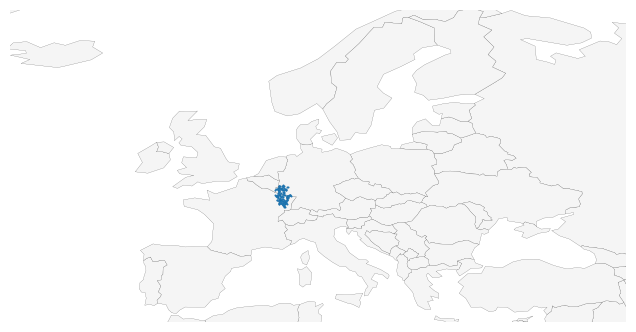

In [430]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)

In [431]:
## List of keys to filter
#keys_to_filter = estreams_attributes_dfs.keys()
#
## Initialize an empty list to store the DataFrames
#filtered_dfs_list = []
#
## Iterate through the list of keys and append each DataFrame to the list
#for key in keys_to_filter:
#    if key in estreams_attributes_dfs:
#        df = estreams_attributes_dfs[key].copy()  # Get the DataFrame
#        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
#        filtered_dfs_list.append(df)
#
## Concatenate all DataFrames in the list into a single DataFrame
#combined_df = pd.concat(filtered_dfs_list, ignore_index=True)
#combined_df
#
#combined_df.to_csv("B_exploration/results/attributes_filtered_Moselle_all_df.csv", encoding='utf-8')
#combined_df

In [432]:
estreams_attributes_dfs[catchment]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_ff2,perm_medium_ff2,perm_lower_ff2,perm_impermeable_ff2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.00,0.00,7.497,1.400,3.429,16.0,2.947531,0.000000,3.319025,93.733444
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.00,0.00,8.920,0.000,0.075,8.0,2.347625,0.000000,0.000000,97.652375
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.00,0.00,6.106,0.000,0.000,6.0,0.005000,0.000000,0.000000,99.995000
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.00,0.00,7.096,1.200,2.427,9.0,0.000000,0.000000,0.000000,100.000000
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.00,0.00,6.996,0.200,0.605,6.0,3.999021,0.000000,15.492765,80.508214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,1.80,62.62,5.680,0.045,0.045,25.0,1.917023,0.000000,0.000000,98.082977
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.00,0.00,2.863,0.004,0.009,15.0,14.327884,32.255374,53.416742,0.000000
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,2.67,67.85,4.753,1.641,4.770,78.0,18.753136,5.872553,24.977481,50.396831


In [442]:
estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
#estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]
estreams_attributes_dfs_cat

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_ff2,perm_medium_ff2,perm_lower_ff2,perm_impermeable_ff2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0066,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.00,0.00,7.497,1.400,3.429,16.0,2.947531,0.000000,3.319025,93.733444
BEWA0067,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.00,0.00,8.920,0.000,0.075,8.0,2.347625,0.000000,0.000000,97.652375
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.00,0.00,6.106,0.000,0.000,6.0,0.005000,0.000000,0.000000,99.995000
BEWA0106,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.00,0.00,7.096,1.200,2.427,9.0,0.000000,0.000000,0.000000,100.000000
BEWA0107,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.00,0.00,6.996,0.200,0.605,6.0,3.999021,0.000000,15.492765,80.508214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,1.80,62.62,5.680,0.045,0.045,25.0,1.917023,0.000000,0.000000,98.082977
LU000016,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.00,0.00,2.863,0.004,0.009,15.0,14.327884,32.255374,53.416742,0.000000
LU000017,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,2.67,67.85,4.753,1.641,4.770,78.0,18.753136,5.872553,24.977481,50.396831


## Correlation analysis

In [451]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       "perm_impermeable_ff2", "perm_lower_ff2", "perm_medium_ff2", "perm_high_ff2",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())

100%|██████████| 14/14 [00:00<00:00, 37.86it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


### Heatmaps

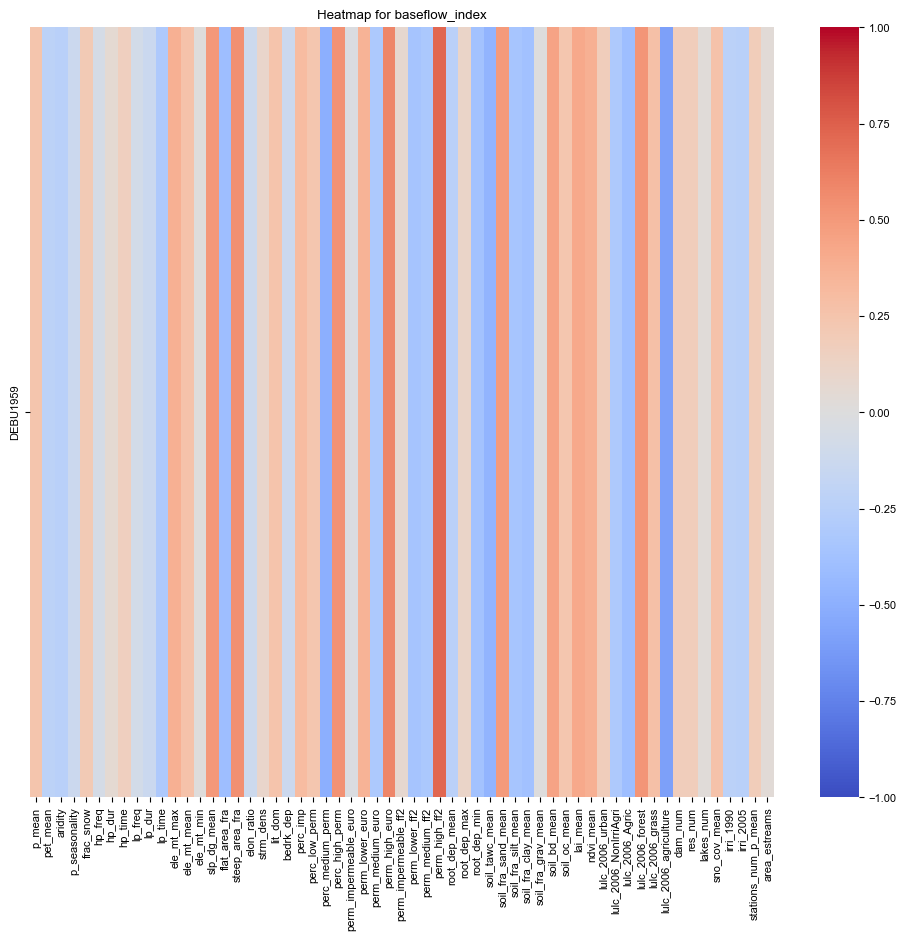

In [452]:
# baseflow_index corrrelations:
signature = "baseflow_index"
correlation_df = correlation_dict[signature].T

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

In [453]:
# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)


corr_df

,p_mean,pet_mean,aridity,p_seasonality,frac_snow,hp_freq,hp_dur,hp_time,lp_freq,lp_dur,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,area_estreams,signature
DEBU1959,-0.150046,0.147289,0.156618,0.095189,-0.166513,0.12272,0.024819,-0.051767,0.127737,0.135321,...,0.091786,-0.067114,-0.067114,-0.026518,-0.178905,0.010542,-0.015569,-0.166221,-0.124022,zero_q_freq


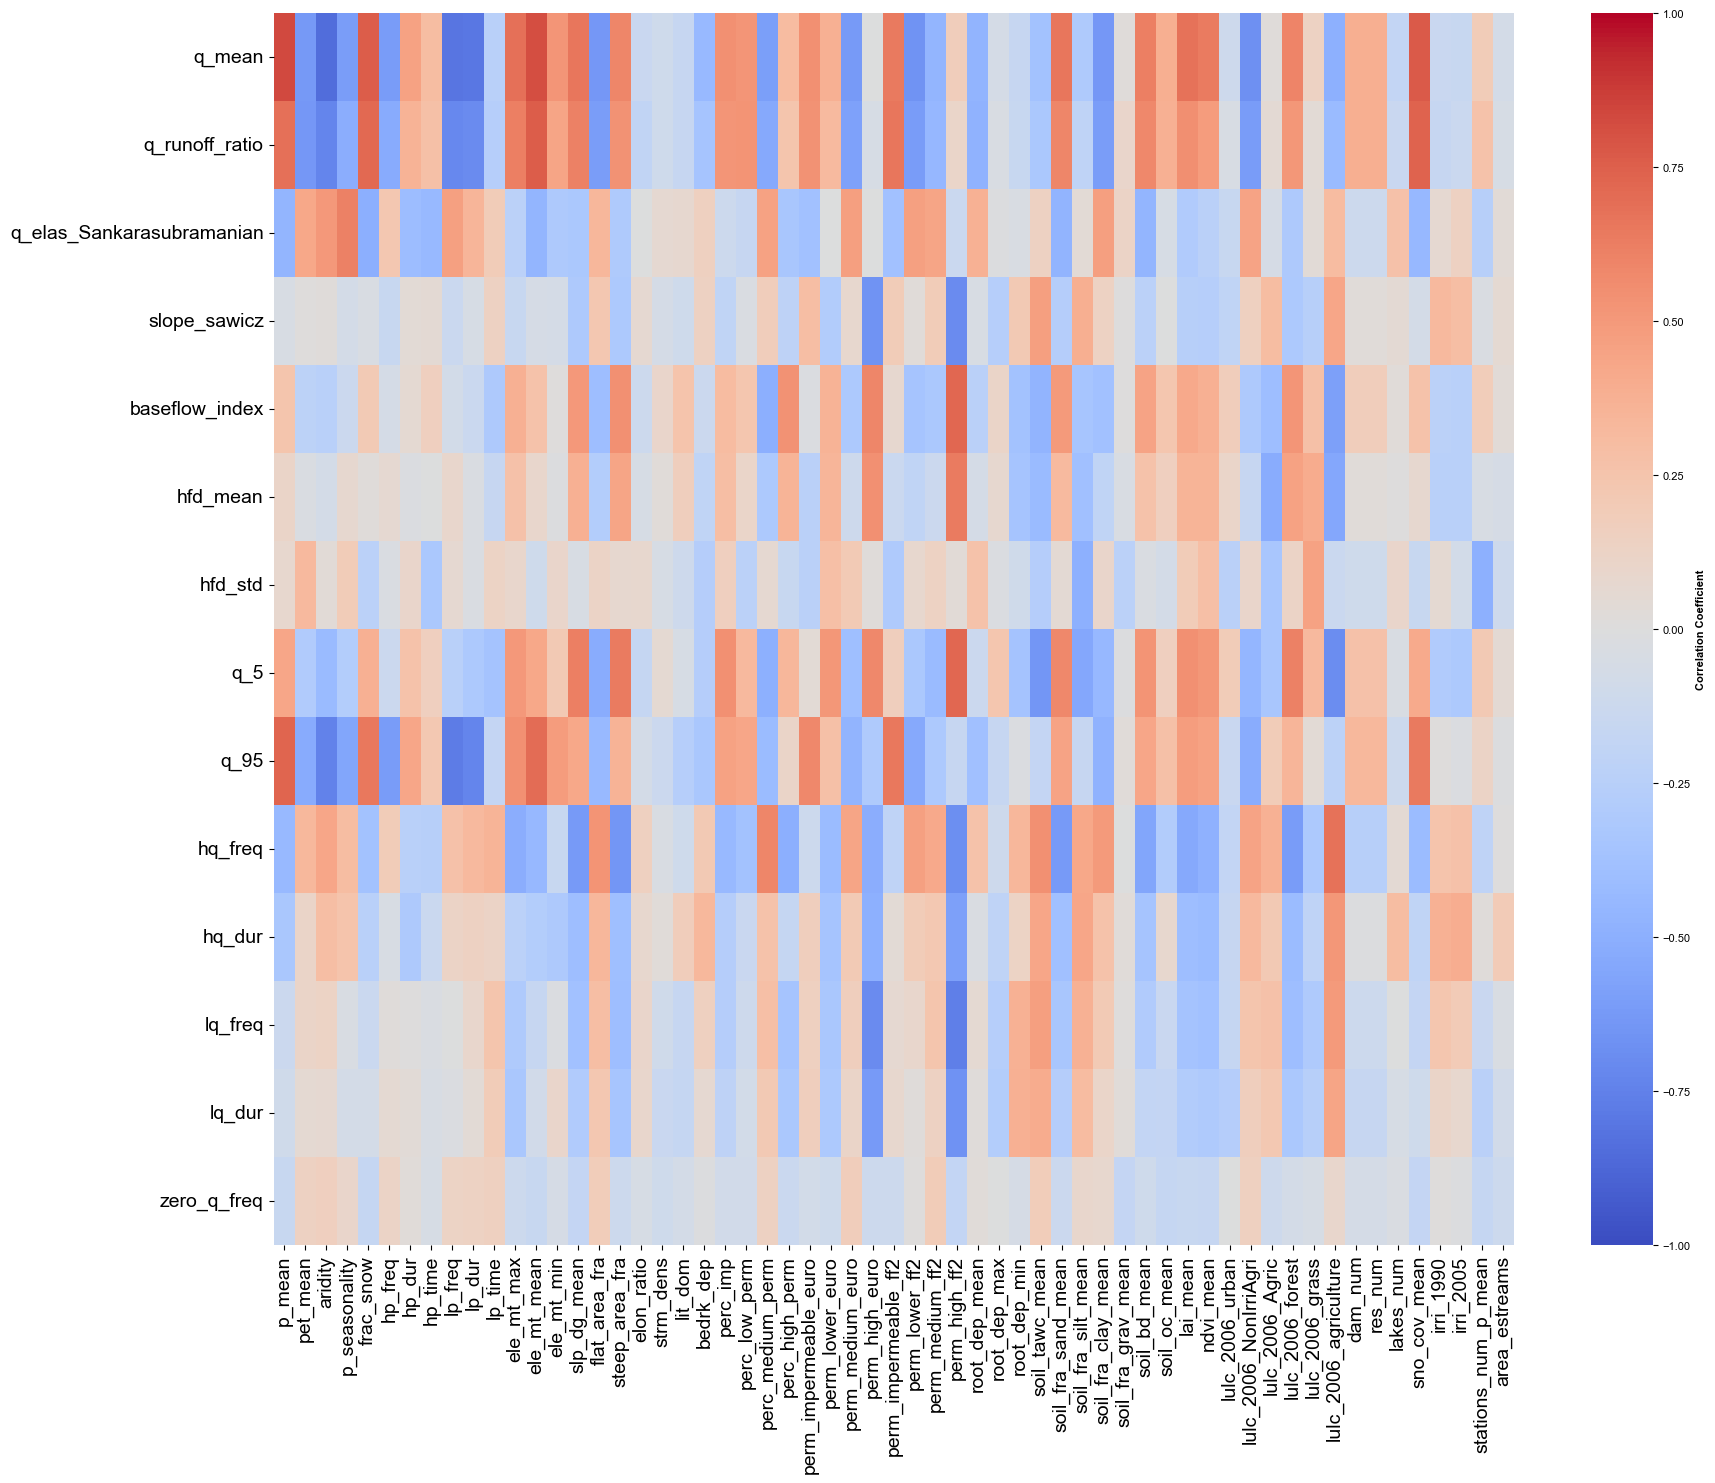

In [454]:
# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            yticklabels=combined_correlation_df.index)

#plt.title('Combined Heatmap for All Signatures', fontsize=20)
#plt.xlabel('Variables', fontsize=15)
plt.ylabel('', fontsize=15)

# Customize font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [455]:
combined_correlation_df.columns

Index(['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow',
       'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 'lp_dur', 'lp_time',
       'ele_mt_max', 'ele_mt_mean', 'ele_mt_min', 'slp_dg_mean',
       'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 'lit_dom',
       'bedrk_dep', 'perc_imp', 'perc_low_perm', 'perc_medium_perm',
       'perc_high_perm', 'perm_impermeable_euro', 'perm_lower_euro',
       'perm_medium_euro', 'perm_high_euro', 'perm_impermeable_ff2',
       'perm_lower_ff2', 'perm_medium_ff2', 'perm_high_ff2', 'root_dep_mean',
       'root_dep_max', 'root_dep_min', 'soil_tawc_mean', 'soil_fra_sand_mean',
       'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean',
       'soil_bd_mean', 'soil_oc_mean', 'lai_mean', 'ndvi_mean',
       'lulc_2006_urban', 'lulc_2006_NonIrriAgri', 'lulc_2006_Agric',
       'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture',
       'dam_num', 'res_num', 'lakes_num', 'sno_cov_mean', 'irri_1990',
 

In [456]:
combined_correlation_df.T

signature,q_mean,q_runoff_ratio,q_elas_Sankarasubramanian,slope_sawicz,baseflow_index,hfd_mean,hfd_std,q_5,q_95,hq_freq,hq_dur,lq_freq,lq_dur,zero_q_freq
p_mean,0.829768,0.682597,-0.468449,-0.041590,0.245129,0.114304,0.078421,0.430243,0.727720,-0.435182,-0.331153,-0.132583,-0.096315,-0.150046
pet_mean,-0.629177,-0.635672,0.427198,0.009017,-0.220092,-0.029000,0.324003,-0.294822,-0.528805,0.328223,0.114547,0.111852,0.060873,0.147289
aridity,-0.848782,-0.732738,0.505092,0.023146,-0.246028,-0.077811,0.036956,-0.422319,-0.743405,0.431734,0.290504,0.127238,0.067310,0.156618
p_seasonality,-0.602481,-0.510000,0.610955,-0.072416,-0.129408,0.072115,0.187803,-0.274410,-0.560893,0.300631,0.252729,-0.032936,-0.075808,0.095189
frac_snow,0.764451,0.713644,-0.504850,-0.037599,0.207157,0.016148,-0.228709,0.380990,0.655696,-0.371267,-0.247243,-0.139878,-0.073991,-0.166513
hp_freq,-0.612272,-0.529704,0.233839,-0.152066,-0.070253,0.062878,-0.027774,-0.125964,-0.609453,0.191798,-0.044776,0.020542,0.060943,0.122720
hp_dur,0.456050,0.365680,-0.412029,0.039783,0.058948,-0.023261,0.094399,0.258238,0.433521,-0.246863,-0.306720,0.006421,0.031514,0.024819
hp_time,0.300905,0.280283,-0.434868,0.052304,0.163094,-0.006867,-0.325080,0.162225,0.225050,-0.255516,-0.136742,-0.025134,-0.044544,-0.051767
lp_freq,-0.805704,-0.712889,0.463775,-0.139478,-0.084574,0.093509,0.070071,-0.247798,-0.777130,0.272487,0.120912,-0.007415,-0.023411,0.127737
lp_dur,-0.799505,-0.702402,0.350022,-0.052882,-0.138445,-0.030810,-0.026612,-0.313721,-0.728734,0.324477,0.146080,0.088011,0.042617,0.135321


In [457]:
combined_correlation_df[['perc_imp', 'perm_impermeable_euro', "perm_impermeable_ff2",
                         'perc_low_perm', 'perm_lower_euro', 'perm_lower_ff2', 
                         'perc_medium_perm', 'perm_medium_euro', 'perm_medium_ff2',
                         'perc_high_perm', 'perm_high_euro', "perm_high_ff2"]].T

signature,q_mean,q_runoff_ratio,q_elas_Sankarasubramanian,slope_sawicz,baseflow_index,hfd_mean,hfd_std,q_5,q_95,hq_freq,hq_dur,lq_freq,lq_dur,zero_q_freq
perc_imp,0.543336,0.521608,-0.117681,-0.200691,0.307991,0.292447,0.161802,0.543572,0.455023,-0.434663,-0.268003,-0.269052,-0.217702,-0.086265
perm_impermeable_euro,0.545373,0.538884,-0.375251,0.290230,-0.022020,-0.236641,-0.241126,0.046671,0.581978,-0.117223,0.166695,0.150501,0.169829,-0.081428
perm_impermeable_ff2,0.644696,0.661883,-0.380741,0.190250,0.077384,-0.135126,-0.301786,0.165678,0.653715,-0.209629,0.046741,0.067480,0.078699,-0.121510
perc_low_perm,0.519700,0.530047,-0.157871,-0.029032,0.235187,0.108590,-0.230183,0.323491,0.434269,-0.374139,-0.147887,-0.109657,-0.082500,-0.091643
perm_lower_euro,0.381147,0.312541,-0.003871,-0.289012,0.365131,0.346597,0.284459,0.513077,0.273992,-0.417393,-0.352569,-0.328382,-0.314736,-0.108010
perm_lower_ff2,-0.663852,-0.612393,0.464351,0.027154,-0.359207,-0.202723,0.078892,-0.325028,-0.535792,0.465881,0.194284,0.088938,0.018167,0.012804
perc_medium_perm,-0.594656,-0.532904,0.458386,0.173850,-0.504796,-0.318804,0.067881,-0.494298,-0.419773,0.590994,0.261615,0.282452,0.214789,0.142174
perm_medium_euro,-0.618078,-0.579849,0.472935,0.082097,-0.319391,-0.110347,0.209293,-0.391849,-0.471023,0.444664,0.210201,0.166732,0.111850,0.172730
perm_medium_ff2,-0.467486,-0.450318,0.445211,0.188741,-0.322499,-0.126001,0.133273,-0.423724,-0.316985,0.421120,0.222006,0.243003,0.147053,0.187922
perc_high_perm,0.311243,0.244344,-0.341400,-0.217995,0.537650,0.358503,-0.153276,0.340386,0.110751,-0.505564,-0.170512,-0.352337,-0.325645,-0.134350


In [441]:
df1 = estreams_attributes_dfs_cat.copy()

df1["num_years"] = estreams_attributes["num_years"]

df1[df1.num_years>1].corr(method="spearman")["baseflow_index"].tail(50)

lp_time                 -0.285347
ele_mt_max               0.337947
ele_mt_mean              0.203986
ele_mt_min              -0.001041
slp_dg_mean              0.427324
flat_area_fra           -0.315014
steep_area_fra           0.490192
elon_ratio              -0.104508
strm_dens                0.090571
lit_dom                  0.217288
bedrk_dep               -0.127151
perc_imp                 0.287463
perc_low_perm            0.200780
perc_medium_perm        -0.448081
perc_high_perm           0.473061
perm_impermeable_euro   -0.095056
perm_lower_euro          0.339365
perm_medium_euro        -0.223361
perm_high_euro           0.557096
perm_impermeable_ff2    -0.011665
perm_lower_ff2          -0.298355
perm_medium_ff2         -0.246993
perm_high_ff2            0.680013
root_dep_mean           -0.174990
root_dep_max             0.130400
root_dep_min            -0.358710
soil_tawc_mean          -0.448302
soil_fra_sand_mean       0.438186
soil_fra_silt_mean      -0.360358
soil_fra_clay_

In [ ]:
estreams_attributes_dfs_cat.columns

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
        "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}

# Select the variable
signature = "baseflow_index"
correlation_df = correlation_dict[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                  'corr_max_vegetation', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df.T.iloc[0:-2]

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
        "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}

# Select the variable
signature = "slope_sawicz"
correlation_df = correlation_dict[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                  'corr_max_vegetation', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df.T.iloc[0:-2]

In [ ]:
correlation_df.T[["perc_imp", "perc_low_perm", "perc_medium_perm", "perc_high_perm",
                "perm_impermeable_euro", "perm_lower_euro", "perm_medium_euro", "perm_high_euro",
                'perm_high_ff2', 'perm_medium_ff2', 'perm_lower_ff2',
       'perm_impermeable_ff2']].T

In [39]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


In [ ]:
corr_max_group_dfs.T

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap='PRGn', fmt=".2f", vmin=-1, vmax=1, alpha=0.7)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1, alpha=1.0)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
plt.savefig(r'results\figs\fig_paper_heatmap2.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
corr_max_group_dfs.abs()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (Continental)", "Geo. (Regional)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(11, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label(r'Maximum |$r_s$| [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define your custom color palette
colors = ['red', '#0000CD',  '#1E90FF', '#87CEEB', '#ADD8E6']  # Red, Purple, Light Blue, Darker Blue, Darkest Blue
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)  # N defines the resolution of the color map

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap using your custom colormap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap=custom_cmap, fmt=".2f", vmin=-1, vmax=1, alpha=1.0)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

# Save the figure
#plt.savefig(r'results\figs\fig_paper_heatmap2.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# Define your custom color palette in the correct order
colors = ['red', '#ADD8E6', '#87CEEB', '#1E90FF', '#0000CD']  # Red, Purple, Dark Blue, Blue, Light Blue
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=5)

# Define the boundaries to enforce discrete colors
boundaries = np.linspace(-1, 1, len(colors) + 1)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap using your custom colormap and norm
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap=custom_cmap, fmt=".2f", vmin=-1, vmax=1, alpha=0.75, norm=norm)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

# Save the figure
#plt.savefig(r'results\figs\fig_paper_heatmap2.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap='RdBu', fmt=".2f", vmin=-1, vmax=0.7, alpha=0.7)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap3.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import BoundaryNorm

# Define color map and categories
bounds = [-0.5, -0.25, 0, 0.25, 0.5]
cmap = plt.get_cmap('PRGn')
bounds = [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]  # Include -1 and 1 to cover values outside -0.5 to 0.5
norm = BoundaryNorm(bounds, cmap.N)

# Define your dataframes in a dictionary with keys as labels and values as dataframes
dataframes = {
    'q_mean': correlation_dict["q_mean"],
    'q_runoff_ratio': correlation_dict['q_runoff_ratio'],
    'q_elas_Sankarasubramanian': correlation_dict['q_elas_Sankarasubramanian'],
    "slope_sawicz": correlation_dict["slope_sawicz"],
    'baseflow_index': correlation_dict['baseflow_index'],
    'hfd_mean': correlation_dict['hfd_mean'],
    'hfd_std': correlation_dict['hfd_std'],
    "q_5": correlation_dict["q_5"],
    'q_95': correlation_dict['q_95'],
    'hq_freq': correlation_dict['hq_freq'],
    'hq_dur': correlation_dict['hq_dur'],
    "lq_freq": correlation_dict["lq_freq"],
    'lq_dur': correlation_dict['lq_dur'],
    'zero_q_freq': correlation_dict['zero_q_freq']
}

y_labels = ['Mean discharge', 'Runoff ratio', 'Streamflow-prec. elas.', 'FDC slope', 'Baseflow index', 
            'Half-flow date', 'Half-flow date std.', 'Q5 (low-flow)', 'Q95 (high-flow)', 'Freq. high-flows', 
            'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

x_labels = ["Area", "Latitude.", "Longitude", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
                 'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
                 'Dur. high-prec.', 'Time high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 
                 'Time low-prec.', 'Mean snow coverage', 
                 'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
                 'Gravel frac.', 'Bulk density', 'Frac. organic content', 
                 'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
                 "Number of lakes", "Irrigation volume", 
                 'Dominant geology',  'Unconsolidated sed.', 'Siliciclastic sed. rocks', 'Mixed sed. rocks', 'Carbonate rocks',
                 "Very low perm. geo."]

# Desired order of indices
desired_order = ["area_estreams", "lat", "lon", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 
                 'lp_dur', 'lp_time', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'lit_dom',  'lit_fra_su', 'lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'perc_imp']

# Reindex DataFrames
for key in dataframes:
    dataframes[key] = dataframes[key].reindex(desired_order)

# Define classes for importance and correlation (absolute values)
importance_classes = [0, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
importance_sizes = [10, 50, 100, 200, 300, 400, 500]  # Corresponding sizes for importance

# Define a function to map importance to sizes based on absolute value
def map_importance_to_size(importance):
    importance_abs = abs(importance)  # Take the absolute value of importance
    for i, threshold in enumerate(importance_classes):
        if importance_abs <= threshold:
            return importance_sizes[i]
    return importance_sizes[-1]  # Return the largest size if above all thresholds

# Map importance to sizes and save in each DataFrame
for key in dataframes:
    dataframes[key]['sizes'] = dataframes[key]['DEBU1959'].apply(map_importance_to_size)

# Define y positions dynamically based on the number of dataframes
y_positions = {key: idx + 1 for idx, key in enumerate(dataframes)}

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 13))

# Plot each dataframe
for label, df in dataframes.items():
    x = np.arange(len(df))
    sizes = df['sizes']
    colors = df['DEBU1959']
    y = [y_positions[label]] * len(df)
    ax.scatter(x, y, s=sizes, c=colors, cmap=cmap, norm=norm, alpha=1, edgecolors="w")

# Add vertical lines at specific x positions
vertical_lines_positions = [10.5, 21.5, 30.5, 37.5]  # Specify your desired positions here
for pos in vertical_lines_positions:
    ax.axvline(x=pos, color='black', linestyle='--', linewidth=1, alpha=0.2)

# Add labels
ax.set_xticks(np.arange(len(desired_order)))
ax.set_xticklabels(x_labels, rotation=90, ha="right")
ax.set_yticks(list(y_positions.values()))
ax.set_yticklabels(y_labels)

# Add color bar
cbar_ax = fig.add_axes([0.07, 0.02, 0.4, 0.01])  # Positioning color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', boundaries=bounds, ticks=bounds, alpha=0.7)
cbar.set_label('Spearman ranking correlation [-]', fontsize=10)
# Set font size for the color bar tick labels
cbar.ax.tick_params(labelsize=8)  # Change the number to your desired font size

# Add a size legend with custom sizes
for size, legend_size in zip(importance_classes[1:], importance_sizes[1:]):
    ax.scatter([], [], s=legend_size, c='gray', alpha=0.5, edgecolors='w', label=f'{size}')

# Manually set column titles at the top
fig.text(0.25, 0.995, "Topography", ha='center', va='center', fontsize=8, fontweight='bold')
fig.text(0.445, 0.995, "Climate", ha='center', va='center', fontsize=8, fontweight='bold')
fig.text(0.61, 0.995, "Soils", ha='center', va='center', fontsize=8, fontweight='bold')
fig.text(0.76, 0.995, "Land cover", ha='center', va='center', fontsize=8, fontweight='bold')
fig.text(0.90, 0.995, "Geology", ha='center', va='center', fontsize=8, fontweight='bold')

ax.set_ylim(0, len(dataframes) + 1)

# Create a horizontal legend at the bottom
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Increase in mean squared error of the random forest (incMSE) [-]', loc='lower center', 
          bbox_to_anchor=(0.75, -0.2), ncol=len(importance_classes)-1, fontsize=8)

plt.title(' ', fontsize=8)
plt.tight_layout()
plt.show()

In [177]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "topography"
}


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > max_corr[cls]:
                max_corr[cls] = corr_value
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels


# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

# Plot the heatmap
plt.figure(figsize=(10, 5))
#ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap='OrRd_r', fmt=".2f", vmin=0, vmax=1, alpha=0.7)
ax = sns.heatmap(corr_max_group_dfs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=0.7)


# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Max. absolute correlation coefficient [-]', fontsize=8)

#plt.title(f'Heatmap for {signature}')

plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:

correlation_dict["q_5"].T[["perc_imp", "perm_impermeable_euro", 'perm_impermeable_ff2',
                  "perc_low_perm", "perm_lower_euro", 'perm_lower_ff2',
                  "perc_medium_perm", "perm_medium_euro", 'perm_medium_ff2',
                  "perc_high_perm", "perm_high_euro",'perm_high_ff2']].T

In [ ]:
# Assuming correlation_dict is your input dictionary
# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

# List of keys in correlation_dict
keys = correlation_dict.keys()

# Define the columns you want to select for each key (based on your example for "q_5")
columns_to_select = ["perc_imp", "perm_impermeable_euro", 'perm_impermeable_ff2',
                     "perc_low_perm", "perm_lower_euro", 'perm_lower_ff2',
                     "perc_medium_perm", "perm_medium_euro", 'perm_medium_ff2',
                     "perc_high_perm", "perm_high_euro",'perm_high_ff2']

# Iterate through each key in the correlation_dict and extract the corresponding values
for key in keys:
    # Extract the relevant data, transpose it, and add it as a new column in result_df
    result_df[key] = correlation_dict[key].T[columns_to_select].T.values.flatten()

# Set the row names (index) to the columns_to_select list
result_df.index = columns_to_select

result_df

In [ ]:
estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]
estreams_attributes_dfs_cat

df = cat_clip.loc[cat_clip[cat_clip.area_estreams > 0].index]
df["area_estreams_log"] = np.log(df.area_estreams)
df

In [ ]:
df = estreams_attributes_dfs[catchment]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]
df

In [ ]:
df.loc[:, ["perm_high_ff2", "baseflow_index"]].corr(method="spearman")

In [ ]:
df.loc[:, ["perm_high_euro", "baseflow_index"]].corr(method="spearman")

In [ ]:
df.loc[:, ["perc_high_perm", "baseflow_index"]].corr(method="spearman")

In [ ]:
df["relief"] = df["ele_mt_max"] - df["ele_mt_min"] 
df.loc[:, ["relief", "baseflow_index"]].corr(method="spearman")

In [54]:
signatures = ['slope_sawicz', 'baseflow_index', 
              'hfd_mean','q_5', 'lq_freq', 'lq_dur']

# Here we generate some plots

In [ ]:
df

In [ ]:
estreams_attributes_dfs.keys()

In [ ]:
df = estreams_attributes_dfs["DEBU1959"]
df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr


df = estreams_attributes_dfs["DEBU1959"]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perc_high_perm", "perm_high_euro", "perm_high_ff2"]
x_cols = ["slope_sawicz", "baseflow_index", "q_5", "hfd_mean", "lq_freq", "hq_freq"]
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Global)", "Higher perm. [%] (Continental)", "Higher perm. [%] (Regional)"]
y_labels = ["Slope FDC \n[-]", "BFI \n[-]", "Q5 \n[mm/day]", "Mean half-flow date \n[DOY]", "Low-flow freq.\n[days/year]", "High-flow freq. \n[days/year]"]

# Create the subplots
fig, axs = plt.subplots(len(y_labels), 3, figsize=(9, 1.4*len(y_labels)))

k = 0
for j, x_col in enumerate(x_cols):
    # Loop through the y_cols to create each subplot
    for i, y_col in enumerate(y_cols):
        ax = axs[j, i]
        ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
        #ax.set_xlabel(x_labels[i])
        if i == 0:
            ax.set_ylabel(y_labels[j])

        if j == len(y_labels) - 1:
            ax.set_xlabel(x_labels[i])

        ax.set_title(f"({chr(97 + k)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
        

        # Drop NaNs and calculate Spearman correlation coefficient for all data
        non_nan_data_all = df[[y_col, x_col]].dropna()
        corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
        
        # Drop NaNs and calculate Spearman correlation coefficient for filtered data
        non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
        corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
        
        ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
        ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
        
        # Set y-axis limits
        #ax.set_ylim(0, 5)
        k = k + 1


# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=False)


plt.tight_layout()
fig.align_ylabels()

# Display the plot
plt.show()
fig.savefig(r'results\figs\fig_paper_combined_scatter.png', dpi=300, bbox_inches='tight')


# Individuals

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "slope_sawicz"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "Slope FDC [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.7))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    #ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(97 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)


plt.tight_layout()

# Display the plot
plt.show()
fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_1.png', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "baseflow_index"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.7))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    #ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(100 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_2.png', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "hfd_mean"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "Mean half-flow date [DOY]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.7))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    #ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(103 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)

plt.tight_layout()

# Display the plot
plt.show()
fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_3.png', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "q_5"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "Q5 [mm/day]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.7))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    #ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(106 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)

plt.tight_layout()

# Display the plot
plt.show()

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_4.png', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "lq_freq"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "Low-flow freq. [days/year]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.7))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    #ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(109 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)

plt.tight_layout()

# Display the plot
plt.show()
fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_5.png', dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_ff2", "perm_high_euro", "perc_high_perm"]
x_col = "hq_freq"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Higher perm. [%] (Country level)", "Higher perm. [%] (European level)", "Higher perm. [%] (Global level)"]
y_label = "High-flow freq. [days/year]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.8))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(112 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)
# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.18), frameon=False)

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_6.png', dpi=300, bbox_inches='tight')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["p_mean", "aridity", "ele_mt_mean"]
x_col = "q_mean"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Pmean [mm/day]", "Aridity [-]", "Mean elevation (m)"]
y_label = "Qmean [mm/day]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(97 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    #ax.text(0.05, 0.85, f'r (>250) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)
# Create a custom legend
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1000-10000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10000', edgecolors='none')
]

fig.legend(handles=handles, title='Area range (km²)', frameon=False, loc='center right')

# Adjust layout
#plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["p_mean", "aridity", "ele_mt_mean"]
x_col = "q_95"
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Pmean [mm/day]", "Aridity [-]", "Mean elevation (m)"]
y_label = "Q95 [mm/day]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(97 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    #ax.text(0.05, 0.85, f'r (>250) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)
# Create a custom legend
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1000-10000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10000', edgecolors='none')
]

fig.legend(handles=handles, title='Area range (km²)', frameon=False, loc='center right')

# Adjust layout
#plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["p_mean", "aridity", "ele_mt_mean"]
x_col = "q_mean"
size_col = "stations_num_p_mean"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 2:
        return 2.5, 'red'  # Dark Blue
    elif 2 <= area < 5:
        return 10, '#0000CD'  # Medium Blue
    elif 5 <= area < 10:
        return 30, '#1E90FF'  # Dodger Blue
    elif 10 <= area < 25:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["Pmean [mm/day]", "Aridity [-]", "Mean elevation (m)"]
y_label = "Qmean [mm/day]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

# Loop through the y_cols to create each subplot
for i, (ax, y_col) in enumerate(zip(axs, y_cols)):
    ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
    ax.set_xlabel(x_labels[i])
    if i == 0:
        ax.set_ylabel(y_label)
    ax.set_title(f"({chr(97 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    
    # Drop NaNs and calculate Spearman correlation coefficient for all data
    non_nan_data_all = df[[y_col, x_col]].dropna()
    corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
    
    # Drop NaNs and calculate Spearman correlation coefficient for filtered data
    non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
    corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
    
    ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
    #ax.text(0.05, 0.85, f'r (>250) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
    
    # Set y-axis limits
    #ax.set_ylim(0, 5)
# Create a custom legend
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<2', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='2-5', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='5-10', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='10-25', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>25', edgecolors='none')
]

fig.legend(handles=handles, title='N. of stations from EOBS', frameon=False, loc='center right')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])


# Display the plot
plt.show()


In [ ]:
df.stations_num_p_mean.describe()

In [ ]:
import pandas as pd

# Define the variable classification dictionary
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'topography',
    'ele_mt_mean': 'topography',
    'ele_mt_min': 'topography',
    'slp_dg_mean': 'topography',
    'flat_area_fra': 'topography',
    'steep_area_fra': 'topography',
    'elon_ratio': 'topography',
    'strm_dens': 'topography',
    'lit_dom': 'geology',
    'bedrk_dep': 'geology',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    'perm_mos_ff': 'geology_high',
    'semiperm_mos_ff': 'geology_high',
    'imper_mos_ff': 'geology_high',
    'perm_high_ff2': 'geology_high',
    'perm_medium_ff2': 'geology_high',
    'perm_lower_ff2': 'geology_high',
    'perm_impermeable_ff2': 'geology_high',
    'area_estreams': 'topography'
}

# Define the list of signatures to be processed
signatures = ["q_mean", "baseflow_index"]  # Example signatures list

# Define the classes
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

# Initialize the final DataFrame to hold results for each signature
final_corr_max_group_df = pd.DataFrame()

for signature in signatures:
    # Get the correlation dataframe for the current signature
    correlation_df = correlation_dict[signature]

    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"{signature}_corr_max_{cls}")
        columns.append(f"{signature}_corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: -1 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > max_corr[cls]:
                max_corr[cls] = corr_value
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"{signature}_corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"{signature}_corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"{signature}_corr_max_feature_{cls}"] = corr_max_group_df[f"{signature}_corr_max_feature_{cls}"].map(variable_dict)

    # Convert relevant columns to float for sorting and calculations
    for cls in classes:
        corr_max_group_df[f"{signature}_corr_max_{cls}"] = corr_max_group_df[f"{signature}_corr_max_{cls}"].astype(float)

    # Append the results to the final dataframe
    final_corr_max_group_df = pd.concat([final_corr_max_group_df, corr_max_group_df], axis=1)

# Transpose the dataframe for easier interpretation
final_corr_max_group_df = final_corr_max_group_df.T
final_corr_max_group_df


### Observations
* The main thing we can spot from the data is that if we do not include the high resolution geology, we in fact decrease the maximum correlation we can reach. 
* This indicates a dependecy to the scale, and in this case, this is explained in a catchment dominated by geology. 


### Maximum correlation

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict.items():
    # Get the maximum correlation coefficient for each group
    max_correlation = df.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_df = pd.DataFrame(max_correlation_dict)

# Print the DataFrame
max_correlation_df.T

### MLR

* Glim

In [ ]:
df.corr()

In [192]:
estreams_attributes_dfs_cat = estreams_attributes_dfs["DEBU1959"]

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your data
df = estreams_attributes_dfs_cat[["baseflow_index", 'perc_imp', 'perc_low_perm', 'perc_medium_perm', 
                                    'perc_high_perm']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
np.sqrt(r2)

* European

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your data
df = estreams_attributes_dfs_cat[["baseflow_index", 'perm_high_euro', 'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
np.sqrt(r2)

* Fabrizio

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your dat
df = estreams_attributes_dfs_cat[["baseflow_index", 'perm_high_ff2', 'perm_medium_ff2', 'perm_lower_ff2',
       'perm_impermeable_ff2']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
np.sqrt(r2)

In [ ]:
# Get the coefficients
coefficients = model.coef_

# Get the intercept
intercept = model.intercept_

# Print the results
print("Intercept:", intercept)
print("Coefficients:", coefficients)

## Note:
##### It is clear that we increase the CC by adding the high resolution map.
#### We did not find a clear increase in R when increasing the number of lithological variables. 
* It is interesting that the correlation to q_mean decrreases with the increase in the geology representation. q_mean is correlated to p_mean, is it used to derive these global models?

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your data
df = estreams_attributes_dfs_cat[["baseflow_index",
    'perm_high_ff2','perm_medium_ff2', 'perm_lower_ff2',
       'perm_impermeable_ff2']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
r2

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your data
df = estreams_attributes_dfs_cat[["baseflow_index",
    'root_dep_min',
    'soil_tawc_mean',
    'soil_fra_sand_mean',
    'soil_fra_silt_mean',
    'soil_fra_clay_mean',
    'soil_bd_mean']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
r2

In [ ]:
df.corr()

## Subcatchments analysis

In [ ]:
# Filter the catchments in Moselle

cats_moselle = estreams_attributes_dfs["DEBU1959"][estreams_attributes_dfs["DEBU1959"].end_date >= "1900"].index.tolist()
len(cats_moselle)

In [ ]:
# Filter only the Moselle catchments
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]
estreams_attributes_moselle

In [ ]:
estreams_attributes_moselle.gauges_upstream.head(50)

In [ ]:
# First we filter the potential watersheds:
list_cats_moselle = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream <= 60][estreams_attributes_moselle.gauges_upstream >= 10].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Here we filter the list of nested_catchments according to this first filter:
nested_cats_moselle_df = nested_catchments.loc[list_cats_moselle, :]

print("Number of catchemnts with potentially nested catchments:", len(list_cats_moselle))

In [ ]:
# Filter only the catchemnts using the function stated before (unique headwaters):
nested_cats_moselle_filtered = find_unique_nested_catchments(nested_cats_moselle_df)
print(nested_cats_moselle_filtered)

In [109]:
# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_moselle_df = nested_catchments.loc[nested_cats_moselle_filtered, :]

In [ ]:
nested_catchments.loc["FR003283", "nested_catchments"]

In [ ]:
# Store the variables for the selected catchments in a list of dataframes:
estreams_attributes_headwaters_moselle_dfs = {}

for catchment in tqdm.tqdm(nested_cats_moselle_filtered):

    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_moselle_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes_moselle.index]

    cat_clip = estreams_attributes.loc[nested_clip, :]

    estreams_attributes_headwaters_moselle_dfs[catchment] = cat_clip

In [ ]:
catchment

In [ ]:
nested_cats_filtered_moselle_df.loc[catchment, 'nested_catchments']

In [114]:
# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens_moselle = pd.DataFrame(index = estreams_attributes_headwaters_moselle_dfs.keys())
for catchment, data in estreams_attributes_headwaters_moselle_dfs.items():
    catchment_lens_moselle.loc[catchment, "len"] = len(data)

In [ ]:
catchment_lens_moselle

In [ ]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_headwaters_moselle_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='List of headwater nested catchments selected', add_legend = True, size_symbol = 10, 
                               limits_europe = False)

In [ ]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_headwaters_moselle_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='List of headwater nested catchments selected', add_legend = True, size_symbol = 20, 
                               limits_europe = False)

In [ ]:
estreams_attributes_headwaters_moselle_dfs.keys()

In [ ]:
# List of keys to filter
keys_to_filter = estreams_attributes_headwaters_moselle_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_headwaters_moselle_dfs:
        df = estreams_attributes_headwaters_moselle_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)
combined_df

In [ ]:
estreams_attributes_headwaters_moselle_dfs.keys()

In [ ]:
for outlet in estreams_attributes_headwaters_moselle_dfs.keys():
    print(outlet)
    print(estreams_attributes.loc[outlet, "area_estreams"])
    print(len(estreams_attributes_headwaters_moselle_dfs[outlet]))

In [ ]:
estreams_attributes

In [78]:
#combined_df.to_csv("B_exploration/results/attributes_filtered_Moselle_headwaters_df.csv", encoding='utf-8')

In [ ]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_hw_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_headwaters_moselle_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_headwaters_moselle_dfs[catchment]
        
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 
       'perc_imp', 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
       'perm_impermeable_euro','perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
       'perm_impermeable_ff2', 'perm_lower_ff2', 'perm_medium_ff2','perm_high_ff2',
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_hw_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_hw_moselle.keys())

In [ ]:
# baseflow_index corrrelations:
signature = "q_mean"
correlation_df = correlation_dict_hw_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.savefig(r'results\figs\fig_heatmap_headwaters_q_mean.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# baseflow_index corrrelations:
signature = "baseflow_index"

y_labels = ["Area", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
                 'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
                 'Dur. high-prec.', 'Time high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 
                 'Time low-prec.', 'Mean snow coverage', 
                 'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
                 'Gravel frac.', 'Bulk density', 'Frac. organic content', 
                 'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
                 "Number of lakes", "Irrigation volume", 
                 'Lower perm. [global]', 'Lower perm. [euro.]', 'Lower perm. [country]',
                 'Medium perm. [global]', 'Medium perm. [euro.]', 'Medium perm. [country]',
                 'Higher perm. [global]', 'Higher perm. [euro.]', 'Higher perm. [country]']

# Desired order of indices
desired_order = ["area_estreams", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 
                 'lp_dur', 'lp_time', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'perc_low_perm', 'perm_lower_euro', 'perm_lower_ff2',
                 'perc_medium_perm','perm_medium_euro', 'perm_medium_ff2', 
                 'perc_high_perm', 'perm_high_euro', 'perm_high_ff2']


correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('Correlation coefficient [-]', fontsize=8)
plt.text(-0.02, 0.8, 'Topography', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.64, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.5, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.36, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.17, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")


plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi.png', dpi=300, bbox_inches='tight')


plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ["Area", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
            'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
            'Dur. high-prec.', 'Time high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 
            'Time low-prec.', 'Mean snow coverage', 
            'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
            'Gravel frac.', 'Bulk density', 'Frac. organic content', 
            'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
            "Number of lakes", "Irrigation volume", 
            'Lower - global', 'Lower - european', 'Lower - country',
            'Medium - global', 'Medium - european', 'Medium - country',
            'Higher - global', 'Higher - european', 'Higher - country']

# Desired order of indices
desired_order = ["area_estreams", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 
                 'lp_dur', 'lp_time', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'perc_low_perm', 'perm_lower_euro', 'perm_lower_ff2',
                 'perc_medium_perm','perm_medium_euro', 'perm_medium_ff2', 
                 'perc_high_perm', 'perm_high_euro', 'perm_high_ff2']

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('Correlation coefficient [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Adding text outside the plot for section titles
plt.text(-0.02, 0.8, 'Topography', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.64, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.47, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.32, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.18, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ["Area", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
            'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
            'Dur. high-prec.', 'Time high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 
            'Time low-prec.', 'Mean snow coverage', 
            'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
            'Gravel frac.', 'Bulk density', 'Frac. organic content', 
            'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
            "Number of lakes", "Irrigation volume", 
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.']

# Desired order of indices
desired_order = ["area_estreams", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time', 'lp_freq', 
                 'lp_dur', 'lp_time', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm',
                 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
                 'perm_lower_ff2','perm_medium_ff2', 'perm_high_ff2']

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8, fontweight="bold")
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('Correlation coefficient [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Adding text outside the plot for section titles
plt.text(-0.03, 0.8, 'Topography', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.64, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.47, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.32, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.18, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.15, 'Regional', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.20, 'Continental', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.02, 0.25, 'Global', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ["Area", 'Mean elevation', 'Min. elevation', 'Max. elevation', 'Mean slope', 
            'Frac. flat area', 'Frac. steep area', 'Enlogation ratio', 'River net. density', 
            'Mean precipitation','Aridity', 'Prec. seasonality', 'Frac. of prec. as snow', 'Freq. high-prec.', 
            'Dur. high-prec.', 'Freq. low-prec.', 'Dur. low-prec.', 'Mean snow coverage', 
            'Soil depth', 'Root depth', 'TAWC','Sand frac.', 'Silt frac.', 'Clay frac.', 
            'Gravel frac.', 'Bulk density', 'Frac. organic content', 
            'LAI', 'NDVI', 'Forest cover', 'Grasslands cover', 'Agric. cover', 
            "Number of lakes", "Irrigation volume", 
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.',
            'Lower perm.', 'Medium perm.', 'Higher perm.']

# Desired order of indices
desired_order = ["area_estreams", 'ele_mt_mean', "ele_mt_min", "ele_mt_max", 'slp_dg_mean', 
                 'flat_area_fra', 'steep_area_fra', 'elon_ratio', 'strm_dens', 
                 'p_mean','aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'lp_freq', 
                 'lp_dur', 'sno_cov_mean', 
                 'bedrk_dep', 'root_dep_mean', 'soil_tawc_mean','soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 
                 'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 
                 'lai_mean', 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_grass', 'lulc_2006_agriculture', 
                 "lakes_num", "irri_2005", 
                 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm',
                 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
                 'perm_lower_ff2','perm_medium_ff2', 'perm_high_ff2']

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1, alpha=0.9)

# Set the x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8, fontweight="bold")
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('$r_{\mathregular{s}}$ [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Adding text outside the plot for section titles
plt.text(-0.03, 0.8, 'Topography', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.64, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.47, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.32, 'Land cover', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.18, 'Geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.15, 'Regional', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.20, 'Continental', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.01, 0.25, 'Global', va='center', ha='left', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Observations
* These results show that even considering a single basin (Moselle), if we take different headwaters, the correlations to their signatures vary considerably. 
* It means that, even tho some attributes may be always high correlated, this is rare and in practical terms, the catchments present different correlations. 
* Uniqueness of place. Each sub-basins behaves as a single-organism. In my opinion, so far, our best approach is to indeed to try to identify when each dominant factor dominates. 
* One model to rule them all is impractical. 
* q_mean seem to correlate well in a more common pattern than the baseflow_index.

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'terrain',
    'ele_mt_mean': 'terrain',
    'ele_mt_min': 'terrain',
    'slp_dg_mean': 'terrain',
    'flat_area_fra': 'terrain',
    'steep_area_fra': 'terrain',
    'elon_ratio': 'terrain',
    'strm_dens': 'terrain',
    'lit_dom': "none",
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'lulc',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "terrain"
}

# Select the variable
signature = "baseflow_index"
correlation_df = correlation_dict_hw_moselle[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "lulc", "soil", "terrain", "vegetation", "hydrology", "geology_med", "geology_high", "geology_low", "none"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology', "corr_max_geology_low", "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_soil', 'corr_max_terrain', 
                                                  'corr_max_vegetation', 'corr_max_lulc', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df.T

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'terrain',
    'ele_mt_mean': 'terrain',
    'ele_mt_min': 'terrain',
    'slp_dg_mean': 'terrain',
    'flat_area_fra': 'terrain',
    'steep_area_fra': 'terrain',
    'elon_ratio': 'terrain',
    'strm_dens': 'terrain',
    'lit_dom': "none",
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'lulc',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "terrain"
}

# Select the variable
signature = "q_mean"
correlation_df = correlation_dict_hw_moselle[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "lulc", "soil", "terrain", "vegetation", "hydrology", "geology_med", "geology_high", "geology_low", "none"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology', "corr_max_geology_low", "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_soil', 'corr_max_terrain', 
                                                  'corr_max_vegetation', 'corr_max_lulc', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df.T

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'terrain',
    'ele_mt_mean': 'terrain',
    'ele_mt_min': 'terrain',
    'slp_dg_mean': 'terrain',
    'flat_area_fra': 'terrain',
    'steep_area_fra': 'terrain',
    'elon_ratio': 'terrain',
    'strm_dens': 'terrain',
    'lit_dom': "none",
    'bedrk_dep': 'soil',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'lulc',
    'ndvi_mean': 'lulc',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'lulc',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high',
    'perm_high_ff2': "geology_high", 
    'perm_medium_ff2': "geology_high", 
    'perm_lower_ff2': "geology_high",
    'perm_impermeable_ff2': "geology_high",
    "area_estreams": "terrain"
}

# Select the variable
signature = "q_5"
correlation_df = correlation_dict_hw_moselle[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "lulc", "soil", "terrain", "vegetation", "hydrology", "geology_med", "geology_high", "geology_low", "none"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology', "corr_max_geology_low", "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_soil', 'corr_max_terrain', 
                                                  'corr_max_vegetation', 'corr_max_lulc', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df.T

In [ ]:
estreams_attributes_headwaters_moselle_dfs.keys()

In [ ]:
df = estreams_attributes_headwaters_moselle_dfs["FR003249"]
df[df.perm_medium_ff2>0][df.perm_medium_ff2<100].loc[:, ["perm_medium_ff2", "baseflow_index"]].corr(method="spearman")

In [ ]:
df = estreams_attributes_headwaters_moselle_dfs["FR003249"]
df.loc[:, ["perc_low_perm", "baseflow_index"]].corr(method="spearman")

# Some plots

In [ ]:
# Create the subplots
fig, axs = plt.subplots(4, 5, figsize=(9, 4*1.2))
x_cols = ["slp_dg_mean", "sno_cov_mean", "soil_fra_sand_mean", "lulc_2006_forest"]
x_labels = ["Mean basin slope [°]", "Perc. snow cover [%]", "Sand percentage [%]", "Forest cover frac. [-]"]
k = 0
j = 0
for x_col in x_cols:
    
    i = 0
    for basin in estreams_attributes_headwaters_moselle_dfs:
        ax = axs[j, i]
        df = estreams_attributes_headwaters_moselle_dfs[basin]
        
        y_col = "baseflow_index"
        
        ax.scatter(df[x_col], df[y_col], alpha=0.7, label=y_col, s=8, c="red", linewidths=0)
        



        # Set labels and title
        ax.set_xlabel(x_col)
        if i == 0:
            ax.set_ylabel("BFI [-]")
        
        ax.set_xlabel(x_labels[j], fontweight="normal")

        ax.set_title(f"({chr(97 + k)})", fontsize=8, loc="left")
        #ax.set_xlim(0, 20)
        ax.set_ylim(0.4, 0.8)
        i = i + 1
        k = k + 1
    j = j + 1

plt.tight_layout()


plt.text(0.13, 0, list(estreams_attributes_headwaters_moselle_dfs.keys())[0], va='center', ha='center', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(0.33, 0, list(estreams_attributes_headwaters_moselle_dfs.keys())[1], va='center', ha='center', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(0.52, 0, list(estreams_attributes_headwaters_moselle_dfs.keys())[2], va='center', ha='center', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(0.72, 0, list(estreams_attributes_headwaters_moselle_dfs.keys())[3], va='center', ha='center', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(0.915, 0, list(estreams_attributes_headwaters_moselle_dfs.keys())[4], va='center', ha='center', rotation=0, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")

# Display the plot

fig.savefig(r'results\figs\fig_paper_scatter_differents.png', dpi=300, bbox_inches='tight')


plt.show()


In [ ]:
# Create the subplots
fig, axs = plt.subplots(1, 5, figsize=(9, 1.4))

i = 0
for basin in estreams_attributes_headwaters_moselle_dfs:
    ax = axs[i]
    df = estreams_attributes_headwaters_moselle_dfs[basin]
    x_col = "flat_area_fra"
    y_col = "baseflow_index"

    ax.scatter(df[x_col], df[y_col], alpha=0.7, label=y_col, s=8)
    



    # Set labels and title
    ax.set_xlabel(x_col)
    if i == 0:
        ax.set_ylabel("BFI [-]")
    
    ax.set_xlabel("Mean basin slope [°]")

    ax.set_title(f"({chr(97 + i)}) {basin}", fontsize=8, loc="left")
    #ax.set_xlim(0, 20)
    ax.set_ylim(0.4, 0.8)
    i = i + 1

plt.tight_layout()
# Display the plot
plt.show()


# Geologies

In [ ]:
sub_basin = "FR003283"
df = estreams_attributes_headwaters_moselle_dfs[sub_basin]


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_a = ['perm_high_ff2', "perm_medium_ff2", 'perm_lower_ff2', "perm_impermeable_ff2"]
y_cols_b = ['perm_high_euro', "perm_medium_euro", 'perm_lower_euro', "perm_impermeable_euro"]
y_cols_c = ["perc_high_perm", "perc_medium_perm", 'perc_low_perm', "perc_imp"]

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',       # Light Blue
    "perm_medium_ff2": 'purple',     # Sky Blue
    "perm_lower_ff2": 'red',        # Dodger Blue
    "perm_impermeable_ff2": '#0000CD',     # Medium Blue
    "perm_medium_euro": 'purple',    # Light Blue
    "perm_high_euro": 'lightgray',      # Sky Blue
    "perm_lower_euro": 'red',       # Dodger Blue
    "perm_impermeable_euro": '#0000CD',    # Medium Blue
    "perc_high_perm": 'lightgray',    # Light Blue
    "perc_medium_perm": 'purple',      # Sky Blue
    "perc_low_perm": 'red',       # Dodger Blue
    "perc_imp": '#0000CD'     # Medium Blue
}
category_sizes = {
    "perm_high_ff2": 60,             # Largest
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,            # Smallest
    "perm_medium_euro": 30,          # Largest
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,           # Smallest
    "perc_high_perm": 60,          # Largest
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10            # Smallest
}

# Custom labels for each subplot's x-axis
x_labels = ["[%] (Country level)", "[%] (European level)", "[%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.4))

# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]

# Loop through the subplots and columns to create the scatter plots
for i, (ax, y_cols) in enumerate(zip(axs, y_cols_list)):
    for y_col in y_cols:
        ax.scatter(df[y_col], df[x_col], 
                   s=category_sizes[y_col], 
                   alpha=0.7, 
                   c=category_colors[y_col], 
                   edgecolors='none', 
                   label=y_col)
    
    # Set axis labels and title
    #ax.set_xlabel(x_labels[i])
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel(y_label)
        #ax.text(0.05, 0.95 - i*0.1, f'{sub_basin}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)
    
    
    #ax.text(0.05, 0.85, f"({chr(97 + i)})", transform=ax.transAxes, ha='center', fontsize=10, fontweight='normal')

    ax.set_title(f"({chr(97 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    ax.set_ylim(0.3, 1)
    ax.set_xlim(0, 100)
    # Adjust the vertical placement of correlation text to avoid overlap
    for i, y_col in enumerate(y_cols):
        non_nan_data = df[[y_col, x_col]].dropna()
        corr_coef, _ = spearmanr(non_nan_data[y_col], non_nan_data[x_col])
        #ax.text(0.05, 0.95 - i*0.1, f'{y_col}: r = {corr_coef:.2f}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)


# Add vertical text outside the axes
ax.text(1.05, 0.5, f'{sub_basin}', 
        transform=ax.transAxes, verticalalignment='center', fontsize=8, 
        rotation=90,  # Rotate the text vertically
        ha='left',
        fontweight='bold')  # Adjust the horizontal alignment to position it outside

## Create a custom legend
#handles = [
#    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.7, label='Higher'),
#    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
#    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Lower'),
#    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Impermeable')
#]
#
#fig.legend(handles=handles, title='Permeability Classes', frameon=False, loc='center right')
#
## Adjust layout
#plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.tight_layout(rect=[0, 0.0, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_geology_1.png', dpi=300)


# Display the plot
plt.show()

In [ ]:
sub_basin = "FR003249"
df = estreams_attributes_headwaters_moselle_dfs[sub_basin]


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_a = ['perm_high_ff2',  'perm_lower_ff2']
y_cols_b = ['perm_high_euro', 'perm_lower_euro']
y_cols_c = ["perc_high_perm",  'perc_low_perm']

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',       # Light Blue
    "perm_medium_ff2": 'purple',     # Sky Blue
    "perm_lower_ff2": 'red',        # Dodger Blue
    "perm_impermeable_ff2": '#0000CD',     # Medium Blue
    "perm_medium_euro": 'purple',    # Light Blue
    "perm_high_euro": 'lightgray',      # Sky Blue
    "perm_lower_euro": 'red',       # Dodger Blue
    "perm_impermeable_euro": '#0000CD',    # Medium Blue
    "perc_high_perm": 'lightgray',    # Light Blue
    "perc_medium_perm": 'purple',      # Sky Blue
    "perc_low_perm": 'red',       # Dodger Blue
    "perc_imp": '#0000CD'     # Medium Blue
}

category_sizes = {
    "perm_high_ff2": 60,             # Largest
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,            # Smallest
    "perm_medium_euro": 30,          # Largest
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,           # Smallest
    "perc_high_perm": 60,          # Largest
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10            # Smallest
}

# Custom labels for each subplot's x-axis
x_labels = ["[%] (Country level)", "[%] (European level)", "[%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.4))

# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]

# Loop through the subplots and columns to create the scatter plots
for i, (ax, y_cols) in enumerate(zip(axs, y_cols_list)):
    for y_col in y_cols:
        ax.scatter(df[y_col], df[x_col], 
                   s=category_sizes[y_col], 
                   alpha=0.7, 
                   c=category_colors[y_col], 
                   edgecolors='none', 
                   label=y_col)
    
    # Set axis labels and title
    #ax.set_xlabel(x_labels[i])
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel(y_label)
        #ax.text(0.05, 0.95 - i*0.1, f'{sub_basin}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)
        
    ax.set_title(f"({chr(100 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    ax.set_ylim(0.3, 1)
    ax.set_xlim(0, 100)
    # Adjust the vertical placement of correlation text to avoid overlap
    for i, y_col in enumerate(y_cols):
        non_nan_data = df[[y_col, x_col]].dropna()
        corr_coef, _ = spearmanr(non_nan_data[y_col], non_nan_data[x_col])
        #ax.text(0.05, 0.95 - i*0.1, f'{y_col}: r = {corr_coef:.2f}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)


# Add vertical text outside the axes
ax.text(1.05, 0.5, f'{sub_basin}', 
        transform=ax.transAxes, verticalalignment='center', fontsize=8, 
        rotation=90,  # Rotate the text vertically
        ha='left',
        fontweight='bold')  # Adjust the horizontal alignment to position it outside

## Create a custom legend
#handles = [
#    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.7, label='Higher'),
#    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
#    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Lower'),
#    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Impermeable')
#]
#
#fig.legend(handles=handles, title='Permeability Classes', frameon=False, loc='center right')
#
## Adjust layout
#plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.tight_layout(rect=[0, 0.0, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_geology_2.png', dpi=300)


# Display the plot
plt.show()

In [ ]:
sub_basin = "FR000159"
df = estreams_attributes_headwaters_moselle_dfs[sub_basin]


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_a = ['perm_high_ff2',   'perm_lower_ff2']
y_cols_b = ['perm_high_euro', 'perm_lower_euro']
y_cols_c = ["perc_high_perm",  'perc_low_perm']

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',       # Light Blue
    "perm_medium_ff2": 'purple',     # Sky Blue
    "perm_lower_ff2": 'red',        # Dodger Blue
    "perm_impermeable_ff2": '#0000CD',     # Medium Blue
    "perm_medium_euro": 'purple',    # Light Blue
    "perm_high_euro": 'lightgray',      # Sky Blue
    "perm_lower_euro": 'red',       # Dodger Blue
    "perm_impermeable_euro": '#0000CD',    # Medium Blue
    "perc_high_perm": 'lightgray',    # Light Blue
    "perc_medium_perm": 'purple',      # Sky Blue
    "perc_low_perm": 'red',       # Dodger Blue
    "perc_imp": '#0000CD'     # Medium Blue
}

category_sizes = {
    "perm_high_ff2": 60,             # Largest
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,            # Smallest
    "perm_medium_euro": 30,          # Largest
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,           # Smallest
    "perc_high_perm": 60,          # Largest
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10            # Smallest
}

# Custom labels for each subplot's x-axis
x_labels = ["[%] (Country level)", "[%] (European level)", "[%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.4))

# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]

# Loop through the subplots and columns to create the scatter plots
for i, (ax, y_cols) in enumerate(zip(axs, y_cols_list)):
    for y_col in y_cols:
        ax.scatter(df[y_col], df[x_col], 
                   s=category_sizes[y_col], 
                   alpha=0.7, 
                   c=category_colors[y_col], 
                   edgecolors='none', 
                   label=y_col)
    
    # Set axis labels and title
    #ax.set_xlabel(x_labels[i])
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel(y_label)
        #ax.text(0.05, 0.95 - i*0.1, f'{sub_basin}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)
        
    ax.set_title(f"({chr(103 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    ax.set_ylim(0.3, 1)
    ax.set_xlim(0, 100)
    # Adjust the vertical placement of correlation text to avoid overlap
    for i, y_col in enumerate(y_cols):
        non_nan_data = df[[y_col, x_col]].dropna()
        corr_coef, _ = spearmanr(non_nan_data[y_col], non_nan_data[x_col])
        #ax.text(0.05, 0.95 - i*0.1, f'{y_col}: r = {corr_coef:.2f}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)


# Add vertical text outside the axes
ax.text(1.05, 0.5, f'{sub_basin}', 
        transform=ax.transAxes, verticalalignment='center', fontsize=8, 
        rotation=90,  # Rotate the text vertically
        ha='left',
        fontweight='bold')  # Adjust the horizontal alignment to position it outside

## Create a custom legend
#handles = [
#    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.7, label='Higher'),
#    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
#    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Lower'),
#    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Impermeable')
#]
#
#fig.legend(handles=handles, title='Permeability Classes', frameon=False, loc='center right')
#
## Adjust layout
#plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.tight_layout(rect=[0, 0.0, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_geology_3.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
sub_basin = "LU000017"
df = estreams_attributes_headwaters_moselle_dfs[sub_basin]


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_a = ['perm_high_ff2', "perm_medium_ff2", 'perm_lower_ff2', "perm_impermeable_ff2"]
y_cols_b = ['perm_high_euro', "perm_medium_euro", 'perm_lower_euro', "perm_impermeable_euro"]
y_cols_c = ["perc_high_perm", "perc_medium_perm", 'perc_low_perm', "perc_imp"]

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',       # Light Blue
    "perm_medium_ff2": 'purple',     # Sky Blue
    "perm_lower_ff2": 'red',        # Dodger Blue
    "perm_impermeable_ff2": '#0000CD',     # Medium Blue
    "perm_medium_euro": 'purple',    # Light Blue
    "perm_high_euro": 'lightgray',      # Sky Blue
    "perm_lower_euro": 'red',       # Dodger Blue
    "perm_impermeable_euro": '#0000CD',    # Medium Blue
    "perc_high_perm": 'lightgray',    # Light Blue
    "perc_medium_perm": 'purple',      # Sky Blue
    "perc_low_perm": 'red',       # Dodger Blue
    "perc_imp": '#0000CD'     # Medium Blue
}

category_sizes = {
    "perm_high_ff2": 60,             # Largest
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,            # Smallest
    "perm_medium_euro": 30,          # Largest
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,           # Smallest
    "perc_high_perm": 60,          # Largest
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10            # Smallest
}

# Custom labels for each subplot's x-axis
x_labels = ["[%] (Country level)", "[%] (European level)", "[%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.4))

# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]

# Loop through the subplots and columns to create the scatter plots
for i, (ax, y_cols) in enumerate(zip(axs, y_cols_list)):
    for y_col in y_cols:
        ax.scatter(df[y_col], df[x_col], 
                   s=category_sizes[y_col], 
                   alpha=0.7, 
                   c=category_colors[y_col], 
                   edgecolors='none', 
                   label=y_col)
    
    # Set axis labels and title
    #ax.set_xlabel(x_labels[i])
    ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel(y_label)
        #ax.text(0.05, 0.95 - i*0.1, f'{sub_basin}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)
        
    ax.set_title(f"({chr(106 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    ax.set_ylim(0.3, 1)
    ax.set_xlim(0, 100)
    # Adjust the vertical placement of correlation text to avoid overlap
    for i, y_col in enumerate(y_cols):
        non_nan_data = df[[y_col, x_col]].dropna()
        corr_coef, _ = spearmanr(non_nan_data[y_col], non_nan_data[x_col])
        #ax.text(0.05, 0.95 - i*0.1, f'{y_col}: r = {corr_coef:.2f}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)


# Add vertical text outside the axes
ax.text(1.05, 0.5, f'{sub_basin}', 
        transform=ax.transAxes, verticalalignment='center', fontsize=8, 
        rotation=90,  # Rotate the text vertically
        ha='left',
        fontweight='bold')  # Adjust the horizontal alignment to position it outside

## Create a custom legend
#handles = [
#    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.7, label='Higher'),
#    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
#    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Lower'),
#    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Impermeable')
#]
#
#fig.legend(handles=handles, title='Permeability Classes', frameon=False, loc='center right')
#
## Adjust layout
#plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.tight_layout(rect=[0, 0.0, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_geology_4.png', dpi=300)


# Display the plot
plt.show()

In [ ]:
sub_basin = "DEBU1957"
df = estreams_attributes_headwaters_moselle_dfs[sub_basin]


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_a = ['perm_high_ff2', 'perm_lower_ff2']
y_cols_b = ['perm_high_euro', 'perm_lower_euro']
y_cols_c = ["perc_high_perm", 'perc_low_perm']

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',       # Light Blue
    "perm_medium_ff2": 'purple',     # Sky Blue
    "perm_lower_ff2": 'red',        # Dodger Blue
    "perm_impermeable_ff2": '#0000CD',     # Medium Blue
    "perm_medium_euro": 'purple',    # Light Blue
    "perm_high_euro": 'lightgray',      # Sky Blue
    "perm_lower_euro": 'red',       # Dodger Blue
    "perm_impermeable_euro": '#0000CD',    # Medium Blue
    "perc_high_perm": 'lightgray',    # Light Blue
    "perc_medium_perm": 'purple',      # Sky Blue
    "perc_low_perm": 'red',       # Dodger Blue
    "perc_imp": '#0000CD'     # Medium Blue
}

category_sizes = {
    "perm_high_ff2": 60,             # Largest
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,            # Smallest
    "perm_medium_euro": 30,          # Largest
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,           # Smallest
    "perc_high_perm": 60,          # Largest
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10            # Smallest
}

# Custom labels for each subplot's x-axis
x_labels = ["[%] (Country level)", "[%] (European level)", "[%] (Global level)"]
y_label = "BFI [-]"

# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 1.8))

# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]

# Loop through the subplots and columns to create the scatter plots
for i, (ax, y_cols) in enumerate(zip(axs, y_cols_list)):
    for y_col in y_cols:
        ax.scatter(df[y_col], df[x_col], 
                   s=category_sizes[y_col], 
                   alpha=0.7, 
                   c=category_colors[y_col], 
                   edgecolors='none', 
                   label=y_col)
    
    # Set axis labels and title
    ax.set_xlabel(x_labels[i])
    #ax.set_xlabel("")
    if i == 0:
        ax.set_ylabel(y_label)
        #ax.text(0.05, 0.95 - i*0.1, f'{sub_basin}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)
        
    ax.set_title(f"({chr(109 + i)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
    ax.set_ylim(0.3, 1)
    ax.set_xlim(0, 100)
    # Adjust the vertical placement of correlation text to avoid overlap
    for i, y_col in enumerate(y_cols):
        non_nan_data = df[[y_col, x_col]].dropna()
        corr_coef, _ = spearmanr(non_nan_data[y_col], non_nan_data[x_col])
        #ax.text(0.05, 0.95 - i*0.1, f'{y_col}: r = {corr_coef:.2f}', 
        #        transform=ax.transAxes, verticalalignment='top', fontsize=8)


# Add vertical text outside the axes
ax.text(1.05, 0.5, f'{sub_basin}', 
        transform=ax.transAxes, verticalalignment='center', fontsize=8, 
        rotation=90,  # Rotate the text vertically
        ha='left',
        fontweight='bold')  # Adjust the horizontal alignment to position it outside

# Create a custom legend
handles = [
    plt.scatter([], [], s=60, color='lightgray', alpha=0.7, label='Higher'),
    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Lower'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Impermeable')
]

# Add the legend at the bottom, horizontal, with items side by side
fig.legend(handles=handles, title='Permeability Classes', frameon=False, loc='lower center', 
           bbox_to_anchor=(0.5, -0.05), ncol=4)  # ncol=4 puts items in one row

# Adjust layout
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'B_exploration\\results\figs\fig_paper_scatter_geology_5.png', dpi=300)


# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib.ticker as ticker

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_c = ['perm_high_ff2', "perm_medium_ff2", 'perm_lower_ff2', "perm_impermeable_ff2"]
y_cols_b = ['perm_high_euro', "perm_medium_euro", 'perm_lower_euro', "perm_impermeable_euro"]
y_cols_a = ["perc_high_perm", "perc_medium_perm", 'perc_low_perm', "perc_imp"]

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_ff2": 'lightgray',
    "perm_medium_ff2": 'purple',
    "perm_lower_ff2": 'red',
    "perm_impermeable_ff2": '#0000CD',
    "perm_medium_euro": 'purple',
    "perm_high_euro": 'lightgray',
    "perm_lower_euro": 'red',
    "perm_impermeable_euro": '#0000CD',
    "perc_high_perm": 'lightgray',
    "perc_medium_perm": 'purple',
    "perc_low_perm": 'red',
    "perc_imp": '#0000CD'
}

category_sizes = {
    "perm_high_ff2": 60,
    "perm_medium_ff2": 30,
    "perm_lower_ff2": 10,
    "perm_impermeable_ff2": 10,
    "perm_medium_euro": 30,
    "perm_high_euro": 60,
    "perm_lower_euro": 10,
    "perm_impermeable_euro": 10,
    "perc_high_perm": 60,
    "perc_medium_perm": 30,
    "perc_low_perm": 10,
    "perc_imp": 10
}

# Create the subplots (3 columns, 5 rows)
fig, axs = plt.subplots(5, 3, figsize=(9, 6))  # Adjust the figure size accordingly

# Adjust the layout to remove vertical spacing
plt.subplots_adjust(hspace=0, wspace=0)  # Set vertical space (hspace) to 0, adjust wspace as needed
# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]
sub_basin_list = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]

j = 0
# Loop through the subplots and columns to create the scatter plots for each sub-basin
for row, sub_basin in enumerate(sub_basin_list):
    df = estreams_attributes_headwaters_moselle_dfs[sub_basin]
    for i, (ax, y_cols) in enumerate(zip(axs[row, :], y_cols_list)):
        for y_col in y_cols:
            ax.scatter(df[y_col], df[x_col], 
                       s=category_sizes[y_col], 
                       alpha=0.7, 
                       c=category_colors[y_col], 
                       edgecolors='none', 
                       label=y_col)
        
        ax.set_title(f"({chr(97 + j)})", loc="left", fontsize=8)
        j = j + 1 

        if i == 0:
            ax.set_ylabel('BFI [-]', fontsize=8)
            # Add vertical text outside the axes
        ax.set_ylim(0.3, 1)
        ax.set_xlim(0, 100)
        # Format the y-axis to display with one decimal place ('.1f')
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))


        if j >= 13:
            # Custom labels for each subplot's x-axis
            x_labels = ["[%] (Global)", "[%] (Continental)", "[%] (Regional)"]
            ax.set_xlabel(x_labels[i])

    ax.text(1.05, 0.5, f'{sub_basin}', 
            transform=ax.transAxes, verticalalignment='center', fontsize=8, 
            rotation=90,  # Rotate the text vertically
            ha='left',
            fontweight='bold')  # Adjust the horizontal alignment to position it outside


# Add legend at the bottom
handles = [
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Very-low'),
    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Low'),
    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium'),
    plt.scatter([], [], s=60, color='lightgray', alpha=0.7, label='High')
]

fig.legend(handles=handles, title='Permeability classes', frameon=False, loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), ncol=4)


# Adjust layout
plt.tight_layout(pad=0.1)

# Save the plot
fig.savefig(r'results\figs\fig_paper_scatter_geology_combined.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [231]:
estreams_attributes_dfs_cat = estreams_attributes_headwaters_moselle_dfs["FR003249"]

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your dat
df = estreams_attributes_dfs_cat[["baseflow_index", 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
np.sqrt(r2)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your dat
df = estreams_attributes_dfs_cat[["baseflow_index", 'perm_high_ff2', 'perm_medium_ff2', 'perm_lower_ff2',
       'perm_impermeable_ff2']]

X = df.drop(columns=['baseflow_index'])
y = df['baseflow_index']

# Train the Multiple Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions on the same dataset
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
np.sqrt(r2)

In [87]:
def plot_boxplots_for_columns(data_dict, columns, n_cols=5):
    """
    Plots boxplots for a list of columns against multiple DataFrames.

    Parameters:
    data_dict (dict): Dictionary containing DataFrames.
    columns (list of str): List of column names to create boxplots for.
    n_cols (int, optional): Number of columns in the subplot grid. Default is 5.
    """
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))

    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        combined_df = pd.concat(
            [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
            axis=0
        )

        sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax)
        ax.set_xlabel('DataFrame')
        ax.set_ylabel(column)
        ax.set_title(f'Boxplot of {column}')
    
    # Remove empty subplots
    for idx in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])
        
    plt.tight_layout()
    plt.show()


In [430]:
columns = ['p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur',
       'lp_freq', 'lp_dur', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro',
       'root_dep_mean', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture',
       'sno_cov_mean',
       'perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff']

In [ ]:
df.columns[10:]

In [235]:
for key, df in estreams_attributes_headwaters_moselle_dfs.items():
    df['range_elev'] = df['ele_mt_max'] - df['ele_mt_min']
    df['perm_low'] = df['perm_lower_ff2'] + df['perm_impermeable_ff2']
    df['perm_high'] = df['perm_medium_ff2'] + df['perm_high_ff2']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of columns to plot
columns = ["q_mean", "slope_sawicz", 'baseflow_index', "hfd_mean", "p_mean", "aridity", "frac_snow", "ele_mt_mean", "range_elev", "soil_fra_silt_mean", "root_dep_mean", "lulc_2006_forest", "lulc_2006_Agric", "perm_low", "perm_high"]

# Define custom y-labels for each plot (you can customize this list)
y_labels = ["Mean discharge [mm/day]", "Slope FDC [-]", "BFI [-]", "Half-flow date [day]", "P [mm/day]", "Aridity [-]", "frac. snow [-]","Mean elevation [m]", "Mean relief [m]", 
            "Silt Fraction [%]", "Root Depth [cm]", "Fores. area [%]", "Agric. area [%]", "Imper. + low. geo. [%]*", "Med. + hig. geo. [%]*"]

# Number of columns in the grid
n_cols = 5
data_dict = estreams_attributes_headwaters_moselle_dfs

# Number of rows and columns for subplots
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

# Define custom colors for each DataFrame
custom_colors = {
    'FR003283': 'lightgray',
    'FR003249': 'lavender',
    'FR000159': 'lightsteelblue',
    'LU000017': 'cornflowerblue',
    "DEBU1957": "royalblue"
}

# Titles with (a), (b), (c), etc.
subplot_titles = [f"({chr(97 + i)})" for i in range(len(columns))]
# Set the properties for the outliers
flierprops = dict(marker='o', color='black', markersize=3)

for idx, column in enumerate(columns):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # Combine the DataFrames into one for plotting
    combined_df = pd.concat(
        [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
        axis=0
    )

    # Create the boxplot with custom colors for each DataFrame
    sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax, palette=custom_colors, linewidth=0.5,  # No edge colors
                flierprops=flierprops  # Set smaller outliers
               )
    
    ax.set_xticks('')
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[idx])
    ax.set_title(subplot_titles[idx], loc="left")

# Remove any empty subplots
for idx in range(len(columns), n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=name) 
           for name, color in custom_colors.items()]

# Add the legend below the plot, horizontal, in one single line
fig.legend(handles=handles, title='', loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=len(custom_colors), frameon=False, prop={'weight': 'bold'})  # Set the title to bold

plt.tight_layout(rect=[0, 0.01, 1, 1])  # Adjust layout to make space for the legend

fig.savefig(r'results\figs\fig_boxplots.png', dpi=300, bbox_inches='tight')


plt.show()


In [ ]:
# Usage example
plot_boxplots_for_columns(data_dict = estreams_attributes_headwaters_moselle_dfs, columns = columns)

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003283"].columns

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_headwaters_moselle_dfs["FR003249"]
x_col = "ele_mt_mean"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Extract the desired DataFrame and columns
df = estreams_attributes_headwaters_moselle_dfs["FR000159"]

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Extract the desired DataFrame and columns
df = estreams_attributes_headwaters_moselle_dfs["LU000017"]


# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Extract the desired DataFrame and columns
df = estreams_attributes_headwaters_moselle_dfs["DEBU1957"]


# Create the scatter plot
plt.scatter(df[x_col], df[y_col])


# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_from_dict(data_dict, keys, x_column, y_columns, n_cols=5):
    """
    Plots scatter plots for specified columns from multiple DataFrames in a dictionary.

    Parameters:
    data_dict (dict): Dictionary containing DataFrames.
    keys (list of str): List of keys to select DataFrames from the dictionary.
    x_column (str): Column name for the x-axis.
    y_columns (list of str): List of column names for the y-axis.
    n_cols (int, optional): Number of columns in the subplot grid. Default is 5.
    """
    n_rows = (len(y_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    colors = plt.cm.tab10(np.linspace(0, 1, len(keys)))  # Get distinct colors

    for idx, y_col in enumerate(y_columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        for key, color in zip(keys, colors):
            df = data_dict[key]
            ax.scatter(df[x_column], df[y_col], label=key, alpha=0.7)

        ax.set_xlabel(x_column)
        ax.set_ylabel(y_col)
        ax.set_title(f'Scatter plot of {y_col}')
        ax.legend()

    # Remove empty subplots
    for idx in range(len(y_columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()


keys_to_plot = ["FR003249", "FR000159", "LU000017", "DEBU1957"]
y_columns_to_plot = ['perc_imp','perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
                     'perm_high_euro', 'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro',
                     'perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff']

x_column = 'baseflow_index'
plot_scatter_from_dict(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, x_column, y_columns_to_plot, n_cols=3)



In [ ]:
keys_to_plot = ["FR003249", "FR000159", "LU000017", "DEBU1957"]

y_columns_to_plot = ['p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 
       'lp_freq', 'lp_dur', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro',
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture',
       'sno_cov_mean',
       'perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff']

x_column = 'baseflow_index'
plot_scatter_from_dict(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, x_column, y_columns_to_plot, n_cols=3)

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003283"].aridity.mean()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003249"].aridity.mean()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR000159"].aridity.mean()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["LU000017"].aridity.mean()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["DEBU1957"].aridity.mean()

In [ ]:
estreams_attributes_headwaters_moselle_dfs.keys()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR000159"].columns

### Observations

* The results indicate that in fact, the more arid catchemnts present a lower CC between and baseflow index. 
* All catchemnts that seem to be dominated by geology improve their correlation with the improvement of the resolution. However in the local scale it is hard to see a clear effect. Sometimes the CC even decrease. Could be due to the way we set up the groups. it shoudl be further explored. My idea is to get the lithologies myself and to process them instead of just using it.

## Scale analysis

Now we can apply a similar approach as done for Danube and Rhine with this high-resolution data.

### Filtering

In [176]:
from utils.functions import compute_correlation_score, find_unique_nested_catchments, find_directly_connected_catchments
from utils.plots import plot_histograms_by_group, plot_histograms_by_group_two_subsets, plot_watershed_groups_from_dict

In [179]:
# Filter the catchments in Moselle
catchment = "DEBU1959"
cats_moselle = estreams_attributes_dfs[catchment][estreams_attributes_dfs[catchment].end_date>="2009"].index.tolist()

In [ ]:
# Filter the attributes for Moselle
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]
estreams_attributes_moselle

In [181]:
# Here we filter again for only the catchments with above a certain number of gauges
list_cats = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream >= 5].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

In [182]:
# Create the final potential list of nested
nested_cats_df = nested_catchments.loc[list_cats, :]

### Processing

In [ ]:
#def find_directly_connected_catchments(df, starting_catchment):
#    """
    Return a list of indices of rows with catchments that are somehow directly connected to the given starting catchment.
    For example, you can go from the selected headwater (starting_catchment) until the outlet of the watershed. 

    Parameters:
        df (DataFrame): The DataFrame containing rows with lists of values.
        starting_catchment (str): The starting catchment.

    Returns:
        list: A list of indices of rows with catchments that are somehow directly connected to the starting catchment.
    """
    connected_rows = []  # List to store indices of connected rows
    col_name = df.columns[0]  # Get the name of the column containing the lists of values
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        #catchments = row[col_name].split(', ')  # Convert string to list of values
        catchments = row[col_name]

        # Check if the starting catchment is in the current row
        if starting_catchment in catchments:
            connected_rows.append(index)  # Add the index of the current row to the list
    
    return connected_rows

In [ ]:
estreams_attributes_moselle

In [536]:
# Other place to start: FR003252 (new=FR003262) or FR003237 (normal one), FR003298

In [ ]:
# Find the catchemnts using the headwater (visually selected)
moselle_main = find_directly_connected_catchments(nested_cats_df, "FR003237") #FR000128
moselle_main

In [ ]:
# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_moselle_dfs = {}

for catchment in tqdm.tqdm(moselle_main):
    
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes_moselle.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes_moselle.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_moselle_dfs[catchment] = cat_clip

In [ ]:
estreams_attributes.columns

In [ ]:
estreams_attributes_dfs_cat

In [ ]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in moselle_main:

        estreams_attributes_dfs_cat = estreams_attributes_moselle_dfs[catchment]

        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro',
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean',
       'perm_high_ff2', 'perm_medium_ff2',
       'perm_lower_ff2', 'perm_impermeable_ff2']]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_moselle.keys())

In [ ]:
# q_mean corrrelations:
signature = "q_mean"
correlation_df = correlation_dict_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

In [ ]:
# q_mean corrrelations:
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Get the maximum correlation coefficient for each group
    max_correlation = df.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df_FR003298 = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df_FR003298

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Get the maximum correlation coefficient for each group
    max_correlation = df.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df_FR003237 = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df_FR003237

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Get the maximum correlation coefficient for each group
    max_correlation = df.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df_FR003252 = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df_FR003252

In [ ]:
max_correlation_moselle_df_FR003252.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size
#max_correlation_moselle_df_FR003237.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size
plt.xlabel("basin")
plt.ylabel("Max. correlation")
plt.title("Considering FR003252 as starting point")
plt.ylim([0.5, 1])  # Replace ymin and ymax with your desired limits

plt.grid(visible = True)
plt.show()

In [ ]:
max_correlation_moselle_df_FR003237.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size
plt.xlabel("basin")
plt.ylabel("Max. correlation")
plt.title("Considering FR003237 as starting point")
plt.ylim([0.5, 1])  # Replace ymin and ymax with your desired limits

plt.grid(visible = True)
plt.show()

In [ ]:
max_correlation_moselle_df_FR003298.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size
plt.xlabel("basin")
plt.ylabel("Max. correlation")
plt.title("Considering FR003298 as starting point")
# Set y-axis limits
plt.ylim([0.5, 1])  # Replace ymin and ymax with your desired limits

plt.grid(visible = True)
plt.show()

In [ ]:
catchment_lens_moselle = pd.DataFrame(index = estreams_attributes_moselle_dfs.keys())

for catchment, data in estreams_attributes_moselle_dfs.items():
    catchment_lens_moselle.loc[catchment, "len"] = len(data)
    print("Catchment:", catchment, len(data), "gauges")

## Analyse now of the correlations per baseflow index

In [ ]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'terrain',
    'ele_mt_mean': 'terrain',
    'ele_mt_min': 'terrain',
    'slp_dg_mean': 'terrain',
    'flat_area_fra': 'terrain',
    'steep_area_fra': 'terrain',
    'elon_ratio': 'terrain',
    'strm_dens': 'terrain',
    'lit_dom': "none",
    'bedrk_dep': 'geology',
    'perc_imp': 'geology_low',
    'perc_low_perm': 'geology_low',
    'perc_medium_perm': 'geology_low',
    'perc_high_perm': 'geology_low',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'vegetation',
    'ndvi_mean': 'vegetation',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology_med',
    'perm_medium_euro': 'geology_med',
    'perm_lower_euro': 'geology_med',
    'perm_impermeable_euro': 'geology_med',
    'stations_num_p_mean': 'climatic',
    "perm_mos_ff": 'geology_high', 
    "semiperm_mos_ff": 'geology_high', 
    "imper_mos_ff": 'geology_high'
}

# Select the variable
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "lulc", "soil", "terrain", "vegetation", "hydrology", "geology_med", "geology_high", "geology_low", "none"]

# Initialize the dataframe with columns for each class's maximum correlation and feature
columns = []
for cls in classes:
    columns.append(f"corr_max_{cls}")
    columns.append(f"corr_max_feature_{cls}")

corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

# Populate the dataframe with the maximum correlations for each class
for catchment in correlation_df.columns:
    max_corr = {cls: -1 for cls in classes}
    max_feature = {cls: None for cls in classes}
    
    for feature in correlation_df.index:
        cls = variable_dict[feature]
        corr_value = abs(correlation_df.loc[feature, catchment])
        
        if corr_value > max_corr[cls]:
            max_corr[cls] = corr_value
            max_feature[cls] = feature
    
    for cls in classes:
        corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
        corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

# Reclassify geological classes using the mapping dictionary for each class's feature
for cls in classes:
    corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology', "corr_max_geology_low", "corr_max_geology_med", "corr_max_geology_high",
                                                  'corr_max_lulc', 'corr_max_soil', 'corr_max_terrain', 
                                                  'corr_max_vegetation', 'corr_max_hydrology']]

# Sort and add additional columns
corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
corr_max_group_df = corr_max_group_df.astype(float)
corr_max_group_df

In [ ]:
corr_max_group_df[["corr_max_geology_low", 
                   "corr_max_geology_med", "corr_max_geology_high"]].plot()

### Observations

* We have here two headwaters to start with: FR003252 and FR003237. They have about 21 gauges each, and present high correlations to several attribute groups (geology_low, soil, terrain, climate) CC > 0.85. 

* The problem is that when it reaches the FR003265, they conect. And since then, geology_low decreases signficantly the CC BECAUSE even though both SUB-catchments present high CC to some group attributes, they are not the same. For example, FR003237 is hightly correlated to perc_low_permeability (geology_low), while FR003252 is NOT. Both are highly correlated to soil and terrain tho. FR003252 is also NOT to climatic atributes. 

* This indicates that even nearby catchments can present high correlation to different attributes and attribute groups. The use of anhigher resolution product for geology helps to increase the correlation (when it is low). The only difference is that low_perm (geology_low) presented a very high correlation at the local scale... It should NOT be generalized in my opinion. 

* The higher resolution maps were more consistent to this specific case study. Showing a consistent pattern over the river. 
* Additionally, we also show that the mean NDVI seem to be very high correlated to baseflow index. 

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR003265"]
x_col = "perc_high_perm"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR003265"]
x_col = "perm_high_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR003265"]
x_col = "perm_high_ff2"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["DEBU1959"]
x_col = "ndvi_mean"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR000156"]
x_col = "perm_medium_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
estreams_attributes_moselle_dfs.keys()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR003253"]
x_col = "perm_medium_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["FR003265"]
x_col = "perm_medium_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Display the plot
plt.show()

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_moselle_dfs["DEBU1958"]
x_col = "perm_medium_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

        - We do find a decrease, but at this time is due to the change of the dominant factors that are more correlated. This means that at the smaller scale climatic, landuse and soil were dominating, but at the large scale, we do have the lithology (high resolution)

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Drop the "good" geology
    df_dropped_all = df.copy()
    df_dropped_all.drop(['perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff'], inplace = True)
    
    # Get the maximum correlation coefficient for each group
    max_correlation = df_dropped_all.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df

In [ ]:
max_correlation_moselle_df.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size

plt.xlabel("Station")
plt.ylabel("Variables")
plt.title("Max. correlation found using catchment attributes")
plt.grid(visible = True)
plt.show()

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Drop the "good" geology
    df_dropped_all = df.copy()
    df_dropped_all.drop(['perm_mos_ff', 'semiperm_mos_ff', 'imper_mos_ff', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro'], inplace = True)
    
    # Get the maximum correlation coefficient for each group
    max_correlation = df_dropped_all.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df

In [ ]:
max_correlation_moselle_df.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size

plt.xlabel("Station")
plt.ylabel("Variables")
plt.title("Max. correlation found using catchment attributes")
plt.grid(visible = True)
plt.show()

In [ ]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Drop the "good" geology
    df_dropped_all = df.copy()
    df_dropped_all= df_dropped_all.loc[['perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro']]
    
    # Get the maximum correlation coefficient for each group
    max_correlation = df_dropped_all.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df

In [ ]:
max_correlation_moselle_df.loc[:, ["q_mean", "baseflow_index"]].plot(marker='o', markersize=3)  # Add marker and size

plt.xlabel("Station")
plt.ylabel("Variables")
plt.title("Max. correlation found using catchment attributes")
plt.grid(visible = True)
plt.show()

In [146]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
    'p_mean': 'climatic',
    'pet_mean': 'climatic',
    'aridity': 'climatic',
    'p_seasonality': 'climatic',
    'frac_snow': 'climatic',
    'hp_freq': 'climatic',
    'hp_dur': 'climatic',
    'hp_time': 'climatic',
    'lp_freq': 'climatic',
    'lp_dur': 'climatic',
    'lp_time': 'climatic',
    'ele_mt_max': 'terrain',
    'ele_mt_mean': 'terrain',
    'ele_mt_min': 'terrain',
    'slp_dg_mean': 'terrain',
    'flat_area_fra': 'terrain',
    'steep_area_fra': 'terrain',
    'elon_ratio': 'terrain',
    'strm_dens': 'terrain',
    'lit_dom': 'geology',
    'bedrk_dep': 'geology',
    'perc_imp': 'geology',
    'perc_low_perm': 'geology',
    'perc_medium_perm': 'geology',
    'perc_high_perm': 'geology',
    'root_dep_mean': 'soil',
    'root_dep_max': 'soil',
    'root_dep_min': 'soil',
    'soil_tawc_mean': 'soil',
    'soil_fra_sand_mean': 'soil',
    'soil_fra_silt_mean': 'soil',
    'soil_fra_clay_mean': 'soil',
    'soil_fra_grav_mean': 'soil',
    'soil_bd_mean': 'soil',
    'soil_oc_mean': 'soil',
    'lai_mean': 'vegetation',
    'ndvi_mean': 'vegetation',
    'lulc_2006_urban': 'lulc',
    'lulc_2006_NonIrriAgri': 'lulc',
    'lulc_2006_Agric': 'lulc',
    'lulc_2006_forest': 'lulc',
    'lulc_2006_grass': 'lulc',
    'lulc_2006_agriculture': 'lulc',
    'dam_num': 'hydrology',
    'res_num': 'hydrology',
    'lakes_num': 'hydrology',
    'sno_cov_mean': 'climatic',
    'irri_1990': 'hydrology',
    'irri_2005': 'hydrology',
    'perm_high_euro': 'geology',
    'perm_medium_euro': 'geology',
    'perm_lower_euro': 'geology',
    'perm_impermeable_euro': 'geology',
    'stations_num_p_mean': 'climatic',
    'perm_mos_ff': 'geology',
    'semiperm_mos_ff': 'geology', 
    'imper_mos_ff': 'geology'
}

* Select the name of the variables with the highest correlations

In [ ]:
# Select the variable
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

r_analysis__qmean_df = pd.DataFrame(index = correlation_df.columns, columns = ["corr_max", "corr_max_feature", 
                                                                                "corr_max_2", "corr_max_feature_2",
                                                                                "corr_max_3", "corr_max_feature_3"])

for catchment in correlation_df.columns:
    sorted_correlation = abs(correlation_df[catchment]).sort_values(ascending = False)
    
    r_analysis__baseflow_df.loc[catchment, "corr_max"] = sorted_correlation[0]
    r_analysis__baseflow_df.loc[catchment, "corr_max_feature"] = sorted_correlation.index[0]
    r_analysis__baseflow_df.loc[catchment, "corr_max_2"] = sorted_correlation[1]
    r_analysis__baseflow_df.loc[catchment, "corr_max_feature_2"] = sorted_correlation.index[1]
    r_analysis__baseflow_df.loc[catchment, "corr_max_3"] = sorted_correlation[2]
    r_analysis__baseflow_df.loc[catchment, "corr_max_feature_3"] = sorted_correlation.index[2]

# Reclassify geological classes using the mapping dictionary
r_analysis__baseflow_df['corr_max_feature'] = r_analysis__baseflow_df['corr_max_feature'].map(variable_dict)
r_analysis__baseflow_df['corr_max_feature_2'] = r_analysis__baseflow_df['corr_max_feature_2'].map(variable_dict)
r_analysis__baseflow_df['corr_max_feature_3'] = r_analysis__baseflow_df['corr_max_feature_3'].map(variable_dict)

r_analysis__baseflow_df = r_analysis__baseflow_df.sort_values(by="corr_max")

r_analysis__baseflow_df

In [ ]:
# Select the variable
signature = "q_mean"
correlation_df = correlation_dict_moselle[signature]

r_analysis__qmean_df = pd.DataFrame(index = correlation_df.columns, columns = ["corr_max", "corr_max_feature", 
                                                                                "corr_max_2", "corr_max_feature_2",
                                                                                "corr_max_3", "corr_max_feature_3"])
for catchment in correlation_df.columns:
    sorted_correlation = abs(correlation_df[catchment]).sort_values(ascending = False)
    
    r_analysis__qmean_df.loc[catchment, "corr_max"] = sorted_correlation[0]
    r_analysis__qmean_df.loc[catchment, "corr_max_feature"] = sorted_correlation.index[0]
    r_analysis__qmean_df.loc[catchment, "corr_max_2"] = sorted_correlation[1]
    r_analysis__qmean_df.loc[catchment, "corr_max_feature_2"] = sorted_correlation.index[1]
    r_analysis__qmean_df.loc[catchment, "corr_max_3"] = sorted_correlation[2]
    r_analysis__qmean_df.loc[catchment, "corr_max_feature_3"] = sorted_correlation.index[2]

# Reclassify geological classes using the mapping dictionary
r_analysis__qmean_df['corr_max_feature'] = r_analysis__qmean_df['corr_max_feature'].map(variable_dict)
r_analysis__qmean_df['corr_max_feature_2'] = r_analysis__qmean_df['corr_max_feature_2'].map(variable_dict)
r_analysis__qmean_df['corr_max_feature_3'] = r_analysis__qmean_df['corr_max_feature_3'].map(variable_dict)

r_analysis__qmean_df = r_analysis__qmean_df.sort_values(by="corr_max")
r_analysis__qmean_df

Groups with the highest numbers:

In [ ]:
count_baseflow_index_feature = pd.DataFrame(index = ["climatic", "geology", "hydrology", "lulc", 
                                                     "soil", "terrain", "vegetation"])

count_baseflow_index_feature["corr_max_feature"] = r_analysis__baseflow_df.sort_values(by="corr_max_feature").groupby("corr_max_feature").count().iloc[:, 0]
count_baseflow_index_feature["corr_max_feature_2"] = r_analysis__baseflow_df.sort_values(by="corr_max_feature_2").groupby("corr_max_feature_2").count().iloc[:, 0]
count_baseflow_index_feature["corr_max_feature_3"] = r_analysis__baseflow_df.sort_values(by="corr_max_feature_3").groupby("corr_max_feature_3").count().iloc[:, 0]

count_baseflow_index_feature

In [ ]:
count_baseflow_index_feature.sum(axis = 1)

In [ ]:
count_qmean_index_feature = pd.DataFrame(index = ["climatic", "geology", "hydrology", "lulc", 
                                                     "soil", "terrain", "vegetation"])

count_qmean_index_feature["corr_max_feature"] = r_analysis__qmean_df.sort_values(by="corr_max_feature").groupby("corr_max_feature").count().iloc[:, 0]
count_qmean_index_feature["corr_max_feature_2"] = r_analysis__qmean_df.sort_values(by="corr_max_feature_2").groupby("corr_max_feature_2").count().iloc[:, 0]
count_qmean_index_feature["corr_max_feature_3"] = r_analysis__qmean_df.sort_values(by="corr_max_feature_3").groupby("corr_max_feature_3").count().iloc[:, 0]

count_qmean_index_feature

In [ ]:
count_qmean_index_feature.sum(axis = 1)

## Ideas
* Terrain and soil seem to control baseflow_index, while climate is the winner for q_mean
* hydrology accounts for dam_num, res_num and lakes_num. Perhaps it indicates the human intervention in the streamflow more than a control?

### Here we can analyse based in different clusters/situations

In [ ]:
r_analysis__baseflow_df[r_analysis__baseflow_df.corr_max >= 0.7].head(50)

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_dfs["DEBU1958"]
x_col = "perm_mos_ff"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

### Plot histograms of the selected catchments

In [ ]:
# Create a list of data frames using the selected keys
data_frames_list = [estreams_attributes_dfs[key] for key in estreams_attributes_dfs.keys()]

# Assign watershed numbers to each DataFrame
for i, df in enumerate(data_frames_list):
    df['watershed_number'] = i

# Concatenate the list of data frames into a single data frame
estreams_attributes_nested = pd.concat(data_frames_list)
estreams_attributes_nested

In [ ]:
estreams_attributes_nested.loc[:, "baseflow_index"].hist()

In [ ]:
estreams_attributes_nested.loc[:, "aridity"].hist()

- ### Idea:

        - Are landscape dominant more important in aridy regions, while climatic in the others? 
        - For example, are soils more correlated to baseflow index in areas such as Spain and Portugal?

In [ ]:
# Assign the aridity and baseflow_index:
r_analysis__baseflow_df["aridity"] = estreams_attributes.aridity
r_analysis__baseflow_df["baseflow_index"] = estreams_attributes.baseflow_index

r_analysis__baseflow_df

In [ ]:
r_analysis__baseflow_df[r_analysis__baseflow_df.aridity>1]

In [ ]:
r_analysis__baseflow_df[r_analysis__baseflow_df.corr_max>0.8]

In [ ]:
r_analysis__baseflow_df[r_analysis__baseflow_df.corr_max<0.4]

        - In my opinion, I think that we can tell that in many cases the LULC will be correlated to q_mean, and not necessarly q_mean to lulc. 

In [ ]:
r_analysis__qmean_df[r_analysis__qmean_df.corr_max<0.5]

In [ ]:
# Assuming estreams_attributes_danube_dfs is a dictionary containing DataFrames

# Extract the desired DataFrame and columns
df = estreams_attributes_nested.copy()
x_col = "perm_high_euro"
y_col = "baseflow_index"

# Create the scatter plot
plt.scatter(df[x_col], df[y_col])

# Set labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Scatter Plot: {x_col} vs. {y_col} (DEBW0333)")

# Display the plot
plt.show()

In [ ]:
estreams_attributes_nested.columns

In [ ]:
df.corr(method="spearman")["baseflow_index"].head(50)

# Shapefiles

In [ ]:
moselle_del = gpd.read_file('../estreams_part_b/data/gis/moselle_delienation.shp')
moselle_del

In [ ]:
river_moselle = gpd.read_file('../estreams_part_b/data/gis/river_merit_moselle_clipped_dissolved.shp')
river_moselle

In [123]:
from utils.plots import add_circular_legend, plot_variable_subplot, generate_legend_and_color_mapping
import math

In [124]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 6          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

In [ ]:
# List of keys to filter
keys_to_filter = estreams_attributes_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_dfs:
        df = estreams_attributes_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)

network_estreams_filtered = combined_df.copy()
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.end_date >= "1900"]
network_estreams_filtered

In [125]:
# Defining the colour categories and mapping lists
color_categories_q_mean = [(-np.inf, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(-np.inf, 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(-np.inf, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(-np.inf, 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(-np.inf, 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(-np.inf, 2), (2, 4), (4, 6), (6, 8), (8, np.inf)]
color_categories_lq_freq = [(-np.inf, 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(-np.inf, 10), (10, 15), (15, 20), (20, 30), (30, np.inf)]
color_categories_p_mean = [(-np.inf, 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(-np.inf, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(-np.inf, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(-np.inf, -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(-np.inf, 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(-np.inf, 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(-np.inf, 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(-np.inf, 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(-np.inf, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(-np.inf, 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(-np.inf, 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(-np.inf, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(-np.inf, 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(-np.inf, 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(-np.inf, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_perc_imp = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_low_perm = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_perc_medium_perm = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_high_perm = [(-np.inf, 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]

color_categories_perm_high_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_medium_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_lower_euro = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_perm_impermeable_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]


color_categories_perm_mos_ff = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_imper_mos_ff = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_semiperm_mos_ff = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(-np.inf, 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(-np.inf, 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(-np.inf, 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(-np.inf, 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(-np.inf, 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(-np.inf, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(-np.inf, 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(-np.inf, 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(-np.inf, 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(-np.inf, 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(-np.inf, 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='default'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    "perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    "perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    
    "perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}

In [127]:
# Defining the colour categories and mapping lists
color_categories_q_mean = [(-np.inf, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(-np.inf, 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(-np.inf, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(-np.inf, 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(-np.inf, 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(-np.inf, 2), (2, 4), (4, 6), (6, 8), (8, np.inf)]
color_categories_lq_freq = [(-np.inf, 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(-np.inf, 10), (10, 15), (15, 20), (20, 30), (30, np.inf)]
color_categories_p_mean = [(-np.inf, 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(-np.inf, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(-np.inf, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(-np.inf, -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(-np.inf, 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(-np.inf, 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(-np.inf, 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(-np.inf, 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(-np.inf, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(-np.inf, 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(-np.inf, 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(-np.inf, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(-np.inf, 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(-np.inf, 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(-np.inf, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_perc_imp = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_low_perm = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_perc_medium_perm = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_high_perm = [(-np.inf, 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]

color_categories_perm_high_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_medium_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_lower_euro = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_perm_impermeable_euro = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]


color_categories_perm_mos_ff = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_imper_mos_ff = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_semiperm_mos_ff = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(-np.inf, 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(-np.inf, 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(-np.inf, 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(-np.inf, 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(-np.inf, 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(-np.inf, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(-np.inf, 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(-np.inf, 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(-np.inf, 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(-np.inf, 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(-np.inf, 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='default'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    "perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    "perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    
    "perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}



def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf):
    """
    Plot a variable on a subplot along with its legend and histogram.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]
    xmin_hist = color_mapping_list[variable][4]
    xmax_hist = color_mapping_list[variable][5]
    base_hist = color_mapping_list[variable][6]
    hist_bins = color_mapping_list[variable][7]

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8) 
    ax.set_ylim(47.5, 50.5)  

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=10)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.15, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram within the inset axis
    hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.5)
    
    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(True)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Remove y-axis ticks and labels
    #hist_ax.set_yticks([])
    #hist_ax.set_xticklabels([])
    #hist_ax.set_yticklabels([])
    
    # Set custom x-axis ticks to show automatically but label only the middle one
    x_ticks = hist_ax.get_xticks()
    mid_tick = x_ticks[len(x_ticks) // 2]
    hist_ax.set_xticks([mid_tick])  # Set only the middle tick
    hist_ax.set_xticklabels([f'{mid_tick:.1f}'], fontsize=7, fontweight="bold")  # Label only the middle tick
    
    hist_ax.set_ylabel("Count", fontsize=7, fontweight="bold")  # Label only the middle tick

    # Set custom x-axis ticks to show automatically but label only the middle one
    y_ticks = hist_ax.get_yticks()
    mid_tick = y_ticks[len(y_ticks) // 2]
    hist_ax.set_yticks([mid_tick])  # Set only the middle tick
    hist_ax.set_yticklabels([f'{mid_tick:.0f}'], fontsize=7, fontweight="bold")  # Label only the middle tick


    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title = "")

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.05, 0.8))  # Adjust legend position

In [ ]:
# List of variables
variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95", 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur']
#variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95",]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_signatures.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', "sno_cov_mean", 'lai_mean', 'lulc_2006_agriculture', 'slp_dg_mean', "flat_area_fra", 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', "bedrk_dep"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_plots.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', 'p_seasonality', "hp_freq", "hp_dur", "lp_freq", "lp_dur"]
#variable_list = ["lp_freq", "lp_dur"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left")  # Add subplot title with letter indexing
    
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(4, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout()

fig.savefig(r'B_exploration\results\figs\fig_climate.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
# List of variables
# List of variables
variable_list = ['lai_mean', 'ndvi_mean', "sno_cov_mean", 'lulc_2006_urban', 'lulc_2006_agriculture',
       'lulc_2006_forest', 'ele_mt_mean', 'slp_dg_mean', "flat_area_fra", 'steep_area_fra', "elon_ratio",
                 'strm_dens']

# List of variables
#variable_list = ["flat_area_fra", 'steep_area_fra', 'strm_dens']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left")  # Add subplot title with letter indexing
    
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(4, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and remove space between subplots
plt.tight_layout()
fig.savefig(r'B_exploration\results\figs\fig_lulc.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
# List of variables
variable_list = ['root_dep_mean', 'soil_tawc_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', 
                 'soil_fra_clay_mean', 'soil_fra_grav_mean', "soil_oc_mean"]

# List of variables
#variable_list = ["flat_area_fra", 'steep_area_fra', 'strm_dens']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left")  # Add subplot title with letter indexing
    
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(4, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and remove space between subplots
plt.tight_layout()
fig.savefig(r'B_exploration\results\figs\fig_soil.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
# List of variables
variable_list = ['perc_imp', 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 
                 'perm_impermeable_euro', 'perm_lower_euro', 'perm_medium_euro', 'perm_high_euro',
                 'imper_mos_ff', "bedrk_dep", 'semiperm_mos_ff', 'perm_mos_ff']


# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 6.3))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left")  # Add subplot title with letter indexing
    
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(4, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and remove space between subplots
plt.tight_layout()
fig.savefig(r'B_exploration\results\figs\fig_geology.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [297]:
color_categories_range_df = network_estreams_filtered.copy()
color_categories_range_df

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_ff2,perm_medium_ff2,perm_lower_ff2,perm_impermeable_ff2,key
0,99141002,Reuland,BE,BE_SPW,Our,6.151802,50.188258,6.151802,50.188258,NaN,...,0.00,7.497,1.400,3.429,16.0,2.947531,0.000000,3.319025,93.733444,DEBU1959
1,99261002,Schoenberg,BE,BE_SPW,Our,6.263467,50.289277,6.263467,50.289277,NaN,...,0.00,8.920,0.000,0.075,8.0,2.347625,0.000000,0.000000,97.652375,DEBU1959
2,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,0.00,6.106,0.000,0.000,6.0,0.005000,0.000000,0.000000,99.995000,DEBU1959
3,60800000,Reuland,BE,BE_SPW,Ulf,6.150669,50.196522,6.150669,50.196522,NaN,...,0.00,7.096,1.200,2.427,9.0,0.000000,0.000000,0.000000,100.000000,DEBU1959
4,60900000,Lommersweiler,BE,BE_SPW,Braunlauf,6.153292,50.235014,6.153955,50.234494,NaN,...,0.00,6.996,0.200,0.605,6.0,3.999021,0.000000,15.492765,80.508214,DEBU1959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,34,Michelau,LU,LU_CONTACTFORM,Sure,6.091178,49.895421,6.091178,49.895421,NaN,...,62.62,5.680,0.045,0.045,25.0,1.917023,0.000000,0.000000,98.082977,DEBU1959
148,3,Pfaffenthal,LU,LU_CONTACTFORM,Alzette,6.132266,49.620647,6.132266,49.620647,NaN,...,0.00,2.863,0.004,0.009,15.0,14.327884,32.255374,53.416742,0.000000,DEBU1959
149,16,Rosport,LU,LU_CONTACTFORM,Sure,6.509851,49.785883,6.509851,49.785883,NaN,...,67.85,4.753,1.641,4.770,78.0,18.753136,5.872553,24.977481,50.396831,DEBU1959
150,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,NaN,...,0.00,3.184,0.015,0.015,17.0,39.499138,0.000000,60.500862,0.000000,DEBU1959


In [317]:
color_categories_range_df.pet_mean.min()

1.788

# Colorfull histograms

In [344]:
# Defining the colour categories and mapping lists
color_categories_q_mean = [(color_categories_range_df.q_mean.min(), 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(color_categories_range_df.q_runoff_ratio.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(color_categories_range_df.hfd_mean.min(), 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(color_categories_range_df.q_5.min(), 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(color_categories_range_df.q_95.min(), 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(color_categories_range_df.hq_freq.min(), 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(color_categories_range_df.hq_dur.min(), 2), (2, 4), (4, 6), (6, 8), (8, np.inf)]
color_categories_lq_freq = [(color_categories_range_df.lq_freq.min(), 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(color_categories_range_df.lq_dur.min(), 10), (10, 15), (15, 20), (20, 30), (30, np.inf)]
color_categories_p_mean = [(color_categories_range_df.p_mean.min(), 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(1.7, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(color_categories_range_df.aridity.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(color_categories_range_df.p_seasonality.min(), -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(color_categories_range_df.frac_snow.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(color_categories_range_df.hp_freq.min(), 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(color_categories_range_df.hp_dur.min(), 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(color_categories_range_df.lp_freq.min(), 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(color_categories_range_df.lp_dur.min(), 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(color_categories_range_df.ele_mt_max.min(), 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(color_categories_range_df.ele_mt_mean.min(), 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(color_categories_range_df.slp_dg_mean.min(), 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(color_categories_range_df.elon_ratio.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(color_categories_range_df.flat_area_fra.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(color_categories_range_df.steep_area_fra.min(), 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(color_categories_range_df.strm_dens.min(), 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(color_categories_range_df.bedrk_dep.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_perc_imp = [(color_categories_range_df.perc_imp.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_low_perm = [(color_categories_range_df.perc_low_perm.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_perc_medium_perm = [(color_categories_range_df.perc_medium_perm.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_high_perm = [(color_categories_range_df.perc_high_perm.min(), 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]

color_categories_perm_high_euro = [(color_categories_range_df.perm_high_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_medium_euro = [(color_categories_range_df.perm_medium_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perm_lower_euro = [(color_categories_range_df.perm_lower_euro.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_perm_impermeable_euro = [(color_categories_range_df.perm_impermeable_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]

color_categories_perm_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_imper_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_semiperm_mos_ff = [(-np.nan, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(color_categories_range_df.root_dep_mean.min(), 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(color_categories_range_df.soil_tawc_mean.min(), 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(color_categories_range_df.soil_fra_sand_mean.min(), 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(color_categories_range_df.soil_fra_silt_mean.min(), 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(color_categories_range_df.soil_fra_clay_mean.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(color_categories_range_df.soil_fra_grav_mean.min(), 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(color_categories_range_df.soil_oc_mean.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(color_categories_range_df.lai_mean.min(), 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(color_categories_range_df.ndvi_mean.min(), 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(color_categories_range_df.lulc_2006_urban.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(color_categories_range_df.lulc_2006_NonIrriAgri.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(color_categories_range_df.lulc_2006_Agric.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(color_categories_range_df.lulc_2006_forest.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(color_categories_range_df.lulc_2006_grass.min(), 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(color_categories_range_df.lulc_2006_agriculture.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(color_categories_range_df.sno_cov_mean.min(), 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(color_categories_range_df.dam_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(color_categories_range_df.lakes_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(color_categories_range_df.area_estreams.min(), 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='default'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    "perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    "perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    "imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    
    "perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    "perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}

def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf, total_bins=20):
    """
    Plot a variable on a subplot along with its legend and histogram, ensuring correct bin edges from color_mapping
    and equal-width bins.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.
        total_bins (int): Total number of bins for the histogram (ensuring equal width).

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]

    # Determine the min and max values from the data
    data_min = estreams_attributes[variable].min()
    data_max = estreams_attributes[variable].max()

    # Create uniform bin edges
    hist_bins = np.linspace(data_min, data_max, total_bins + 1)

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(47.5, 50.5)

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=10)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.15, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram with manually controlled uniform bins
    counts, bins, patches = hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.4)

    # Assign colors based on color_categories to the bins
    for patch, bin_left, bin_right in zip(patches, bins[:-1], bins[1:]):
        # Iterate through color categories and check if the bin falls within the category
        for low, high in color_categories:
            if low <= bin_left < high:
                patch.set_facecolor(color_mapping[f'{low}-{high}'])
                break
        # For bins beyond the last threshold, use the color for the last defined category
        if bin_left >= color_categories[-1][0]:
            patch.set_facecolor(color_mapping[f'{color_categories[-1][0]}-{np.inf}'])

    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(True)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Get the x-axis limits
    x_min, x_max = hist_ax.get_xlim()

    # Compute the midpoint of the x-axis
    middle_tick = (x_min + x_max) / 2

    # Set x-ticks to show only the middle tick
    hist_ax.set_xticks([middle_tick])

    # Set the label for the middle tick
    hist_ax.set_xticklabels([f'{middle_tick:.1f}'], fontsize=7, fontweight="bold")

    hist_ax.set_ylabel("Count", fontsize=7, fontweight="bold")

    # Set custom y-axis ticks to show automatically but label only the middle one
    y_ticks = hist_ax.get_yticks()
    mid_tick = y_ticks[len(y_ticks) // 2]
    hist_ax.set_yticks([mid_tick])  # Set only the middle tick
    hist_ax.set_yticklabels([f'{mid_tick:.0f}'], fontsize=7, fontweight="bold")

    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title="")

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.05, 0.8))  # Adjust legend position

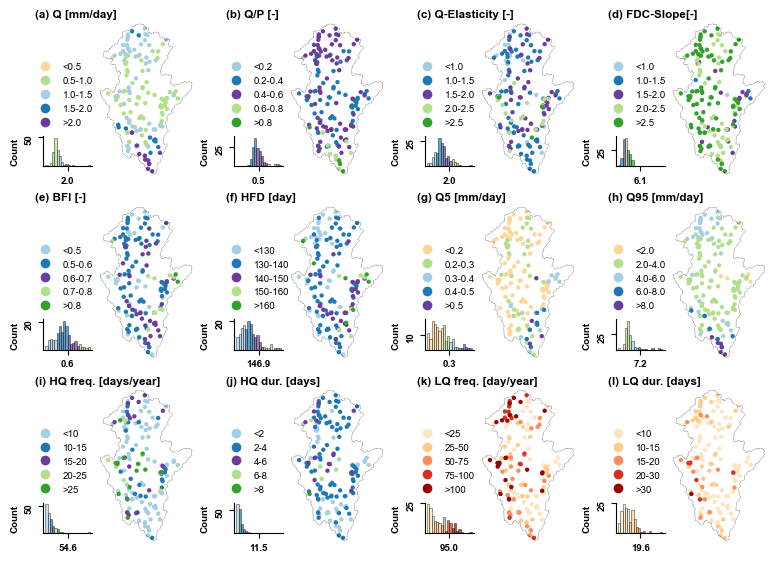

In [350]:
# List of variables
variable_list = ["q_mean"]
variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95", 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur']
#variable_list = ["q_95", "q_5"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold", pad=0)  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_signatures_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

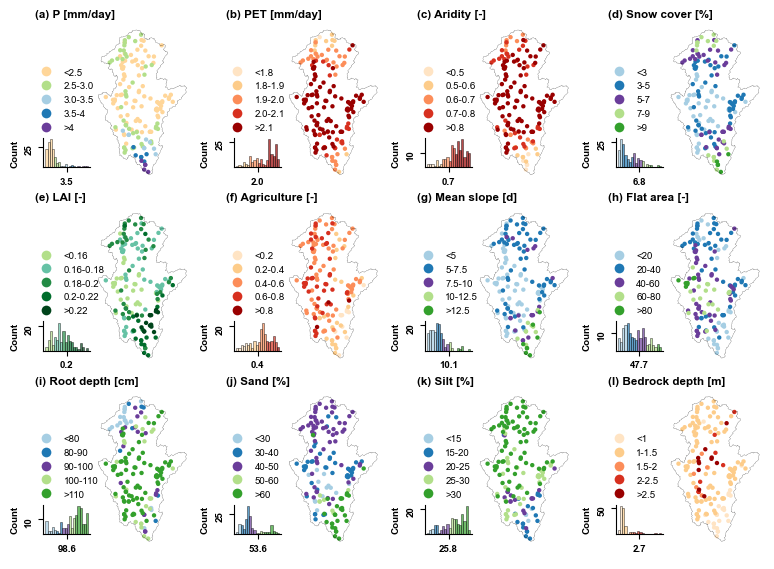

In [349]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', "sno_cov_mean", 'lai_mean', 'lulc_2006_agriculture', 'slp_dg_mean', "flat_area_fra", 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', "bedrk_dep"]
#variable_list = ['pet_mean']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_plots_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

# Import the rasters and geologies

In [129]:
#catchment_boundaries.set_index("basin_id", inplace=True)
# Reproject to EPSG:4326
catchment_boundaries = catchment_boundaries.to_crs(epsg=4326)

In [ ]:
# List of keys to filter
keys_to_filter = estreams_attributes_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_dfs:
        df = estreams_attributes_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)

network_estreams_filtered = combined_df.copy()
network_estreams_filtered


In [131]:
from shapely.geometry import Point
import pandas as pd

# Assuming network_estreams_filtered is your DataFrame with lat and lon columns
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_filtered['lon'], network_estreams_filtered['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_filtered, geometry=geometry, crs='EPSG:4326')


In [ ]:
GLiM = gpd.read_file(r'..\estreams_part_b\data\gis\raster\glim_moselle_wgs.shp')

attribute_field = 'xx'
GLiM_dissolved = GLiM.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_dissolved["class"] = GLiM_dissolved.index

GLiM_dissolved

In [ ]:
# Define the permeability columns dictionary
permeability_columns_glim = {
    "impermeable": ['ev', 'ig', 'pa', 'pb', 'va', 'vb', "wb"],
    "low": ['mt', 'pi', 'py', 'vi'],
    "medium": ['sc', 'sm'],
    "high": ['su', 'ss']
}

# Create a new column for reclassified permeability
def reclassify_glim_class(class_name):
    for permeability, classes in permeability_columns_glim.items():
        if class_name in classes:
            return permeability
    return None

GLiM_dissolved['permeability'] = GLiM_dissolved['class'].apply(reclassify_glim_class)

GLiM_dissolved

In [ ]:
geology_median = gpd.read_file(r'..\estreams_part_b\data\gis\raster\geology_median_moselle_wgs.shp')
geology_median

In [ ]:
geology_median = gpd.read_file(r'..\estreams_part_b\data\gis\raster\geology_median_moselle_wgs.shp')

attribute_field = 'LEVEL3'
geology_median_dissolved = geology_median.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_median_dissolved["class"] = geology_median_dissolved.index

geology_median_dissolved

In [ ]:
# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Conglomerates", "Conglomerates and sands", "Gravels", 
             "Sands", "Sandstones", "Sandstones and sands"],
    "medium": ["Conglomerates and clays", "Gneisses", "Limestones", 
               "Limestones and sands", "Sandstones and clays", "Sandstones and marls",
               "Limestones and clays", "Limestones and marls", "Marlstones and sands"],
    "low": ["Claystones and clays", "Marbles",
              "Marls", "Marlstones", "Marlstones and clays", 
              "Marlstones and marls", "Phyllites", "Schists",
              "Silts"],
    "impermeable": ["Plutonic rocks", "Volcanic rocks", 
                    "Inland water", "Snow field / ice field",
                    "Clays",  'Quartzites', "Shales"]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_median_dissolved['permeability'] = geology_median_dissolved['class'].apply(reclassify_geology_class)
geology_median_dissolved

In [ ]:
geology_high = gpd.read_file(r'..\estreams_part_b\data\lithology\moselle_hr_ff.shp')

attribute_field = 'Labels01'
geology_high_dissolved = geology_high.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_high_dissolved["class"] = geology_high_dissolved.index

# Set the CRS to WGS84
geology_high_dissolved = geology_high_dissolved.to_crs(epsg=4326)

geology_high_dissolved

In [ ]:
# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Alluvium", 'Coal', 'Conglomerate', 'Gravel and sand',
             'Sand', 'Sand and gravel', 'Sandstone and conglomerate', 'Sandstone'
        ],
    
    "medium": ['Limestone', 'Sandstone and marl', 'Sandstone and schist',
              'Sandstone, conglomerate and marl'],
    
    "lower": ['Arkose', 'Dolomite rock', 'Limestone and marl', 'Marl', 
             'Marl and dolomite', 'Marl and limestone', 'Marl and sandstone',
             'Sandstone and siltstone', 'Sandstone, siltstone and schist', 
              'Schist and sandstone', 'Silt',  'Silt and schist', 'Siltstone, sandstone and schist'
              ,"Siltstone"
             ],
    
    "impermeable": ['Cristallin basement', 'Plutonic rock',  'Quarzite',
                    'Schist','Volcanic rock' 
                   ]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_high_dissolved['permeability'] = geology_high_dissolved['class'].apply(reclassify_geology_class)
geology_high_dissolved

In [ ]:
geology_high_dissolved["class"].unique()

In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

# Path to the TIFF file
tiff_path = '..\estreams_part_b\data/elevation/moselle_srtm.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Check the current CRS
    current_crs = src.crs
    print(f'Current CRS: {current_crs}')

    # Define the target CRS (WGS84)
    dst_crs = 'EPSG:4326'  # WGS84

    # If the current CRS is not WGS84, reproject the image
    if current_crs != dst_crs:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an in-memory array to hold the reprojected data
        reprojected_image = rasterio.io.MemoryFile().open(**kwargs)

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(reprojected_image, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

        # Read the reprojected image
        elevation_wgs = reprojected_image.read(1)

        print(f'Image reprojected to WGS84 and stored in-memory.')
    else:
        # Read the original image if it is already in WGS84
        elevation_wgs = src.read(1)
        transform = src.transform
        print('Image is already in WGS84 CRS.')

# Calculate the extent
left, bottom, right, top = transform * (0, 0), transform * (elevation_wgs.shape[1], 0), transform * (elevation_wgs.shape[1], elevation_wgs.shape[0]), transform * (0, elevation_wgs.shape[0])
extent = (left[0], right[0], bottom[1], top[1])

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
ax.imshow(elevation_wgs, cmap='viridis', extent=extent)
ax.set_title('TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Path to the TIFF file
tiff_path = 'data/lulc/corine_2006_moselle.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    image_lulc = src.read(1)  # Read the first band
    transform_lulc = src.transform


# Reclassification function
def reclassify(value):
    if 111 <= value <= 124:
        return 1  # Urban
    elif 411 <= value < 600:
        return 2  # Water
    elif 315 <= value < 411:
        return 3  # Grass
    elif 200 <= value < 300:
        return 4  # Agriculture
    elif 300 <= value < 315:
        return 5  # Forest

    else:
        return 0  # Other

# Vectorize the reclassification function
reclassify_vectorized = np.vectorize(reclassify)

# Apply the reclassification
reclassified_image = reclassify_vectorized(image_lulc)

# Calculate the extent
left, bottom = transform_lulc * (0, 0)
right, top = transform_lulc * (image_lulc.shape[1], image_lulc.shape[0])
extent = (left, right, bottom, top)

# Define the color map
cmap = plt.get_cmap('viridis', 6)  # 6 discrete colors

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
cax = ax.imshow(reclassified_image, cmap=cmap, extent=extent, vmin=0, vmax=5)
ax.set_title('Reclassified TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a color bar
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3, 4, 5], orientation='vertical')
cbar.ax.set_yticklabels(['Other', 'Urban', 'Agriculture', 'Forest', 'Grass', "Water"])  # Set color bar labels

plt.show()


In [1068]:
# Select multiple geometries
shapefile = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
shapefile = gpd.GeoDataFrame({'geometry': shapefile}, crs='EPSG:4326')

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


sand_path = 'data/soil/topsoil/stu_eu_t_sand.tif'
silt_path = 'data/soil/topsoil/stu_eu_t_silt.tif'
gravel_path = 'data/soil/topsoil/stu_eu_t_gravel.tif'
clay_path = 'data/soil/topsoil/stu_eu_t_clay.tif'

# Function to read and clip a raster
def read_and_clip_raster(raster_path, shapefile):
    with rasterio.open(raster_path) as src:
        # Reproject the shapefile to match the raster CRS if necessary
        if shapefile.crs != src.crs:
            shapefile = shapefile.to_crs(src.crs)
        out_image, out_transform = mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        return out_image[0], out_transform, out_meta

# Read and clip the rasters
sand, transform_soil, meta = read_and_clip_raster(sand_path, shapefile)
silt, _, _ = read_and_clip_raster(silt_path, shapefile)
gravel, _, _ = read_and_clip_raster(gravel_path, shapefile)
clay, _, _ = read_and_clip_raster(clay_path, shapefile)

# Define the target CRS (WGS84)
dst_crs = 'EPSG:4326'

# Function to reproject a raster to WGS84
def reproject_raster(image, transform, src_crs, dst_crs):
    # Calculate the bounds of the source image
    left, bottom, right, top = rasterio.transform.array_bounds(image.shape[0], image.shape[1], transform)
    
    # Calculate the transformation to the destination CRS
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, image.shape[1], image.shape[0], left=left, bottom=bottom, right=right, top=top)
    
    # Create an array to hold the reprojected image
    dst_image = np.empty((dst_height, dst_width), dtype=image.dtype)
    
    reproject(
        source=image,
        destination=dst_image,
        src_transform=transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)
    
    return dst_image, dst_transform

# Reproject the clipped rasters to WGS84
sand_wgs84, transform_wgs84 = reproject_raster(sand, transform_soil, meta['crs'], dst_crs)
silt_wgs84, _ = reproject_raster(silt, transform_soil, meta['crs'], dst_crs)
gravel_wgs84, _ = reproject_raster(gravel, transform_soil, meta['crs'], dst_crs)
clay_wgs84, _ = reproject_raster(clay, transform_soil, meta['crs'], dst_crs)

# Stack the rasters to create a 3D array (bands, rows, cols)
stacked = np.stack([sand_wgs84, silt_wgs84, gravel_wgs84, clay_wgs84], axis=0)

# Find the index of the maximum value along the first axis (the bands)
majority_class = np.argmax(stacked, axis=0)

# Define a mapping from index to class name
class_mapping = {0: 'sand', 1: 'silt', 2: 'gravel', 3: 'clay'}

# Create a new array to store the class names
majority_class_names = np.vectorize(class_mapping.get)(majority_class)

sand_wgs84, transform_wgs84 = reproject_raster(sand, transform_soil, meta['crs'], dst_crs)

# Calculate the extent
left, bottom = transform_wgs84 * (0, 0)
right, top = transform_wgs84 * (sand_wgs84.shape[1], sand_wgs84.shape[0])
extent = (left, right, top, bottom)

# Reproject the shapefile to WGS84 if necessary
shapefile_wgs84 = shapefile.to_crs(dst_crs)

# Plot the majority class raster
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(sand_wgs84, cmap='cividis', extent=extent, origin='upper')

# Overlay the study area boundaries
shapefile_wgs84.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Add a color bar
cbar = fig.colorbar(cax, orientation='vertical')

# Set plot title and labels
ax.set_title('Majority Class Raster')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [ ]:
# Plot the majority class raster
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(silt_wgs84, cmap='cividis', extent=extent, origin='upper')

# Overlay the study area boundaries
shapefile_wgs84.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Add a color bar
cbar = fig.colorbar(cax, orientation='vertical')

# Set plot title and labels
ax.set_title('Majority Class Raster')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [1063]:
import rasterio
import numpy as np

# Define the paths to the raster files
sand_path = 'data/soil/topsoil/stu_eu_t_sand.tif'
silt_path = 'data/soil/topsoil/stu_eu_t_silt.tif'
gravel_path = 'data/soil/topsoil/stu_eu_t_gravel.tif'
clay_path = 'data/soil/topsoil/stu_eu_t_clay.tif'

# Read the raster files
with rasterio.open(sand_path) as sand_src:
    sand = sand_src.read(1)
    transform = sand_src.transform
    crs = sand_src.crs

with rasterio.open(silt_path) as silt_src:
    silt = silt_src.read(1)

with rasterio.open(gravel_path) as gravel_src:
    gravel = gravel_src.read(1)

with rasterio.open(clay_path) as clay_src:
    clay = clay_src.read(1)


In [1073]:
# Stack the rasters to create a 3D array (bands, rows, cols)
stacked = np.stack([sand, silt, gravel, clay], axis=0)

# Find the index of the maximum value along the first axis (the bands)
majority_class = np.argmax(stacked, axis=0)

# Define a mapping from index to class name
class_mapping = {0: 'sand', 1: 'silt', 2: 'gravel', 3: 'clay'}

# Create a new array to store the class names
majority_class_names = np.vectorize(class_mapping.get)(majority_class)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a colormap for the majority class
cmap = ListedColormap(['#FFD700', '#87CEEB', '#D2B48C', '#A0522D'])  # Customize colors for sand, silt, gravel, clay

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (sand.shape[1], sand.shape[0])
extent = (left, right, bottom, top)

# Plot the majority class raster
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(majority_class, cmap=cmap, extent=extent)

# Add a color bar
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3], orientation='vertical')
cbar.ax.set_yticklabels(['Sand', 'Silt', 'Gravel', 'Clay'])

# Set plot title and labels
ax.set_title('Majority Class Raster')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


### Read the time-series

In [55]:
# List of basin_ids
basin_ids = ["BEWA0087", "LU000001"]
basin_ids = estreams_attributes_dfs["DEBU1959"].index.tolist()
# Initialize an empty DataFrame to store the results
timeseries_pmean = pd.DataFrame()

# Loop through each basin_id, read the data, and extract p_mean
for basin_id in tqdm.tqdm(basin_ids):
    # Read the CSV file for the current basin_id
    data = pd.read_csv(f"data/EStreams/meteorology/meteorology/estreams_meteorology_{basin_id}.csv", index_col=0)
    
    # Extract the p_mean column and rename it to the basin_id
    datatimeseries_pmean = pd.DataFrame(data.p_mean).rename(columns={'p_mean': basin_id})
    
    # Concatenate the data into the main DataFrame
    timeseries_pmean = pd.concat([timeseries_pmean, datatimeseries_pmean], axis=1)
    
# Ensure the index of timeseries_pmean is datetime
timeseries_pmean.index = pd.to_datetime(timeseries_pmean.index)

In [ ]:
# List of basin_ids
basin_ids = ["BEWA0087", "LU000001"]
basin_ids = estreams_attributes_dfs["DEBU1959"].index.tolist()
# Initialize an empty DataFrame to store the results
timeseries_pet_mean = pd.DataFrame()

# Loop through each basin_id, read the data, and extract p_mean
for basin_id in tqdm.tqdm(basin_ids):
    # Read the CSV file for the current basin_id
    data = pd.read_csv(f"data/EStreams/meteorology/meteorology/estreams_meteorology_{basin_id}.csv", index_col=0)
    
    # Extract the p_mean column and rename it to the basin_id
    datatimeseries_pet_mean = pd.DataFrame(data.pet_mean).rename(columns={'pet_mean': basin_id})
    
    # Concatenate the data into the main DataFrame
    timeseries_pet_mean = pd.concat([timeseries_pet_mean, datatimeseries_pet_mean], axis=1)
    
# Ensure the index of timeseries_pmean is datetime
timeseries_pet_mean.index = pd.to_datetime(timeseries_pet_mean.index)

In [50]:
timeseries_discharge = pd.read_csv(r"data\EStreams\streamflow\estreams_timeseries_streamflow.csv", index_col=0)
timeseries_discharge.index = pd.to_datetime(timeseries_discharge.index)
timeseries_discharge.index.name = "date"


# Conversion factors
seconds_per_day = 86400
km2_to_m2 = 1_000_000

# Convert flow from m³/s to mm/day
timeseries_runoff = (timeseries_discharge * seconds_per_day * 1000) / (network_estreams.area_estreams * km2_to_m2)

### Plot the geology

In [1098]:
def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf):
    """
    Plot a variable on a subplot along with its legend and histogram.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]
    xmin_hist = color_mapping_list[variable][4]
    xmax_hist = color_mapping_list[variable][5]
    base_hist = color_mapping_list[variable][6]
    hist_bins = color_mapping_list[variable][7]

    ## Set the background color to white
    #ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    #gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    #ax.set_xlim(4.5, 8) 
    #ax.set_ylim(47.5, 50.5)  

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=30)

    # Turn off both x-axis and y-axis
    #ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    #hist_ax = ax.inset_axes([0.05, 0.1, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    #hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram within the inset axis
    #hist_ax.hist(hist_data, bins=hist_bins, color='gray', edgecolor='none', alpha=0.7, linewidth=0.1)
    
    # Hide the axis spines and ticks for the inset axis
    #hist_ax.spines['top'].set_visible(False)
    #hist_ax.spines['right'].set_visible(False)
    #hist_ax.spines['left'].set_visible(False)
    #hist_ax.spines['bottom'].set_visible(True)
    #hist_ax.set_facecolor('none')
    #hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Remove y-axis ticks and labels
    #hist_ax.set_yticks([])
    #hist_ax.set_xticklabels([])
    #hist_ax.set_yticklabels([])
    
    # Set custom x-axis ticks to show automatically but label only the middle one
    #x_ticks = hist_ax.get_xticks()
    #mid_tick = x_ticks[len(x_ticks) // 2]
    #hist_ax.set_xticks([mid_tick])  # Set only the middle tick
    #hist_ax.set_xticklabels([f'{mid_tick:.1f}'], fontsize=8)  # Label only the middle tick
    
    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title = "")

    # Adjust aspect ratio
    #ax.set_aspect('equal')

    # Hide spines for main plot
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=10, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='white')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 12})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 8  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title, legend_pos_x = -0, legend_pos_y=0.175):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((legend_pos_x, legend_pos_y))  # Adjust legend position

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')


# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['class'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['class'].map(color_mapping_geology)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='class', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5,
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Add a north arrow to both subplots
for ax in [ax1, ax2]:
    x, y, arrow_length = 0.05, 0.6, 0.075
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]")


# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]")

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


# Add a north arrow to both subplots
for ax in [ax1, ax2, ax3]:
    x, y, arrow_length = 0.05, 0.975, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2, ax3]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]")


# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]")

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "BFI [-]")

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5.53, 15.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')


# Plot the river
#river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('(c)', loc="left")
ax1.set_xlabel('')
ax1.set_ylabel('')


# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')



# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('(d)', loc="left")

for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)

# Adjust layout and remove space between subplots
plt.tight_layout()

fig.savefig(r'B_exploration\results\figs\fig_geologies.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

variable = "slope_sawicz"

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


# Add a north arrow to both subplots
for ax in [ax1, ax2, ax3]:
    x, y, arrow_length = 0.05, 0.975, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2, ax3]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "FDC slope [-]")


# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "FDC slope [-]")

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "FDC slope [-]")

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003249"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


# Add a north arrow to both subplots
for ax in [ax1, ax2, ax3]:
    x, y, arrow_length = 0.05, 0.975, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2, ax3]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR000159"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


## Add a north arrow to both subplots
#for ax in [ax1, ax2, ax3]:
#    x, y, arrow_length = 0.05, 0.975, 0.1
#    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#                arrowprops=dict(facecolor='black', width=5, headwidth=15),
#                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)
#
## Add a scale bar to both subplots
#scalebar_length = 10  # in kilometers
#x_scalebar = x_max - (x_max - x_min) * 0.1
#y_scalebar = y_min + (y_max - y_min) * 0.95
#for ax in [ax1, ax2, ax3]:
#    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
#    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = -0, legend_pos_y=0.5)

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


# Add a north arrow to both subplots
for ax in [ax1, ax2, ax3]:
    x, y, arrow_length = 0.05, 0.975, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2, ax3]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.75, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.75, legend_pos_y=0.5)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.75, legend_pos_y=0.5)

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["LU000017"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf)


# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology2.items()]
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax3.add_artist(geology_legend3)


# Add a north arrow to both subplots
for ax in [ax1, ax2, ax3]:
    x, y, arrow_length = 0.05, 0.975, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2, ax3]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

    
# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.0, legend_pos_y=0.35)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.0, legend_pos_y=0.35)

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title = "BFI [-]", legend_pos_x = 0.0, legend_pos_y=0.35)

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

variable = "q_mean"
# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color limits
vmin, vmax = 200, 1000  # Set your desired min and max values for the color map

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Display the image with specified color range
cax = ax1.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax1,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0)
cbar1 = fig.colorbar(cax, cax=axins, orientation='vertical')
cbar1.set_label('Elevation (m)', fontsize=8)  # Set the label for the color bar
cbar1.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title="Qmean [mm/day]")

# Define the custom colors for the 6 classes
custom_colors = ['white', 'lightcoral', 'cornflowerblue', 'yellowgreen', 'y', 'forestgreen']
cmaplulc = plt.matplotlib.colors.ListedColormap(custom_colors)

cax2 = ax2.imshow(reclassified_image, cmap=cmaplulc, extent=extent, vmin=0, vmax=5)

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax2,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0)

cbar = fig.colorbar(cax2, cax=axins, orientation='vertical')
cbar.set_label('Land use', fontsize=8)  # Set the label for the color bar
cbar.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set the custom tick labels for the discrete classes
cbar.ax.set_yticklabels(['Other', 'Urban', "Water", 'Grass', 'Agriculture', 'Forest'])

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)


sand_wgs84, transform_wgs84 = reproject_raster(sand, transform_soil, meta['crs'], dst_crs)

# Calculate the extent
left, bottom = transform_wgs84 * (0, 0)
right, top = transform_wgs84 * (sand_wgs84.shape[1], sand_wgs84.shape[0])
extent = (left, right, top, bottom)


# Display the image with specified color range
cax3 = ax3.imshow(sand_wgs84, cmap='BrBG', extent=extent, vmin=0, vmax=100)

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax3,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0)
cbar3 = fig.colorbar(cax3, cax=axins, orientation='vertical')
cbar3.set_label('Sand perc. (-)', fontsize=8)  # Set the label for the color bar
cbar3.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title="Qmean [mm/day]")

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title="Qmean [mm/day]")

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

variable = "baseflow_index"
# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color limits
vmin, vmax = 200, 1000  # Set your desired min and max values for the color map

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.6, 11.7))

# Display the image with specified color range
cax = ax1.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax1,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0)
cbar1 = fig.colorbar(cax, cax=axins, orientation='vertical')
cbar1.set_label('Elevation (m)', fontsize=8)  # Set the label for the color bar
cbar1.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax1, color_mapping, legend_labels, legend_title="BFI [-]")

# Define the custom colors for the 6 classes
custom_colors = ['white', 'lightcoral', 'cornflowerblue', 'yellowgreen', 'y', 'forestgreen']
cmaplulc = plt.matplotlib.colors.ListedColormap(custom_colors)

cax2 = ax2.imshow(reclassified_image, cmap=cmaplulc, extent=extent, vmin=0, vmax=5)

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax2,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0)

cbar = fig.colorbar(cax2, cax=axins, orientation='vertical')
cbar.set_label('Land use', fontsize=8)  # Set the label for the color bar
cbar.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set the custom tick labels for the discrete classes
cbar.ax.set_yticklabels(['Other', 'Urban', "Water", 'Grass', 'Agriculture', 'Forest'])

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)


sand_wgs84, transform_wgs84 = reproject_raster(sand, transform_soil, meta['crs'], dst_crs)

# Calculate the extent
left, bottom = transform_wgs84 * (0, 0)
right, top = transform_wgs84 * (sand_wgs84.shape[1], sand_wgs84.shape[0])
extent = (left, right, top, bottom)


# Display the image with specified color range
cax3 = ax3.imshow(sand_wgs84, cmap='BrBG', extent=extent, vmin=0, vmax=100)

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=2, label='')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=2, label='Basins')

# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf)

# Add a color bar (legend) inside the plot at the lower left
axins = inset_axes(ax3,
                   width="2.5%",  # width = 5% of parent_bbox width
                   height="15%",  # height = 30% of parent_bbox height
                   loc='lower right',
                   bbox_to_anchor=(-0.15, 0.05, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0)
cbar3 = fig.colorbar(cax3, cax=axins, orientation='vertical')
cbar3.set_label('Sand perc. (-)', fontsize=8)  # Set the label for the color bar
cbar3.ax.tick_params(labelsize=8)  # Adjust the size of the color bar ticks

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax3, color_mapping, legend_labels, legend_title="BFI [-]")

# Extract color mapping information from the color mapping list
legend_labels = color_mapping_list[variable][2]
color_mapping = color_mapping_list[variable][3]
add_circular_legend(ax2, color_mapping, legend_labels, legend_title="BFI [-]")

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_watershed_groups_from_dict(estreams_attributes_used, title_plot="Plot title", figsize=(8, 6), ax=None, 
                                    add_legend=False, size_symbol=2, limits_europe=True):
    """
    Plot watershed groups on a map using GeoPandas.

    Parameters:
        estreams_attributes_used (dict): A dictionary containing watershed groups dataframes.
        title_plot (str): Title of the plot.
        figsize (tuple): Figure size in inches (width, height).
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If None, a new figure and axes will be created.
        add_legend (bool): Whether to add a legend to the plot.
        size_symbol (int): Size of the symbols in the plot.
        limits_europe (bool): Whether to set the plot limits to Europe.

    Returns:
        None
    """
    
    # Load the world shapefile dataset provided by GeoPandas
    gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Set font properties using rcParams
    mpl.rcParams['font.family'] = 'arial'  # Change the font family
    mpl.rcParams['font.size'] = 8            # Change the font size
    mpl.rcParams['font.weight'] = 'normal'   # Change font weight
    mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Clear the subplot
    ax.clear()

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.1)

    # Calculate the bounds of the data if limits_europe is False
    if not limits_europe:
        all_lons = []
        all_lats = []
        for data in estreams_attributes_used.values():
            all_lons.extend(data['lon'])
            all_lats.extend(data['lat'])
        
        if all_lons and all_lats:
            min_lon, max_lon = min(all_lons), max(all_lons)
            min_lat, max_lat = min(all_lats), max(all_lats)
            margin = 0.05  # Add some margin to the bounds
            ax.set_xlim(min_lon - margin, max_lon + margin)
            ax.set_ylim(min_lat - margin, max_lat + margin)

    else:
        ax.set_xlim(5.5, 7.7)
        ax.set_ylim(47.5, 50.5)

    # Define markers for each watershed group
    markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

    # Plot the gauges for each desired watershed group
    colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
    i = 0
    for catchment, data in estreams_attributes_used.items():
        marker = markers[i % len(markers)]  # Choose marker cyclically
        color = colors[i]  # Choose color from the colormap
        ax.scatter(data['lon'], data['lat'], color=color, edgecolor='black',
                    linewidth=0.01, marker=marker, s=size_symbol, label=catchment)
        i += 1

    ax.set_aspect('equal')  # Adjust aspect ratio as needed
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()  # Turn off both x-axis and y-axis

    # Set title for the plot
    ax.set_title(title_plot)
    # Add legend (if needed)
    if add_legend:
        ax.legend()

    # Adjust layout
    plt.tight_layout()


# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)

In [459]:
def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf, add_legend = True, if_north_arrow=False):
    """
    Plot a variable on a subplot along with its legend and histogram.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]
    xmin_hist = color_mapping_list[variable][4]
    xmax_hist = color_mapping_list[variable][5]
    base_hist = color_mapping_list[variable][6]
    hist_bins = color_mapping_list[variable][7]

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8) 
    ax.set_ylim(47.5, 50.5)  

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=if_north_arrow, markersize_map=20)


    if add_legend == True:
        # Call the function to add a circular legend
        add_circular_legend(ax, color_mapping, legend_labels, legend_title = "")


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.05, 0.975, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=8,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 8  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((0.68, 0.2))  # Adjust legend position
    legend.set_title("Number of years [-]")

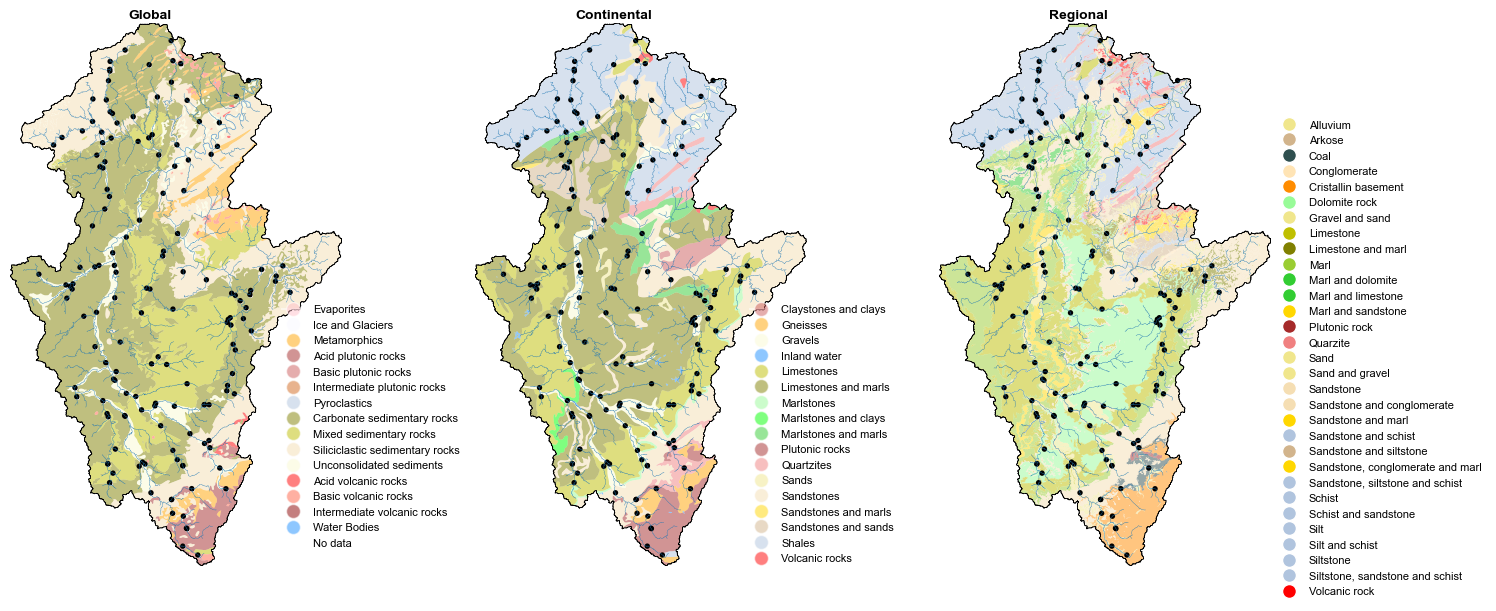

In [461]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')


# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define the first color mapping for GLiM_dissolved just for the legend (full names)
color_mapping_glim_legend = {
    'Evaporites': "pink",  # Evaporites
    'Ice and Glaciers': "ghostwhite",  # Ice and Glaciers
    'Metamorphics': "orange",  # Metamorphics
    'Acid plutonic rocks': "brown",  # Acid plutonic rocks
    'Basic plutonic rocks': "indianred",  # Basic plutonic rocks
    'Intermediate plutonic rocks': "chocolate",  # Intermediate plutonic rocks
    'Pyroclastics': "lightsteelblue",  # Pyroclastics
    'Carbonate sedimentary rocks': "olive",  # Carbonate sedimentary rocks
    'Mixed sedimentary rocks': "y",  # Mixed sedimentary rocks
    'Siliciclastic sedimentary rocks': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'Unconsolidated sediments': "#FAFAD2",  # Unconsolidated sediments
    'Acid volcanic rocks': "red",  # Acid volcanic rocks
    'Basic volcanic rocks': "tomato",  # Basic volcanic rocks
    'Intermediate volcanic rocks': "darkred",  # Intermediate volcanic rocks
    'Water Bodies': "#1E90FF",  # Water Bodies
    'No data': "white"   # Precambrian rocks
}


# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

# Corrected color mapping with same colors for classes with the same name
color_mapping_geology_high = {
    'Alluvium': '#F0E68C',                        # Khaki-like, slightly lighter than sand
    'Arkose': '#D2B48C',                          # Tan
    'Coal': '#2F4F4F',                            # Dark Slate Gray (for a coal-like appearance)
    'Conglomerate': '#FFE4B5',                    # Moccasin, similar to gravel
    'Cristallin basement': '#FF8C00',             # Dark Orange, similar to 'Gneisses'
    'Dolomite rock': '#98FB98',                   # PaleGreen
    'Gravel and sand': '#F0E68C',                 # Same as Sand, as they are closely related
    'Limestone': 'y',                             # Yellow, same as before
    'Limestone and marl': 'olive',                # Same as before
    'Marl': '#9ACD32',                            # YellowGreen, similar to PaleGreen but unique
    'Marl and dolomite': '#32CD32',               # LimeGreen, same as before
    'Marl and limestone': '#32CD32',              # Same as Marl and dolomite (same color logic)
    'Marl and sandstone': 'gold',                 # Same as Sandstones and marls
    'Plutonic rock': 'brown',                     # Same as Plutonic rocks
    'Quarzite': 'lightcoral',                     # Same as Quartzites
    'Sand': 'khaki',                              # Same as Sands
    'Sand and gravel': 'khaki',                   # Same as Sand
    'Sandstone': '#F5DEB3',                       # Burlywood, same as Sandstones
    'Sandstone and conglomerate': '#F5DEB3',      # Same as Sandstones (close relationship)
    'Sandstone and marl': 'gold',                 # Same as Sandstones and marls
    'Sandstone and schist': 'lightsteelblue',     # Similar to Shales but distinct
    'Sandstone and siltstone': 'tan',             # Tan-like, similar to Arkose but unique
    'Sandstone, conglomerate and marl': 'gold',   # Same as Sandstones and marls
    'Sandstone, siltstone and schist': 'lightsteelblue',  # Similar to Shales
    'Schist': 'lightsteelblue',                   # Same as Shales (similar behavior)
    'Schist and sandstone': 'lightsteelblue',     # Same as Schist
    'Silt': 'lightsteelblue',                     # Same as Schist and Shales
    'Silt and schist': 'lightsteelblue',          # Same as Schist
    'Siltstone': 'lightsteelblue',                # Same as Schist and Shales
    'Siltstone, sandstone and schist': 'lightsteelblue',  # Same as Schist
    'Volcanic rock': 'red'                        # Dark Red, same as Volcanic rocks
}



# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['class'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['class'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['class'].map(color_mapping_geology_high)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='class', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5, 
                                   label=cls) for cls, color in color_mapping_glim_legend.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='', 
                             bbox_to_anchor=(0.79, 0.5), frameon=False)

# Add the geological classes legend back to the first plot
#ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5,
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='', 
                             bbox_to_anchor=(0.8, 0.5), frameon=False)

# Add the geological classes legend back to the second plot
#ax2.add_artist(geology_legend2)
###########################################################################################################
# Plot the THIRD geology shapefile with different colors for each class
geology_high_dissolved.plot(column='class', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=1,
                                   label=cls) for cls, color in color_mapping_geology_high.items()]
# Add the legend to the third plot, keeping its current location
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='', 
                             bbox_to_anchor=(0.99, 0.84), frameon=False)


# Add the geological classes legend back to the second plot
#ax3.add_artist(geology_legend3)


## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]
#
## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.42, 1.025, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

fig.tight_layout()

fig.savefig(r'results\figs\fig_3geologies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Add your color mapping logic (omitted here for brevity)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, ax1 = plt.subplots(figsize=(5, 11.7))

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5,
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', 
                             bbox_to_anchor=(0.8, 0.5), frameon=False)

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', 
                             bbox_to_anchor=(0.8, 0.25), loc='center left', frameon=False)

# Add the legend to the figure with additional space for the legend
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)

text_to_subplots = ["Global"]
i = 0 
for ax in [ax1]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.5, 1.025, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

# Save the figure with extra space for the legend
fig.savefig(r'results\figs\fig_3geologies_2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Plot the three maps separated

In [ ]:
geology_high_dissolved["class"].unique()

In [ ]:
# Define the second color mapping for geology_median_dissolved
color_mapping_geology_high = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

In [ ]:
# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

FR_selected_gdf.plot()

In [ ]:
from shapely.geometry import box

data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

# Create subplots
fig, ax = plt.subplots(figsize=(4.5, 15))

# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
#gdf.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.1)


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
moselle_boundaries = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

## Define the color limits
#vmin, vmax = 200, 1000  # Set your desired min and max values for the color map
#
## Display the image with specified color range
#cax = ax.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Define the color classes (discrete intervals)
bounds = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.82, 0.29, 0.02, 0.15])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)
cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=8)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
cbar.ax.set_aspect('auto')

# Set the title and show the plot
ax.set_title('(a)', loc = "left")


# Plot the river
river_moselle.plot(ax=ax, linewidth=0.3)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.75, label='Sub-catchments')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

#plot_variable_subplot(ax, variable, network_estreams_filtered, color_mapping_list, gdf)
#legend_title = color_mapping_list[variable][0]

#ax.set_aspect('equal')       
#ax.set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing

# Adjust layout and remove space between subplots
plt.tight_layout()

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.025, x_max+0.025)
ax.set_ylim(y_min-0.025, y_max+0.025)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Sub-basins')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=2, label='River gauges')

# Add the legend with both items
legend = ax.legend(handles=[streamflow_marker, subcatchment_patch], loc='lower left', fontsize=8, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

# Adding some text
ax.text(5.5, 49.35, 'FR003283', fontsize=7, color='black', fontweight='bold')
ax.text(5.5, 49.60, 'LU000017', fontsize=7, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'DEBU1957', fontsize=7, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'FR000159', fontsize=7, color='black', fontweight='bold')
ax.text(5.65, 48.37, 'FR003249', fontsize=7, color='black', fontweight='bold')

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center')

fig.savefig(r'results\figs\fig_elevation.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'lower': 'wheat',
    'medium': 'tan',
    'higher': 'brown'
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 15))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')


# Plot the river
#river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('(b)', loc="left", fontsize=18)
ax1.set_xlabel('')
ax1.set_ylabel('')


# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('(c)', loc="left", fontsize=18)
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Very low", "Lower", "Medium", "Higher"]
# Create custom legend elements with circles for the second plot
#geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
#                                   label=cls) for cls, color in color_dict_legend.items()]
#geology_legend2 = ax1.legend(handles=geology_legend_elements2, title='Classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
#ax1.add_artist(geology_legend2)
# Adjust the figure to make space for the legend outside
#plt.subplots_adjust(right=0.5)  # Adjust 'right' to make more space for the legend







# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('(d)', loc="left", fontsize=18)

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.5, -0.025, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1
# Adjust layout and remove space between subplots
plt.tight_layout()

fig.savefig(r'results\figs\fig_geologies.png', dpi=300)


# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'very low': to_rgba('oldlace', 0.5),
    'lower': to_rgba('wheat', 0.5),
    'medium': to_rgba('tan', 0.5),
    'higher': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Create a figure with a small size to avoid extra empty space
fig, ax = plt.subplots(figsize=(2, 2))

# Remove the axis for a clean legend display
ax.axis('off')

# Add the legend outside the plot area with minimal space
legend = ax.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, 0.5))

# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Save the figure
fig.savefig(r'B_exploration\results\figs\fig_geologies_permeability.png', dpi=300)

# Display the plot with only the legend
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig = plt.figure(figsize=(9, 10))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Create the first figure in the first column
ax = fig.add_subplot(gs[0, 0])

from shapely.geometry import box

data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 10           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
#gdf.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.1)


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
moselle_boundaries = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

## Define the color limits
#vmin, vmax = 200, 1000  # Set your desired min and max values for the color map
#
## Display the image with specified color range
#cax = ax.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Define the color classes (discrete intervals)
bounds = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.58, 0.06, 0.015, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)
cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=8)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
cbar.ax.set_aspect('auto')

# Set the title and show the plot
ax.set_title('(a)', loc = "left")


# Plot the river
river_moselle.plot(ax=ax, linewidth=0.5)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax, facecolor='white', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.025, x_max+0.025)
ax.set_ylim(y_min-0.025, y_max+0.025)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Sub-basins')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=2, label='Streamflow gauges')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='River network')

# Add the legend with all items
legend = ax.legend(handles=[streamflow_marker, river_line, subcatchment_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Adding some text
ax.text(5.5, 49.35, 'FR003283', fontsize=9, color='black', fontweight='bold')
ax.text(5.5, 49.60, 'LU000017', fontsize=9, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'DEBU1957', fontsize=9, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'FR000159', fontsize=9, color='black', fontweight='bold')
ax.text(5.65, 48.37, 'FR003249', fontsize=9, color='black', fontweight='bold')

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center')

# ----------- Create subplots for the second figure (ax2, ax3, ax4) -----------
gs_sub = gs[0, 1].subgridspec(3, 1)  # Create space for 3 rows in the second column

### Second grid:
# First subplot
ax1 = fig.add_subplot(gs_sub[0, 0])

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'lower': 'wheat',
    'medium': 'tan',
    'higher': 'brown'
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('(b)', loc="left")
ax1.set_xlabel('')
ax1.set_ylabel('')



ax2 = fig.add_subplot(gs_sub[1, 0])
ax3 = fig.add_subplot(gs_sub[2, 0])

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
#mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Very low", "Lower", "Medium", "Higher"]
# Create custom legend elements with circles for the second plot
#geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
#                                   label=cls) for cls, color in color_dict_legend.items()]
#geology_legend2 = ax1.legend(handles=geology_legend_elements2, title='Classes', loc='lower right', frameon=False)

# Add the geological classes legend back to the second plot
#ax1.add_artist(geology_legend2)
# Adjust the figure to make space for the legend outside
#plt.subplots_adjust(right=0.5)  # Adjust 'right' to make more space for the legend

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
#river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.5, -0.025, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'very low': to_rgba('oldlace', 0.5),
    'low': to_rgba('wheat', 0.5),
    'medium': to_rgba('tan', 0.5),
    'high': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]


# Add the legend outside the plot area with minimal space
legend = ax2.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(1.3, 0.5))
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout(pad=0)

# Adjust layout and remove space between subplots
plt.tight_layout()

fig.savefig(r'results\figs\fig_study_area.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
river_dissolved = gpd.read_file('data/rivers/rivers_merit_dissolved.shp')
river_dissolved

In [ ]:
list_cats_list = ["ES000801", "ES000665","ES001243", "ES000196", "ES000116", "ES000194", "ES001080", "ES000316","ES000397","ES000339","ES000331", 
                  "GB000472", "GB000271", "GB000153","ITTO0361","ITVE0408","ITLC0146", "ITPI0183", "SE000102", "FI000668", "FI000585", "FI000557", 
                  "FI000226", "FI000137", "LTGR0031", "PL000936","PL000905", "PL000868", "PL000794","HR000048","HUGR0037", "AT000393", "PL000253", 
                  "PL000349", "PL000015","CZ000097","DEST1711", "DEBY0711","DEBY0724", "DEBY0697", "DEBU1953", "NL000008","CH000026", "FR002679", 
                  "FR004615", "NL000016", "BEVL0155", "FR000408", "FR000373", "FR000345", "FR001071", "FR003922", "FR003986", "FR002118", "FR001952",
                  "FR002029", "FR001604", "FR004221", "ES000738","ES001171", "ES001010", "PL001056", "PL000536", "HR000278", "CZ000236","DEST1707", 
                  "DEBE0155","FR002758","FR002462","FR001394", "FR000867", "FR004308", "DEBU1959"] 



list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']


# Select multiple geometries
cats_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[list_cats_list, "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
cats_selected_gdf = gpd.GeoDataFrame({'geometry': cats_selected}, crs='EPSG:4326')


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip


import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

estreams_attributes_used = estreams_attributes_dfs_all.copy()

# Create subplots
fig, ax = plt.subplots()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.05)

ax.set_xlim(-12, 31)
ax.set_ylim(35.5, 69)

# Define markers for each watershed group
#markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

#river_dissolved.plot(ax=ax, linewidth=0.25, alpha=0.5)

# Plot the gauges for each desired watershed group
colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
i = 0
for catchment, data in estreams_attributes_used.items():
    #marker = markers[i % len(markers)]  # Choose marker cyclically
    color = colors[i]  # Choose color from the colormap
    ax.scatter(data['lon'], data['lat'], color='darkgray', edgecolor='darkgray',linewidth=0.5,
            marker='o', s=0.25, label=catchment, alpha=1.0)
    i += 1
    # Overlay the study area boundaries

cats_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.4, label='')

# Select multiple geometries
cat_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, label='')


ax.set_aspect('equal')  # Adjust aspect ratio as needed
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.set_axis_off()  # Turn off both x-axis and y-axis
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)
ax.set_title("(a)", loc="left")

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=2.5, headwidth=8.5), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Adjust layout
plt.tight_layout()

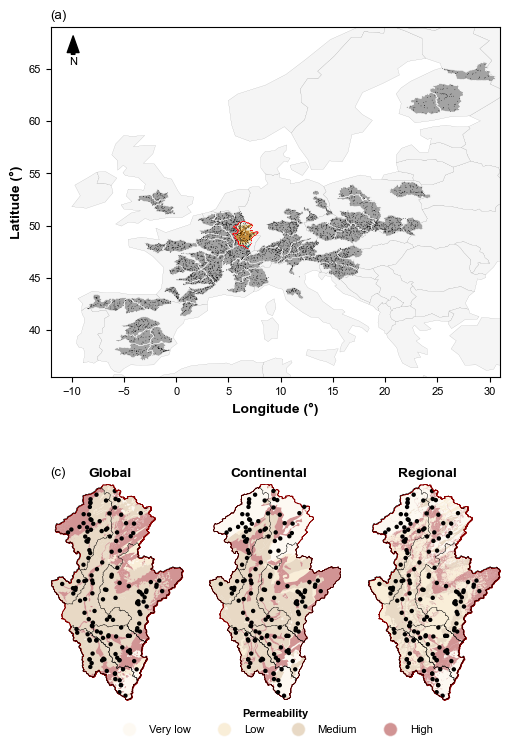

In [463]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig = plt.figure(figsize=(5, 8))
gs = fig.add_gridspec(2, 1)

# Create the first figure in the first column
ax = fig.add_subplot(gs[0, 0])

list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']


# Select multiple geometries
cats_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[list_cats_list, "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
cats_selected_gdf = gpd.GeoDataFrame({'geometry': cats_selected}, crs='EPSG:4326')


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 8            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

estreams_attributes_used = estreams_attributes_dfs_all.copy()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.05)

ax.set_xlim(-12, 31)
ax.set_ylim(35.5, 69)

# Define markers for each watershed group
#markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

#river_dissolved.plot(ax=ax, linewidth=0.25, alpha=0.5)

cats_selected_gdf.plot(ax=ax, facecolor='gray', edgecolor='white', linewidth=0.3, label='', alpha=0.7)

# Plot the gauges for each desired watershed group
colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors
i = 0
for catchment, data in estreams_attributes_used.items():
    #marker = markers[i % len(markers)]  # Choose marker cyclically
    color = colors[i]  # Choose color from the colormap
    ax.scatter(data['lon'], data['lat'], color='black', edgecolor='none',linewidth=0.0,
            marker='o', s=0.25, label=catchment, alpha=1.0, zorder = 1000)
    i += 1
    # Overlay the study area boundaries



# Select multiple geometries
cat_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.4, label='')


ax.set_aspect('equal')  # Adjust aspect ratio as needed
#ax.set_axis_off()  # Turn off both x-axis and y-axis
ax.set_xlabel('Longitude (°)', fontsize=10)
ax.set_ylabel('Latitude (°)', fontsize=10)
ax.set_title("(a)", loc="left")

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=2.5, headwidth=8.5), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Select multiple geometries
moselle_boundaries = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

## Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent, zorder = 100)

#---------------------------------------------------------------------------------------------------------------------------------------------
gs_sub = gs[1, 0].subgridspec(1, 3)  # Create space for 3 rows in the second column

### Second grid:
# First subplot
ax1 = fig.add_subplot(gs_sub[0, 0])

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'lower': 'wheat',
    'medium': 'tan',
    'higher': 'brown'
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('(c)', loc="left")
ax1.set_xlabel('')
ax1.set_ylabel('')



ax2 = fig.add_subplot(gs_sub[0, 1])
ax3 = fig.add_subplot(gs_sub[0, 2])

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Very low", "Lower", "Medium", "Higher"]

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='darkred', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Plot the river
#river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='darkred', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.45, 1.075, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Very low': to_rgba('oldlace', 0.5),
    'Low': to_rgba('wheat', 0.5),
    'Medium': to_rgba('tan', 0.5),
    'High': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = ax2.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.1), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout()


fig.savefig(r'results\figs\fig_study_area_a.png', dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from shapely.geometry import box
from matplotlib.colors import BoundaryNorm
from shapely.geometry import box


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(5, 8))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 10           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('white')

# Plot the shapefile with white facecolor and black boundaries
#gdf.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.1)


# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
moselle_boundaries = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

## Define the color limits
#vmin, vmax = 200, 1000  # Set your desired min and max values for the color map
#
## Display the image with specified color range
#cax = ax.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Define the color classes (discrete intervals)
bounds = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.85, 0.07, 0.015, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)
cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=8)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
cbar.ax.set_aspect('auto')

# Set the title and show the plot
ax.set_title('(b)', loc = "left")


# Plot the river
river_moselle.plot(ax=ax, linewidth=0.5)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax, facecolor='white', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.025, x_max+0.025)
ax.set_ylim(y_min-0.025, y_max+0.025)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Sub-basins')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=2, label='Streamflow gauges')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers')

# Add the legend with all items
legend = ax.legend(handles=[streamflow_marker, river_line, subcatchment_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=10)

# Adding some text
ax.text(5.5, 49.35, 'FR003283', fontsize=9, color='black', fontweight='bold')
ax.text(5.5, 49.60, 'LU000017', fontsize=9, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'DEBU1957', fontsize=9, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'FR000159', fontsize=9, color='black', fontweight='bold')
ax.text(5.65, 48.37, 'FR003249', fontsize=9, color='black', fontweight='bold')

# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center')



# Adjust the layout to remove extra space
plt.tight_layout(pad=0)


fig.savefig(r'results\figs\fig_study_areab.png', dpi=300)

# Show the plot
plt.show()

# Plot of the geologies

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# Color mappings as provided
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Function to plot a subplot with all the specifics
def plot_subplot(ax, FR_selected_gdf, geology_dissolved, color_mapping, network_estreams_gdf, river_moselle, mask):
    geology_dissolved['color'] = geology_dissolved['permeability'].map(color_mapping)
    # Plot the geology shapefile with different colors for each class
    geology_dissolved.plot(column='permeability', ax=ax, legend=False, 
                           categorical=True, color=geology_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
    
    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    
    # Plot the river
    river_moselle.plot(ax=ax, linewidth=0.5)
    
    # Plot the points from network_estreams_filtered
    #network_estreams_gdf.plot(ax=ax, color='black', markersize=10, edgecolor='white', linewidth=0.5)
    
    variable = "baseflow_index"
    # Plot the 'baseflow_index' with different colors
    plot_variable_subplot(ax, variable, network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


    # Plot the mask
    mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, zorder=100)
    
    # Set plot limits to the bounding box of the study area
    bounds = FR_selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

# Plotting
fig, axes = plt.subplots(5, 3, figsize=(5.7, 7.5))  # 5 rows, 3 columns

# List of sub-basins to loop through
sub_basins = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]
#sub_basins = ["FR003283"]

# Loop over each sub-basin to plot them
for i, sub_basin in enumerate(sub_basins):
    FR_selected_gdf = catchment_boundaries.set_index("basin_id").loc[[sub_basin], "geometry"]
    FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected_gdf}, crs='EPSG:4326')

    # Set plot limits to the bounding box of the selected study areas
    bounds = FR_selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area
    plot_extent = box(x_min - 0.1, y_min - 0.1, x_max + 0.1, y_max + 0.1)
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')
    combined_geometry = FR_selected_gdf.unary_union
    mask['geometry'] = mask.difference(combined_geometry)

    # Plot for each of the three columns
    plot_subplot(axes[i, 0], FR_selected_gdf, GLiM_dissolved, color_mapping_glim, network_estreams_gdf, river_moselle, mask)
    plot_subplot(axes[i, 1], FR_selected_gdf, geology_median_dissolved, color_mapping_geology, network_estreams_gdf, river_moselle, mask)
    plot_subplot(axes[i, 2], FR_selected_gdf, geology_high_dissolved, color_mapping_geology2, network_estreams_gdf, river_moselle, mask)

    ## Add a scale bar 
    scalebar_length = 10  # in kilometers
    x_scalebar = x_max - (x_max - x_min) * 0.1
    y_scalebar = y_min + (y_max - y_min) * 0.1
    axes[i, 2].plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2, zorder=200)
    axes[i, 2].text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='top', fontsize=8, 
                    zorder=200)



from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'very low': to_rgba('oldlace', 0.5),
    'lower': to_rgba('wheat', 0.5),
    'medium': to_rgba('tan', 0.5),
    'higher': to_rgba('brown', 0.5)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area, on the right side
legend = axes[4, 2].legend(handles=legend_elements, title='Permeability', loc='center left', frameon=False, 
                           bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)


# Update your legend labels and color mapping to align
legend_labels = ['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
color_mapping = ['#a6cee3', '#1f78b4', '#6a3d9a', '#b2df8a', '#33a02c']  # Ensure these match the labels


# Create custom legend elements with circles for the BFI legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                   for label, color in zip(legend_labels, color_mapping)]

# Add the legend to the plot with tight bounding box settings
axes[3, 2].legend(handles=legend_elements, title="BFI [-]", loc='center left', frameon=False, 
          bbox_to_anchor=(1.2, 0.5), borderaxespad=0.)

# Add vertical text on the right side of the figure
fig.text(-0.025, 0.1, 'DEBU1957', 
                  va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')

# Add vertical text on the right side of the figure
fig.text(-0.025, 0.3, 'LU000017', 
                  va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')
# Add vertical text on the right side of the figure
fig.text(-0.025, 0.5, 'FR000159', 
                  va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')

# Add vertical text on the right side of the figure
fig.text(-0.025, 0.7, 'FR003249', 
                  va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')

# Add vertical text on the right side of the figure
fig.text(-0.025, 0.9, 'FR003283', 
                  va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')

# Add horiz. text on the top side of the figure
fig.text(0.1, 1.01, 'Global level', 
                  va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')

# Add horiz. text on the top side of the figure
fig.text(0.4, 1.01, 'European level', 
                  va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')

# Add horiz. text on the top side of the figure
fig.text(0.7, 1.01, 'Country level', 
                  va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=0)

# Save the figure
fig.savefig(r"results\figs\combined_figure.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [445]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

# Reproject the data to UTM Zone 32N (EPSG:32632) for accurate distance measurements
utm_crs = "EPSG:32632"

# Reproject all layers to UTM Zone 32N
FR_selected_gdf_utm = FR_selected_gdf.to_crs(utm_crs)
GLiM_dissolved_utm = GLiM_dissolved.to_crs(utm_crs)
geology_median_dissolved_utm = geology_median_dissolved.to_crs(utm_crs)
geology_high_dissolved_utm = geology_high_dissolved.to_crs(utm_crs)
network_estreams_gdf_utm = network_estreams_gdf.to_crs(utm_crs)
river_moselle_utm = river_moselle.to_crs(utm_crs)

# Function to plot a subplot with all the specifics
def plot_subplot(ax, FR_selected_gdf, geology_dissolved, color_mapping, network_estreams_gdf, river_moselle, mask):
    geology_dissolved['color'] = geology_dissolved['permeability'].map(color_mapping)
    
    # Plot the geology shapefile with different colors for each class
    geology_dissolved.plot(column='permeability', ax=ax, legend=False, 
                           categorical=True, color=geology_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)
    
    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    
    # Plot the river
    river_moselle.plot(ax=ax, linewidth=0.5)
    
    # Plot the mask
    mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, zorder=100)
    
    # Set plot limits to the bounding box of the study area
    bounds = FR_selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

# Plotting
fig, axes = plt.subplots(5, 3, figsize=(5.7, 7.5))  # 5 rows, 3 columns
# Enable LaTeX for all text rendering in the plot
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'  # Set the font family to LaTeX's default serif

# List of sub-basins to loop through
sub_basins = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]

# Loop over each sub-basin to plot them
for i, sub_basin in enumerate(sub_basins):
    FR_selected_gdf = catchment_boundaries.set_index("basin_id").loc[[sub_basin], "geometry"]
    FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected_gdf}, crs='EPSG:4326').to_crs(utm_crs)  # Reproject to UTM

    # Set plot limits to the bounding box of the selected study areas
    bounds = FR_selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area in UTM coordinates
    plot_extent = box(x_min - 1200, y_min - 1200, x_max + 1200, y_max + 1200)  # 1000 meter buffer
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs=utm_crs)
    combined_geometry = FR_selected_gdf.unary_union
    mask['geometry'] = mask.difference(combined_geometry)

    # Plot for each of the three columns
    plot_subplot(axes[i, 0], FR_selected_gdf, GLiM_dissolved_utm, color_mapping_glim, network_estreams_gdf_utm, river_moselle_utm, mask)
    plot_subplot(axes[i, 1], FR_selected_gdf, geology_median_dissolved_utm, color_mapping_geology, network_estreams_gdf_utm, river_moselle_utm, mask)
    plot_subplot(axes[i, 2], FR_selected_gdf, geology_high_dissolved_utm, color_mapping_geology2, network_estreams_gdf_utm, river_moselle_utm, mask)

    # Plot a fixed 10 km scale bar (10 km = 10,000 meters)
    scalebar_length_meters = 10 * 1000  # 10 kilometers in meters
    
    # Define the start and end points for the scale bar (in UTM coordinates)
    x_scalebar_start = x_min + 2500  # Start the scale bar 5 km from the right edge
    y_scalebar = y_min + (y_max - y_min) * 0.05  # Slightly above the bottom of the plot
    
    # Plot the 10 km scale bar
    axes[i, 0].plot([x_scalebar_start, x_scalebar_start + scalebar_length_meters], [y_scalebar, y_scalebar], 
                    color='black', linewidth=2, zorder=200)
    
    # Add the scale bar text
    axes[i, 0].text(x_scalebar_start + scalebar_length_meters / 2, y_scalebar - (y_max - y_min) * 0.02, 
                    '10 km', ha='center', va='top', fontsize=8, zorder=200)

# Create custom legend elements for the 'Permeability' categories
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm

color_dict_legend = {
    'very low': to_rgba('oldlace', 0.5),
    'lower': to_rgba('wheat', 0.5),
    'medium': to_rgba('tan', 0.5),
    'higher': to_rgba('brown', 0.5)
}

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area, on the right side
legend = axes[4, 2].legend(handles=legend_elements, title=r"$\mathbf{Permeability}$", loc='center left', frameon=False, 
                           bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)


# Create custom legend elements with circles for the BFI legend
legend_labels = ['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
color_mapping = ['#a6cee3', '#1f78b4', '#6a3d9a', '#b2df8a', '#33a02c']  # Ensure these match the labels

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                   for label, color in zip(legend_labels, color_mapping)]

# Add the legend to the plot with bold BFI title
axes[3, 2].legend(handles=legend_elements, title=r"$\mathbf{BFI\ [-]}$", loc='center left', frameon=False, 
          bbox_to_anchor=(1.2, 0.5), borderaxespad=0.)


# Add vertical text on the right side of the figure
# Add vertical text annotations
fig.text(-0.025, 0.9, 'FR003283', va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')
fig.text(-0.025, 0.7, 'FR003249', va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')
fig.text(-0.025, 0.5, 'FR000159', va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')
fig.text(-0.025, 0.3, 'LU000017', va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')
fig.text(-0.025, 0.1, 'DEBU1957', va='center', ha='left', rotation=90, fontsize=8, fontweight='bold')

# Add horizontal text annotations
fig.text(0.1, 1.01, 'Global level', va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')
fig.text(0.4, 1.01, 'European level', va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')
fig.text(0.7, 1.01, 'Country level', va='center', ha='left', rotation=0, fontsize=8, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=0)

# Save the figure
fig.savefig(r"results\figs\combined_figure_utm.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Individuals

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sub_basin = "FR003249"

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[[sub_basin], "geometry"]
area_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.0, 2.0))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=1000)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
#ax1.set_title('(m)', loc="left", fontsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=10)

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(n)', loc="left", fontsize=8)
ax2.set_xlabel('')
ax2.set_ylabel('')

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)
# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=100)

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(o)', loc="left", fontsize=8)
ax3.set_xlabel('')
ax3.set_ylabel('')

for ax in [ax1, ax2, ax3]:

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    # Make the spines white
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.set_xticks([])
    ax.set_yticks([])
    # Optionally, comment out the legend and check if it causes the artifact
    ax.legend().remove()

# Add vertical text outside the axes
#ax3.text(1.05, 0.5, f'{sub_basin}', 
#        transform=ax3.transAxes, verticalalignment='center', fontsize=8, 
#        rotation=90,  # Rotate the text vertically
#        ha='left',
#        fontweight='bold')  # Adjust the horizontal alignment to position it outside

#ax2.set_xlim(x_min, x_max + 0.025)
#ax3.set_xlim(x_min, x_max + 0.025)

plt.tight_layout()

# Tighten layout and fix bounding box issue
fig.savefig(r"B_exploration\results\figs\fig_geo_"+sub_basin+".png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sub_basin = "FR003283"

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[[sub_basin], "geometry"]
area_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.0, 2.0))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=1000)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
#ax1.set_title('(m)', loc="left", fontsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=10)

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(n)', loc="left", fontsize=8)
ax2.set_xlabel('')
ax2.set_ylabel('')

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)
# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=100)

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(o)', loc="left", fontsize=8)
ax3.set_xlabel('')
ax3.set_ylabel('')

for ax in [ax1, ax2, ax3]:

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    # Make the spines white
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.set_xticks([])
    ax.set_yticks([])
    # Optionally, comment out the legend and check if it causes the artifact
    ax.legend().remove()

# Add vertical text outside the axes
#ax3.text(1.05, 0.5, f'{sub_basin}', 
#        transform=ax3.transAxes, verticalalignment='center', fontsize=8, 
#        rotation=90,  # Rotate the text vertically
#        ha='left',
#        fontweight='bold')  # Adjust the horizontal alignment to position it outside

plt.tight_layout()

# Tighten layout and fix bounding box issue
fig.savefig(r"B_exploration\results\figs\fig_geo_"+sub_basin+".png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sub_basin = "FR000159"

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[[sub_basin], "geometry"]
area_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.0, 2.0))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=1000)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
#ax1.set_title('(m)', loc="left", fontsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=10)

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(n)', loc="left", fontsize=8)
ax2.set_xlabel('')
ax2.set_ylabel('')

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)
# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=100)

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(o)', loc="left", fontsize=8)
ax3.set_xlabel('')
ax3.set_ylabel('')

for ax in [ax1, ax2, ax3]:

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    # Make the spines white
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.set_xticks([])
    ax.set_yticks([])
    # Optionally, comment out the legend and check if it causes the artifact
    ax.legend().remove()

# Add vertical text outside the axes
#ax3.text(1.05, 0.5, f'{sub_basin}', 
#        transform=ax3.transAxes, verticalalignment='center', fontsize=8, 
#        rotation=90,  # Rotate the text vertically
#        ha='left',
#        fontweight='bold')  # Adjust the horizontal alignment to position it outside

plt.tight_layout()
# Tighten layout and fix bounding box issue
fig.savefig(r"B_exploration\results\figs\fig_geo_"+sub_basin+".png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sub_basin = "LU000017"

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[[sub_basin], "geometry"]
area_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.0, 2.0))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=1000)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
#ax1.set_title('(m)', loc="left", fontsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=10)

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(n)', loc="left", fontsize=8)
ax2.set_xlabel('')
ax2.set_ylabel('')

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)
# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=100)

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(o)', loc="left", fontsize=8)
ax3.set_xlabel('')
ax3.set_ylabel('')

for ax in [ax1, ax2, ax3]:

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    # Make the spines white
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.set_xticks([])
    ax.set_yticks([])
    # Optionally, comment out the legend and check if it causes the artifact
    ax.legend().remove()

# Add vertical text outside the axes
#ax3.text(1.05, 0.5, f'{sub_basin}', 
#        transform=ax3.transAxes, verticalalignment='center', fontsize=8, 
#        rotation=90,  # Rotate the text vertically
#        ha='left',
#        fontweight='bold')  # Adjust the horizontal alignment to position it outside

plt.tight_layout()
# Tighten layout and fix bounding box issue
fig.savefig(r"B_exploration\results\figs\fig_geo_"+sub_basin+".png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sub_basin = "DEBU1957"

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[[sub_basin], "geometry"]
area_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'impermeable': "oldlace",  
    'lower': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)
geology_high_dissolved['color'] = geology_high_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4.0, 2.0))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax1, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=1000)

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
#ax1.set_title('(m)', loc="left", fontsize=8)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=10)

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax2, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)


# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(n)', loc="left", fontsize=8)
ax2.set_xlabel('')
ax2.set_ylabel('')

# Plot the third geology shapefile with different colors for each class
geology_high_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

variable = "baseflow_index"
# Plot the 'baseflow_index' with different colors
plot_variable_subplot(ax3, 'baseflow_index', network_estreams_gdf, color_mapping_list, FR_selected_gdf, add_legend = False)
# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins', zorder=100)

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(o)', loc="left", fontsize=8)
ax3.set_xlabel('')
ax3.set_ylabel('')

for ax in [ax1, ax2, ax3]:

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    # Make the spines white
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.set_xticks([])
    ax.set_yticks([])
    # Optionally, comment out the legend and check if it causes the artifact
    ax.legend().remove()

# Add vertical text outside the axes
#ax3.text(1.05, 0.5, f'{sub_basin}', 
#        transform=ax3.transAxes, verticalalignment='center', fontsize=8, 
#        rotation=90,  # Rotate the text vertically
#        ha='left',
#        fontweight='bold')  # Adjust the horizontal alignment to position it outside

plt.tight_layout()
# Tighten layout and fix bounding box issue
fig.savefig(r"B_exploration\results\figs\fig_geo_"+sub_basin+".png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# First set of legend labels and colors (for BFI)
legend_labels_bfi = ['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
color_mapping_bfi = ['#a6cee3', '#1f78b4', '#6a3d9a', '#b2df8a', '#33a02c']

# Second set of legend labels and colors (for Permeability)
color_dict_legend = {
    'very low': 'oldlace',
    'lower': 'wheat',
    'medium': 'tan',
    'higher': 'brown'
}

# Create custom legend elements for both BFI and Permeability
legend_elements_bfi = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                       for label, color in zip(legend_labels_bfi, color_mapping_bfi)]

legend_elements_perm = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                        for label, color in color_dict_legend.items()]

# Create a figure with two subplots for each legend
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(1, 2))  # Adjust size to fit both legends

# Remove the axes for clean legend display
ax1.axis('off')
ax2.axis('off')

# Add the text 'Legend' above the BFI legend
ax1.text(0.5, 1.2, 'Legend', ha='center', va='center', transform=ax1.transAxes, fontsize=8, fontweight="bold")


# Add the first legend (BFI) to the top axis
ax1.legend(handles=legend_elements_bfi, title="BFI [-]", loc='center', frameon=False)

# Add the second legend (Permeability) to the bottom axis
ax2.legend(handles=legend_elements_perm, title="Permeability", loc='center', frameon=False)

# Adjust layout to remove extra space
plt.tight_layout(pad=0)

# Save the figure with the legend, controlling tight bounding box
plt.savefig(r'B_exploration\results\figs\BFI_legend_only.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()

In [ ]:
df['baseflow_index'].hist()

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the column you want to compute the CV for

df =estreams_attributes_headwaters_moselle_dfs["FR003249"] 
cv = (df['baseflow_index'].std() / df['baseflow_index'].mean()) * 100

cv

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the column you want to compute the CV for

df =estreams_attributes_headwaters_moselle_dfs["FR000159"] 
cv = (df['baseflow_index'].std() / df['baseflow_index'].mean()) * 100

cv

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the column you want to compute the CV for

df =estreams_attributes_headwaters_moselle_dfs["LU000017"] 
cv = (df['baseflow_index'].std() / df['baseflow_index'].mean()) * 100

cv

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the column you want to compute the CV for

df =estreams_attributes_headwaters_moselle_dfs["DEBU1957"] 
cv = (df['baseflow_index'].std() / df['baseflow_index'].mean()) * 100

cv

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the column you want to compute the CV for

df =estreams_attributes_headwaters_moselle_dfs["FR003283"] 
cv = (df['baseflow_index'].std() / df['baseflow_index'].mean()) * 100

cv

In [ ]:
timeseries_runoff.loc["2004-10":"2006-09", "FR003250"].plot(label='FR003250', color='blue', linewidth=1, linestyle='-')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003280"].plot(label='FR003280', color='green', linewidth=1, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "FR000173"].plot(label='FR000173', color='blue', linewidth=1, linestyle='-')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003255"].plot(label='FR003255', color='green', linewidth=1, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "FR003263"].plot(label='FR003250', color='blue', linewidth=1, linestyle='-')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2000-10":"2001-09", "DERP2031"].plot(label='DERP2031', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2000-10":"2001-09", "DERP2030"].plot(label='DERP2030', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2000-10":"2001-09", "FR000151"].plot(label='FR000151', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2000-10":"2001-09", "FR003259"].plot(label='FR003259', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2010-10":"2011-09", "BEWA0087"].plot(label='BEWA0087', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2010-10":"2011-09", "LU000001"].plot(label='LU000001', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
# Create the plot with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the runoff and precipitation for FR000159
ax1.plot(timeseries_runoff.loc["2002-10":"2003-09", "BEWA0087"], label='Runoff BEWA0087', color='red', linewidth=0.5, linestyle='--')
ax1.set_title('Runoff and Precipitation Time Series (2002-2003) - FR000124')
ax1.set_ylabel('Runoff (mm/day)')
ax1.set_xlabel('Date')
ax1.grid(visible=True)

# Create a secondary y-axis for precipitation
ax1_secondary = ax1.twinx()
ax1_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax1_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "BEWA0087"], 
                  label='Precipitation BEWA0087', color='blue', alpha=0.5, width=1)
ax1_secondary.set_ylabel('Precipitation (mm/day)')
ax1_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
bars, labels2 = ax1_secondary.get_legend_handles_labels()
ax1.legend(lines + bars, labels + labels2, loc='upper left')

# Plot the runoff and precipitation for FR003249
ax2.plot(timeseries_runoff.loc["2002-10":"2003-09", "LU000001"], label='Runoff LU000001', color='black', linewidth=1, linestyle='-')
ax2.set_title('Runoff and Precipitation Time Series (2002-2003) - LU000001')
ax2.set_ylabel('Runoff (mm/day)')
ax2.set_xlabel('Date')
ax2.grid(visible=True)

# Create a secondary y-axis for precipitation
ax2_secondary = ax2.twinx()
ax2_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax2_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "LU000001"], 
                  label='Precipitation LU000001', color='blue', alpha=0.5, width=1)
ax2_secondary.set_ylabel('Precipitation (mm/day)')

ax2_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax2.get_legend_handles_labels()
bars, labels2 = ax2_secondary.get_legend_handles_labels()
ax2.legend(lines + bars, labels + labels2, loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
timeseries_pmean.loc["2002-10":"2003-09", "BEWA0087"].plot()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["LU000017"].T.head(50)

In [ ]:
estreams_attributes_headwaters_moselle_dfs["LU000017"][estreams_attributes_headwaters_moselle_dfs["LU000017"].lulc_2006_agriculture < 0.5]

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003249"].columns

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["FR003249"].loc[:, ["baseflow_index", "imper_mos_ff"]]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data["imper_mos_ff"], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of Low Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of Low Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["FR003249"].loc[:, ["baseflow_index", "perc_low_perm"]]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data["perc_low_perm"], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of Low Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of Low Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["DEBU1957"].loc[:, ["baseflow_index", 'perm_high_ff2']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['perm_high_ff2'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of High Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of High Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["DEBU1957"].loc[:, ["baseflow_index", 'perc_high_perm']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['perc_high_perm'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of High Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of High Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["LU000017"].loc[:, ["baseflow_index", 'perm_high_ff2']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['perm_high_ff2'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of High Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of High Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR000159"].columns[50:]

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["FR000159"].loc[:, ["baseflow_index", 'perc_medium_perm']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['perc_medium_perm'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of High Permeability')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of High Permeability')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["LU000017"].columns[50:]

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["FR003249"].loc[:, ["baseflow_index", 'flat_area_fra']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['flat_area_fra'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of flat_area_fra')
plt.xlabel('Baseflow Index')
plt.ylabel('Percentage of flat_area_fra')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["LU000017"].loc[:, ["baseflow_index", 'flat_area_fra']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['flat_area_fra'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of flat_area_fra')
plt.xlabel('flat_area_fra')
plt.ylabel('Baseflow Index')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select the data
data = estreams_attributes_headwaters_moselle_dfs["FR000159"].loc[:, ["baseflow_index", 'flat_area_fra']]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['flat_area_fra'], data["baseflow_index"], alpha=0.5, c='blue', edgecolors='w', linewidth=0.5)

# Set plot title and labels
plt.title('Scatter Plot of Baseflow Index vs. Percentage of flat_area_fra')
plt.xlabel('flat_area_fra')
plt.ylabel('Baseflow Index')

# Add grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
estreams_attributes_headwaters_moselle_dfs.keys()

In [ ]:
data.corr()

The problem here is that we see a lot of points with 0 perc_low_perm. There is a high correlation for only the first points, where in fact there is some perc_low_perm different to 0. 

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003249"].loc[:, ["baseflow_index", "perc_low_perm"]]

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Select multiple geometries
FR_selected = catchment_boundaries.set_index("basin_id", inplace=False).loc[["LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['class'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['class'].map(color_mapping_geology)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.6, 11.7))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='class', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Add a north arrow to both subplots
for ax in [ax1, ax2]:
    x, y, arrow_length = 0.05, 0.6, 0.075
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'impermeable': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Add a column for colors based on the class
GLiM_dissolved['color'] = GLiM_dissolved['permeability'].map(color_mapping_glim)
geology_median_dissolved['color'] = geology_median_dissolved['permeability'].map(color_mapping_geology)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first geology shapefile with different colors for each class
GLiM_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_glim.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the first plot
ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, 
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='Geological classes', loc='lower left', frameon=False)

# Add the geological classes legend back to the second plot
ax2.add_artist(geology_legend2)

# Add a north arrow to both subplots
for ax in [ax1, ax2]:
    x, y, arrow_length = 0.05, 0.6, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar to both subplots
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
for ax in [ax1, ax2]:
    ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
    ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=8)

# Show the plot
plt.show()

In [ ]:
geology_median_dissolved

## Tables

In [470]:
estreams_attributes_dfs["DEBU1959"].columns[0:50]

Index(['gauge_id', 'gauge_name', 'gauge_country', 'gauge_provider', 'river',
       'lon_snap', 'lat_snap', 'lon', 'lat', 'elevation', 'area_official',
       'area_estreams', 'area_flag', 'area_rel', 'start_date', 'end_date',
       'num_years', 'num_months', 'num_days', 'num_continuous_days',
       'num_days_gaps', 'num_days_reliable', 'num_days_noflag',
       'num_days_suspect', 'gauge_flag', 'duplicated_suspect',
       'watershed_group', 'gauges_upstream', 'nested_catchments', 'q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur'],
      dtype='object')

In [476]:
estreams_attributes_dfs_moselle = estreams_attributes_dfs["DEBU1959"][["area_estreams", 'lon', 'lat', 'start_date', 'end_date',
       'num_years', "gauges_upstream"]]
estreams_attributes_dfs_moselle.to_csv("results/table_modelle.csv")

In [ ]:
timeseries_runoff.loc["2004-10":"2005-09", "BEWA0087"].plot(label='BEWA0087', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2004-10":"2005-09", "BEWA0067"].plot(label='BEWA0067', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2004-10":"2005-09", "BEWA0087"].plot(label='BEWA0087', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2004-10":"2005-09", "LU000001"].plot(label='LU000001', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "DEBU1957"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "LU000017"].plot(label='LU000017', color='green', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "LU000017"].plot(label='LU000017', color='green', linewidth=0.5, linestyle='--')
DEBU1957


# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "LU000017"].plot(label='LU000017', color='green', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "DEBU1957"].plot(label='LU000017', color='orange', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "FR003283"].plot(label='LU000017', color='purple', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
# Create the plot with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the runoff and precipitation for FR000159
ax1.plot(timeseries_runoff.loc["2002-10":"2003-09", "FR000124"], label='Runoff FR000159', color='red', linewidth=0.5, linestyle='--')
ax1.set_title('Runoff and Precipitation Time Series (2002-2003) - FR000124')
ax1.set_ylabel('Runoff (mm/day)')
ax1.set_xlabel('Date')
ax1.grid(visible=True)

# Create a secondary y-axis for precipitation
ax1_secondary = ax1.twinx()
ax1_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax1_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "FR000124"], 
                  label='Precipitation FR000124', color='blue', alpha=0.5, width=1)
ax1_secondary.set_ylabel('Precipitation (mm/day)')
ax1_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
bars, labels2 = ax1_secondary.get_legend_handles_labels()
ax1.legend(lines + bars, labels + labels2, loc='upper left')

# Plot the runoff and precipitation for FR003249
ax2.plot(timeseries_runoff.loc["2002-10":"2003-09", "FR000137"], label='Runoff FR000137', color='black', linewidth=1, linestyle='-')
ax2.set_title('Runoff and Precipitation Time Series (2002-2003) - FR000137')
ax2.set_ylabel('Runoff (mm/day)')
ax2.set_xlabel('Date')
ax2.grid(visible=True)

# Create a secondary y-axis for precipitation
ax2_secondary = ax2.twinx()
ax2_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax2_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "FR000137"], 
                  label='Precipitation FR000137', color='blue', alpha=0.5, width=1)
ax2_secondary.set_ylabel('Precipitation (mm/day)')

ax2_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax2.get_legend_handles_labels()
bars, labels2 = ax2_secondary.get_legend_handles_labels()
ax2.legend(lines + bars, labels + labels2, loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create the plot with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the runoff and precipitation for FR000159
ax1.plot(timeseries_runoff.loc["2002-10":"2003-09", "FR000124"], label='Runoff FR000159', color='red', linewidth=0.5, linestyle='--')
ax1.set_title('Runoff and Precipitation Time Series (2002-2003) - FR000124')
ax1.set_ylabel('Runoff (mm/day)')
ax1.set_xlabel('Date')
ax1.grid(visible=True)

# Create a secondary y-axis for precipitation
ax1_secondary = ax1.twinx()
ax1_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax1_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "FR000124"], 
                  label='Precipitation FR000124', color='blue', alpha=0.5, width=1)
ax1_secondary.set_ylabel('Precipitation (mm/day)')
ax1_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
bars, labels2 = ax1_secondary.get_legend_handles_labels()
ax1.legend(lines + bars, labels + labels2, loc='upper left')

# Plot the runoff and precipitation for FR003249
ax2.plot(timeseries_runoff.loc["2002-10":"2003-09", "FR000137"], label='Runoff FR000137', color='black', linewidth=1, linestyle='-')
ax2.set_title('Runoff and Precipitation Time Series (2002-2003) - FR000137')
ax2.set_ylabel('Runoff (mm/day)')
ax2.set_xlabel('Date')
ax2.grid(visible=True)

# Create a secondary y-axis for precipitation
ax2_secondary = ax2.twinx()
ax2_secondary.invert_yaxis()  # Invert the y-axis for precipitation
ax2_secondary.bar(timeseries_pmean.loc["2002-10":"2003-09"].index, timeseries_pmean.loc["2002-10":"2003-09", "FR000137"], 
                  label='Precipitation FR000137', color='blue', alpha=0.5, width=1)
ax2_secondary.set_ylabel('Precipitation (mm/day)')

ax2_secondary.set_ylim(40, 0)

# Add legends for both y-axes
lines, labels = ax2.get_legend_handles_labels()
bars, labels2 = ax2_secondary.get_legend_handles_labels()
ax2.legend(lines + bars, labels + labels2, loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003249"].iloc[:, 0:20]

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR000124"].plot(label='FR000124', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000137"].plot(label='FR000137', color='red', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "FR000132"].plot(label='FR000132', color='green', linewidth=0.5, linestyle='--')



# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')


In [ ]:
nested_cats_filtered_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

# Function to plot selected keys and columns from the dictionary
def plot_selected_keys_columns(dictionary, keys, columns, num_subplots_columns=2):
    num_columns = len(columns)
    num_subplots = num_columns
    num_subplots_rows = math.ceil(num_subplots / num_subplots_columns)

    fig, axs = plt.subplots(num_subplots_rows, num_subplots_columns, figsize=(8.3, 5.7))
    axs = axs.flatten()

    for idx, column in enumerate(columns):
        data_to_plot = [dictionary[key][column] for key in keys]
        
        # Create a DataFrame for seaborn
        plot_data = pd.DataFrame(data_to_plot).T
        plot_data.columns = keys
        
        # Melt the DataFrame for seaborn
        plot_data = plot_data.melt(var_name='Key', value_name=column)
        
        ax = axs[idx]
        sns.boxplot(x='Key', y=column, data=plot_data, ax=ax, palette='Set3')
        #ax.set_title(f'{column}')
        ax.set_xlabel('')
        ax.set_ylabel(column)

    # Remove empty subplots
    for j in range(len(columns), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming estreams_attributes_headwaters_moselle_dfs is your dictionary
# and it contains DataFrames with columns to be plotted

keys_to_plot = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]
columns_to_plot = ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur']  # Add the columns you want to plot

plot_selected_keys_columns(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, columns_to_plot)

In [ ]:
keys_to_plot = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]
columns_to_plot = ['p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur',
       'lp_freq', 'lp_dur']  # Add the columns you want to plot

plot_selected_keys_columns(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, columns_to_plot)

In [ ]:
keys_to_plot = ["FR003249", "FR000159", "LU000017", "DEBU1957"]
columns_to_plot = ['ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'bedrk_dep']  # Add the columns you want to plot

plot_selected_keys_columns(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, columns_to_plot)

In [ ]:
keys_to_plot = ["FR003249", "FR000159", "LU000017", "DEBU1957"]
columns_to_plot = ['lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', "lakes_num"]  # Add the columns you want to plot

plot_selected_keys_columns(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, columns_to_plot)

In [ ]:
estreams_attributes_headwaters_moselle_dfs["FR003283"].columns

In [ ]:
keys_to_plot = ["FR003249", "FR000159", "LU000017", "DEBU1957"]
columns_to_plot = ['root_dep_mean', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'perm_high_ff2',
       'perm_medium_ff2', 'perm_lower_ff2', 'perm_impermeable_ff2']  # Add the columns you want to plot

plot_selected_keys_columns(estreams_attributes_headwaters_moselle_dfs, keys_to_plot, columns_to_plot)

In [ ]:
estreams_attributes_headwaters_moselle_dfs["LU000017"].columns

In [ ]:
timeseries_runoff.loc["2001-10":"2002-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2001-10":"2002-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2001-10":"2002-09", "LU000017"].plot(label='LU000017', color='green', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2001-10":"2002-09", "DEBU1957"].plot(label='DEBU1957', color='purple', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2001-10":"2002-09", "FR003283"].plot(label='FR003283', color='orange', linewidth=0.5, linestyle='--')


# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002-10":"2003-09", "FR003249"].plot(label='FR003249', color='blue', linewidth=1, linestyle='-')
timeseries_runoff.loc["2002-10":"2003-09", "FR000159"].plot(label='FR000159', color='red', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "LU000017"].plot(label='LU000017', color='green', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "DEBU1957"].plot(label='DEBU1957', color='purple', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002-10":"2003-09", "FR003283"].plot(label='FR003283', color='orange', linewidth=0.5, linestyle='--')


# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2002":"2003", ["FR003249", "FR000159", "LU000017"]].corr()

In [ ]:
timeseries_runoff.loc["2001":"2003", "FR003249"].plot(label='FR003249', color='blue', linewidth=0.5, linestyle='-')
timeseries_runoff.loc["2002":"2003", "FR000159"].plot(label='FR000159', color='green', linewidth=0.5, linestyle='--')
timeseries_runoff.loc["2002":"2003", "LU000017"].plot(label='LU000017', color='red', linewidth=0.5, linestyle='-.')
timeseries_runoff.loc["2002":"2003", "DEBU1957"].plot(label='DEBU1957', color='purple', linewidth=0.5, linestyle=':')
timeseries_runoff.loc["2002":"2003", "FR003283"].plot(label='FR003283', color='orange', linewidth=0.5, linestyle='-')

# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.xlabel('Date')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()

In [ ]:
timeseries_runoff.loc["2018":"2018", "FR003249"].plot(label='FR003249', color='blue', linewidth=0.5, linestyle='-')
timeseries_runoff.loc["2018":"2018", "FR000159"].plot(label='FR000159', color='green', linewidth=0.5, linestyle='--')
# Set plot title and labels
plt.title('Runoff Time Series (2002-2003)')
plt.xlabel('Date')
plt.ylabel('Runoff (mm/day)')

# Add grid
plt.grid(visible=True)

# Add legend
plt.legend(title='Catchments')

# Show the plot
plt.show()


## Gannt plots

In [ ]:
estreams_attributes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
estreams_attributes_gannt = combined_df.iloc[0:, :]

estreams_attributes_gannt["stream_id"] = estreams_attributes_gannt.index

# Convert start_date and end_date to datetime
estreams_attributes_gannt['start_date'] = pd.to_datetime(estreams_attributes_gannt['start_date'])
estreams_attributes_gannt['end_date'] = pd.to_datetime(estreams_attributes_gannt['end_date'])

# Calculate the duration
estreams_attributes_gannt['duration'] = estreams_attributes_gannt['end_date'] - estreams_attributes_gannt['start_date']

# Plotting the Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar for each stream
for i, row in estreams_attributes_gannt.iterrows():
    ax.barh(row['stream_id'], row['duration'].days, left=row['start_date'], color='skyblue')

# Set labels
ax.set_xlabel('Date')
ax.set_ylabel('')
# Remove y-axis labels
ax.yaxis.set_ticks([])
# Set the x-axis limits
ax.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2022-12-31'))


# Format the x-axis to show dates properly
ax.xaxis_date()

# Rotate date labels for better readability
plt.xticks(rotation=45)

plt.show()

In [ ]:
estreams_attributes_gannt

In [ ]:
timeseries_runoff.loc[:, "FR000159"].plot()

In [ ]:
timeseries_runoff.loc[:, "FR000140"].plot()

In [ ]:
combined_df[combined_df.lulc_2006_agriculture > 0].loc[:, ["baseflow_index", 'semiperm_mos_ff', 'imper_mos_ff', "perm_mos_ff"]].corr(method="pearson")

In [ ]:
combined_df[combined_df.lulc_2006_agriculture < 0.5].loc[:, ["baseflow_index", 'semiperm_mos_ff', 'imper_mos_ff', "perm_mos_ff", 'perc_imp',
       'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'perm_high_euro',
       'perm_medium_euro', 'perm_lower_euro', 'perm_impermeable_euro']].corr(method="pearson")

In [ ]:
combined_df.columns[50:]

In [ ]:
# Read the text file into a DataFrame
example_SU_EP = pd.read_csv(r'data\SU_PET_P\example_SU_EP.txt', delimiter='\t')
example_SU_EP

In [ ]:
timeseries_pmean

In [ ]:
timeseries_pet_mean


In [ ]:
df = pd.DataFrame()
df[["P_Ettelbruck", "E_act"]] = example_SU_EP[["P_Ettelbruck", "E_act"]]

# Initialize S_dem(t-1) and S_dem(t)
df['S_dem(t-1)'] = 0
df['S_dem(t)'] = 0

# Set the constant V1
deltaT = 1.0  # Replace this with the appropriate value if different

# Compute S_dem(t-1) and S_dem(t)
for i in range(len(df)):
    if i == 0:
        df.at[i, 'S_dem(t-1)'] = 0
        df.at[i, 'S_dem(t)'] = max(0, df.at[i, 'S_dem(t-1)'] + deltaT*(df.at[i, 'E_act'] - df.at[i, 'P_Ettelbruck']))
    else:
        df.at[i, 'S_dem(t-1)'] = df.at[i-1, 'S_dem(t)']
        df.at[i, 'S_dem(t)'] = max(0, df.at[i, 'S_dem(t-1)'] + deltaT*(df.at[i, 'E_act'] - df.at[i, 'P_Ettelbruck']))
df

In [ ]:
df["S_dem(t)"].max()

In [ ]:
df.at[2, 'S_dem(t-1)']

In [132]:
df = pd.DataFrame()
df["P_Ettelbruck"] = timeseries_pmean["DEBU1959"]
df["E_act"] = timeseries_pet_mean["DEBU1959"]

# Initialize S_dem(t-1) and S_dem(t)
df['S_dem(t-1)'] = 0
df['S_dem(t)'] = 0

# Set the constant V1
deltaT = 1.0  # Replace this with the appropriate value if different

df = df.iloc[0:3650, :]
df.reset_index(inplace=True)

# Compute S_dem(t-1) and S_dem(t)
for i in tqdm.tqdm(range(len(df))):
    if i == 0:
        df.at[i, 'S_dem(t-1)'] = 0
        df.at[i, 'S_dem(t)'] = max(0, df.at[i, 'S_dem(t-1)'] + deltaT*(df.at[i, 'E_act'] - df.at[i, 'P_Ettelbruck']))
    else:
        df.at[i, 'S_dem(t-1)'] = df.at[i-1, 'S_dem(t)']
        df.at[i, 'S_dem(t)'] = max(0, df.at[i, 'S_dem(t-1)'] + deltaT*(df.at[i, 'E_act'] - df.at[i, 'P_Ettelbruck']))

df["S_dem(t)"].max()

In [133]:
df[df['P_Ettelbruck'].isna()]

In [134]:
df.iloc[0, 1] = np.nan
df

In [ ]:
df["S_dem(t)"].max()

In [ ]:
df["S_dem(t)"].plot()

In [ ]:
df["E_act"].plot()

In [135]:
df["P_Ettelbruck"].plot()